#CompIntel-Lab4: Reinforcement Learning: Q-learning

*Grid worlds and Acme-based tabular and value-approximation-based agents implementations of model-free value-based methods* (substantially modified "RL MLSS Tutorial" [https://colab.research.google.com/github/feryal/rl_mlss_2020/blob/master/RL_Tutorial_MLSS_2020.ipynb])

In [1]:
#@title Install packages  { form-width: "30%" }

!pip install dm-acme[jax]==0.2.2 numpy==1.26.4 pandas==2.2.2 matplotlib==3.10.0 imageio[ffmpeg]==2.37.0 gym==0.25.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.5/734.5 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.25.2-py3-none-any.whl size=852395 sha256=2de48df9262de4216aeb4f7ebd0344f0442c63bd9191469d9002fa8e2fd375ea
  Stored in directory: /root/.cache/pip/wheels/7e/09/48/68ead2493e0b2c26cb6aeb5a712d379f638b5cc21d3501e2f0
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.8.1 which is incompatible.


In [2]:
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]
!pip install dm-acme[envs]
!pip install dm-env
!sudo apt-get install -y xvfb ffmpeg
!pip install imageio

from IPython.display import clear_output
#clear_output()

INFO: pip is looking at multiple versions of gym[atari] to determine which version is compatible with other requirements. This could take a while.
  Using cached gym-0.26.2-py3-none-any.whl
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.8.1 which is incompatible.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [3]:
!pip install tensorflow

In [4]:
!pip install dm-sonnet

In [5]:
!pip install dm-acme==0.3.0
!pip install dm-acme[reverb]==0.3.0
!pip install dm-acme[tf]==0.3.0
!pip install dm-acme[envs]==0.3.0
!pip install dm-acme[agents]==0.3.0

  Using cached dm-acme-0.3.0.tar.gz (309 kB)
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dm-acme to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement dm-launchpad==0.4.1 (from dm-acme) (from versions: none)
ERROR: No matching distribution found for dm-launchpad==0.4.1
  Using cached dm-acme-0.3.0.tar.gz (309 kB)
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dm-acme to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement dm-launchpad==0.4.1 (from dm-acme) (from versions: none)
ERROR: No matching distribution found for dm-launchpad==0.4.1
  Using cached dm-acme-0.3.0.tar.gz (309 kB)
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dm-acme to determine which version is compati

In [6]:
##@title Import modules  { form-width: "30%" }

import IPython
from typing import Callable, Optional, Sequence

import acme
from acme import environment_loop
from acme import specs
from acme import wrappers
from acme.utils import tree_utils
#from acme.agents.tf import dqn
# from acme.utils import counting
from acme.utils import loggers
import base64
import collections
import dm_env
import enum
# import functools
import gym
# import io
import imageio
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
#import sonnet as snt
#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()

import tensorflow as tf

import tensorflow_probability as tfp
import time

import warnings
warnings.filterwarnings('ignore')



np.set_printoptions(precision=3, suppress=1)

# plt.style.use('seaborn-notebook')
# plt.style.use('seaborn-whitegrid')



#Simple stochastic environment example [AIMA] revisited

###Implementation of of the GridWorld example from http://aima.cs.berkeley.edu/ (transformation of the deterministic gridworld environment examples from the "RL MLSS Tutorial" [https://colab.research.google.com/github/feryal/rl_mlss_2020/blob/master/RL_Tutorial_MLSS_2020.ipynb]) into a simple stochastic gridworld environment example from the AIMA book)

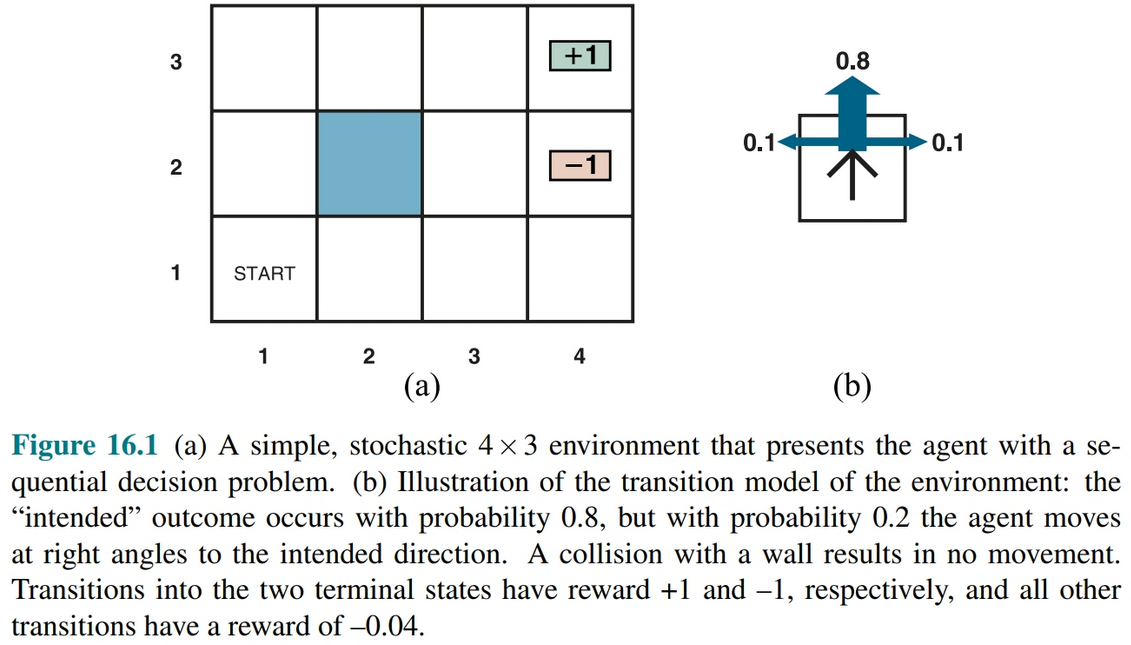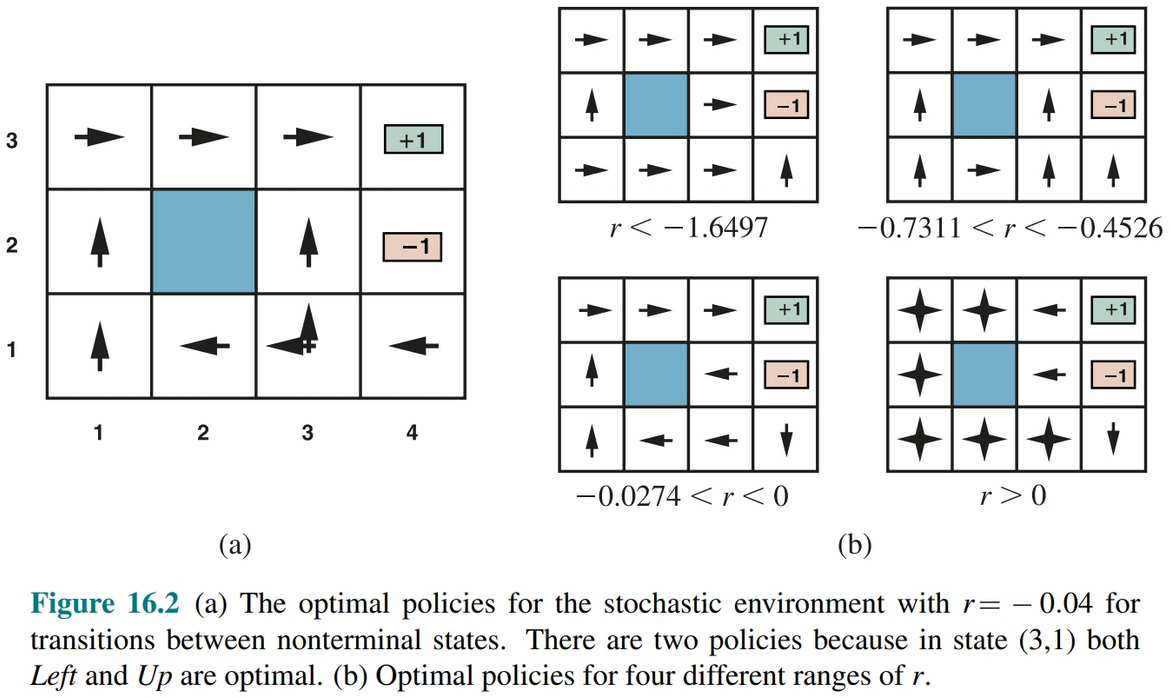

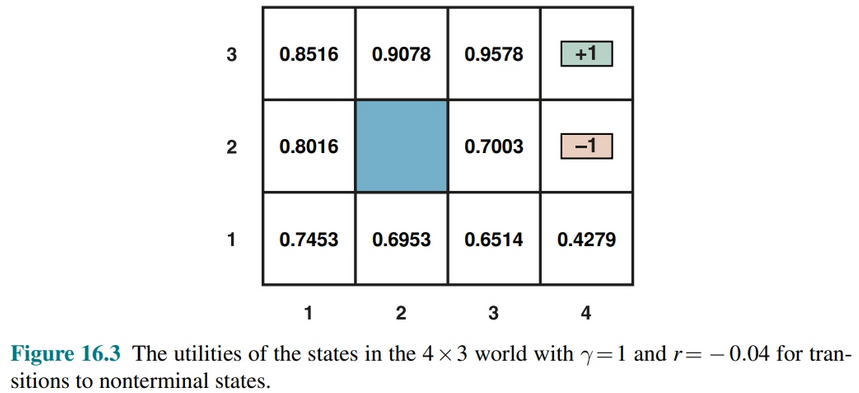

##The model of stochastic motion

In [7]:
transition_probabilities = [0.8, 0.1, 0.0, 0.1]
action_probabilities = [0.25, 0.25, 0.25, 0.25]

In [8]:
from scipy import stats
import numpy as np

xk = np.arange(len(transition_probabilities))
pk = transition_probabilities
transition_distribution = stats.rv_discrete(name='transition_distribution', values=(xk, pk))

xk = np.arange(len(action_probabilities))
pk = action_probabilities
action_distribution = stats.rv_discrete(name='action_distribution', values=(xk, pk))

In [9]:
def action_index_to_string(action):
    if action == 0:
      return("up")
    elif action == 1:
      return("right")
    elif action == 2:
        return("down")
    elif action == 3:
        return("left")

In [10]:
def transition_index_to_string(transition):
    if transition == 0:
      #return("up")
      return("front")
    elif transition == 1:
      return("right")
    elif transition == 2:
        return("back")
    elif transition == 3:
        return("left")

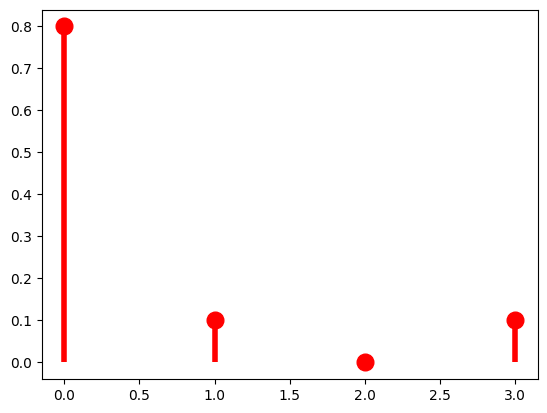

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(xk, transition_distribution.pmf(xk), 'ro', ms=12, mec='r')
ax.vlines(xk, 0, transition_distribution.pmf(xk), colors='r', lw=4)
plt.show()

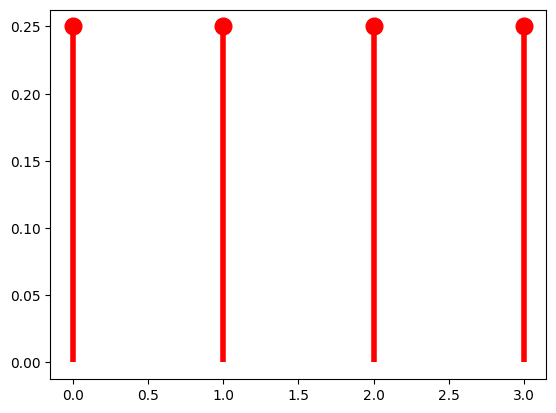

In [12]:
fig, ax = plt.subplots(1, 1)
ax.plot(xk, action_distribution.pmf(xk), 'ro', ms=12, mec='r')
ax.vlines(xk, 0, action_distribution.pmf(xk), colors='r', lw=4)
plt.show()

In [13]:
transition_distribution_samples = []
for i in range(44):
  transition_distribution_sample = transition_distribution.rvs(size=1)[0]
  transition_distribution_samples.append(transition_distribution_sample)
print("transition_distribution_samples: ", transition_distribution_samples)

transition_distribution_samples:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]


In [14]:
transition_distribution_samples = []
for i in range(44):
  transition_distribution_sample = transition_distribution.rvs(size=1)[0]
  transition_distribution_samples.append(transition_index_to_string(transition_distribution_sample))
print("transition_distribution_samples: ", transition_distribution_samples)

transition_distribution_samples:  ['front', 'front', 'front', 'front', 'front', 'front', 'front', 'front', 'left', 'front', 'front', 'front', 'front', 'right', 'front', 'front', 'front', 'right', 'front', 'right', 'right', 'front', 'right', 'front', 'right', 'left', 'front', 'left', 'front', 'front', 'front', 'front', 'front', 'right', 'front', 'front', 'front', 'front', 'front', 'front', 'front', 'front', 'front', 'front']


In [15]:
def deterministic_transition_model(transition_sample, intended_action):
  actual_action = (intended_action + transition_sample)%4
  return actual_action

In [16]:
def stochastic_transition_model(transition_probabilities, intended_action):
  xk = np.arange(len(transition_probabilities))
  pk = transition_probabilities
  transition_distribution = stats.rv_discrete(name='transition_distribution', values=(xk, pk))
  transition_distribution_sample = transition_distribution.rvs(size=1)[0]
  actual_action = deterministic_transition_model(transition_distribution_sample, intended_action)
  return actual_action

In [17]:
for intended_action in range(4):
  for transition_distribution_sample in range(4):
    print("intended_action_quasi_sample: ", action_index_to_string(intended_action))
    print("transition_distribution_quasi_sample: ", transition_index_to_string(transition_distribution_sample))
    actual_action = deterministic_transition_model(transition_distribution_sample, intended_action)
    print("actual_action_quasi_sample: ", action_index_to_string(actual_action))
    print()

intended_action_quasi_sample:  up
transition_distribution_quasi_sample:  front
actual_action_quasi_sample:  up

intended_action_quasi_sample:  up
transition_distribution_quasi_sample:  right
actual_action_quasi_sample:  right

intended_action_quasi_sample:  up
transition_distribution_quasi_sample:  back
actual_action_quasi_sample:  down

intended_action_quasi_sample:  up
transition_distribution_quasi_sample:  left
actual_action_quasi_sample:  left

intended_action_quasi_sample:  right
transition_distribution_quasi_sample:  front
actual_action_quasi_sample:  right

intended_action_quasi_sample:  right
transition_distribution_quasi_sample:  right
actual_action_quasi_sample:  down

intended_action_quasi_sample:  right
transition_distribution_quasi_sample:  back
actual_action_quasi_sample:  left

intended_action_quasi_sample:  right
transition_distribution_quasi_sample:  left
actual_action_quasi_sample:  up

intended_action_quasi_sample:  down
transition_distribution_quasi_sample:  front
a

In [18]:
class AIMA_example_stochastic_transition_model:

  def __init__(self, transition_probabilities):
    self._transition_probabilities = transition_probabilities
    xk = np.arange(len(transition_probabilities))
    pk = transition_probabilities
    self._transition_distribution =stats.rv_discrete(name='transition_distribution', values=(xk, pk))

  def act(self, intended_action):
    transition_sample = self._transition_distribution.rvs(size=1)[0]
    actual_action = (intended_action + transition_sample)%4
    return actual_action

In [19]:
#@title Implement GridWorld { form-width: "30%" }


class ObservationType(enum.IntEnum):
  STATE_INDEX = enum.auto()
  AGENT_ONEHOT = enum.auto()
  GRID = enum.auto()
  AGENT_GOAL_POS = enum.auto()


class GridWorld(dm_env.Environment):

  def __init__(self,
               layout,
               start_state,
               goal_state=None,
               bad_terminal_state=None, #zmienilem lekko
               observation_type=ObservationType.STATE_INDEX,
               #discount=0.9, #zmieniłem
               #discount=0.0, #zmieniłem
               discount=1.0, #zmieniłem
               penalty_for_walls=0,
               reward_goal=1,
               bad_terminal_state_reward=-1, #dopisalem
               empty_cell_penalty=-0.04,  #dopisalem
               #empty_cell_penalty=-0.01,  #dopisalem
               max_episode_length=None,
               randomize_goals=False):
    """Build a grid environment.

    Simple gridworld defined by a map layout, a start and a goal state.

    Layout should be a NxN grid, containing:
      * 0: empty
      * -1: wall
      * Any other positive value: value indicates reward; episode will terminate

    Args:
      layout: NxN array of numbers, indicating the layout of the environment.
      start_state: Tuple (y, x) of starting location.
      goal_state: Optional tuple (y, x) of goal location. Will be randomly
        sampled once if None.
      observation_type: Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x)
      discount: Discounting factor included in all Timesteps.
      penalty_for_walls: Reward added when hitting a wall (...).
      reward_goal: Reward added when finding the goal (should be positive).
      max_episode_length: If set, will terminate an episode after this many
        steps.
      randomize_goals: If true, randomize goal at every episode.
    """
    if observation_type not in ObservationType:
      raise ValueError('observation_type should be a ObservationType instace.')
    self._layout = np.array(layout)
    self._start_state = start_state
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._empty_cell_penalty = empty_cell_penalty #dopisałem
    self._reward_goal = reward_goal
    self._bad_terminal_state_reward = bad_terminal_state_reward #dopisałem
    self._observation_type = observation_type
    self._layout_dims = self._layout.shape
    self._max_episode_length = max_episode_length
    self._num_episode_steps = 0
    self._randomize_goals = randomize_goals
    if goal_state is None:
      # Randomly sample goal_state if not provided
      goal_state = self._sample_goal()
    self.goal_state = goal_state
    if bad_terminal_state is None: #dopisałem
      # Randomly sample goal_state if not provided #dopisałem
      #bad_terminal_state = self._sample_bad_terminal_state() #dopisałem, todo test _sample_bad_terminal_state
      pass
    self.bad_terminal_state = bad_terminal_state #dopisałem
    self._transition_probabilities = [0.8, 0.0, 0.1, 0.1] #dopisałem
    self._stochastic_transition_model = AIMA_example_stochastic_transition_model(self._transition_probabilities) #dopisałem


  def _sample_goal(self):
    """Randomly sample reachable non-starting state."""
    # Sample a new goal
    n = 0
    max_tries = 1e5
    while n < max_tries:
      goal_state = tuple(np.random.randint(d) for d in self._layout_dims)
      if goal_state != self._state and self._layout[goal_state] == 0:
        # Reachable state found!
        return goal_state
      n += 1
    raise ValueError('Failed to sample a goal state.')

  def _sample_bad_terminal_state(self):
    n = 0
    max_tries = 1e5
    while n < max_tries:
      bad_terminal_state = tuple(np.random.randint(d) for d in self._layout_dims)
      if bad_terminal_state != self._state and self._layout[bad_terminal_state] == 0:
        # Reachable state found!
        return bad_terminal_state
      n += 1
    raise ValueError('Failed to sample a bad terminal state.')

  @property
  def layout(self):
    return self._layout

  @property
  def number_of_states(self):
    return self._number_of_states

  @property
  def goal_state(self):
    return self._goal_state

  @property
  def start_state(self):
    return self._start_state

  @property
  def state(self):
    return self._state

  def set_state(self, x, y):
    self._state = (y, x)

  @goal_state.setter
  def goal_state(self, new_goal):
    if new_goal == self._state or self._layout[new_goal] < 0:
      raise ValueError('This is not a valid goal!')
    # Zero out any other goal
    self._layout[self._layout > 0] = 0
    # Setup new goal location
    self._layout[new_goal] = self._reward_goal
    self._goal_state = new_goal

  def observation_spec(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      return specs.Array(
          shape=self._layout_dims,
          dtype=np.float32,
          name='observation_agent_onehot')
    elif self._observation_type is ObservationType.GRID:
      return specs.Array(
          shape=self._layout_dims + (3,),
          dtype=np.float32,
          name='observation_grid')
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return specs.Array(
          shape=(4,), dtype=np.float32, name='observation_agent_goal_pos')
    elif self._observation_type is ObservationType.STATE_INDEX:
      return specs.DiscreteArray(
          self._number_of_states, dtype=int, name='observation_state_index')

  def action_spec(self):
    return specs.DiscreteArray(4, dtype=int, name='action')

  def get_obs(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      obs = np.zeros(self._layout.shape, dtype=np.float32)
      # Place agent
      obs[self._state] = 1
      return obs
    elif self._observation_type is ObservationType.GRID:
      obs = np.zeros(self._layout.shape + (3,), dtype=np.float32)
      obs[..., 0] = self._layout < 0
      obs[self._state[0], self._state[1], 1] = 1
      obs[self._goal_state[0], self._goal_state[1], 2] = 1
      return obs
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return np.array(self._state + self._goal_state, dtype=np.float32)
    elif self._observation_type is ObservationType.STATE_INDEX:
      y, x = self._state
      return y * self._layout.shape[1] + x

  def reset(self):
    self._state = self._start_state
    self._num_episode_steps = 0
    if self._randomize_goals:
      self.goal_state = self._sample_goal()
    return dm_env.TimeStep(
        step_type=dm_env.StepType.FIRST,
        reward=None,
        discount=None,
        observation=self.get_obs())

  def step(self, action):
    y, x = self._state

    action = self._stochastic_transition_model.act(action) #dopisałem

    if action == 0:  # up
        new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError(
          'Invalid action: {} is not 0, 1, 2, or 3.'.format(action))

    new_y, new_x = new_state
    step_type = dm_env.StepType.MID
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif new_y == self.bad_terminal_state[0] and new_x == self.bad_terminal_state[1]: # Bad terminal state reward -1  #dopisałem
      reward = self._bad_terminal_state_reward  #dopisałem
      discount = 0.  #dopisałem
      new_state = self._start_state #dopisałem
      step_type = dm_env.StepType.LAST #dopisałem
      #print("Bad terminal state!")
    elif self._layout[new_y, new_x] == 0:  # empty cell
      #reward = 0.
      reward = self._empty_cell_penalty
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
      step_type = dm_env.StepType.LAST

    self._state = new_state
    self._num_episode_steps += 1
    if (self._max_episode_length is not None and
        self._num_episode_steps >= self._max_episode_length):
      step_type = dm_env.StepType.LAST
    return dm_env.TimeStep(
        step_type=step_type,
        reward=np.float32(reward),
        discount=discount,
        observation=self.get_obs())

  def plot_grid(self, add_start=True):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout <= -1, interpolation='nearest')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    # Add start/goal
    if add_start:
      plt.text(
          self._start_state[1],
          self._start_state[0],
          r'$\mathbf{S}$',
          fontsize=16,
          ha='center',
          va='center')
    plt.text(
        self._goal_state[1],
        self._goal_state[0],
        r'$\mathbf{G}$',
        fontsize=16,
        ha='center',
        va='center')
    plt.text(
        self.bad_terminal_state[1],
        self.bad_terminal_state[0],
        r'$\mathbf{B}$',
        fontsize=16,
        ha='center',
        va='center')
    h, w = self._layout.shape
    for y in range(h - 1):
      plt.plot([-0.5, w - 0.5], [y + 0.5, y + 0.5], '-k', lw=2)
    for x in range(w - 1):
      plt.plot([x + 0.5, x + 0.5], [-0.5, h - 0.5], '-k', lw=2)

  def plot_state(self, return_rgb=False):
    self.plot_grid(add_start=False)
    # Add the agent location
    plt.text(
        self._state[1],
        self._state[0],
        u'😃',
        fontname='symbola',
        fontsize=18,
        ha='center',
        va='center',
    )
    if return_rgb:
      fig = plt.gcf()
      plt.axis('tight')
      plt.subplots_adjust(0, 0, 1, 1, 0, 0)
      fig.canvas.draw()
      data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
      w, h = fig.canvas.get_width_height()
      data = data.reshape((h, w, 3))
      plt.close(fig)
      return data

  def plot_policy(self, policy):
    action_names = [
        r'$\uparrow$', r'$\rightarrow$', r'$\downarrow$', r'$\leftarrow$'
    ]
    self.plot_grid()
    plt.title('Policy Visualization')
    h, w = self._layout.shape
    for y in range(h):
      for x in range(w):
        # if ((y, x) != self._start_state) and ((y, x) != self._goal_state):
#        if (y, x) != self._goal_state:
        if (y, x) != self._goal_state and (y, x) != self.bad_terminal_state:
          action_name = action_names[policy[y, x]]
          plt.text(x, y, action_name, ha='center', va='center')

  def plot_greedy_policy(self, q):
    greedy_actions = np.argmax(q, axis=2)
    self.plot_policy(greedy_actions)


def build_gridworld_task(task,
                         #discount=0.9, #zmieniłem
                         #discount=0.0, #zmieniłem
                         discount=1.0, #zmieniłem
                         #penalty_for_walls=-5,
                         penalty_for_walls=0,
                         empty_cell_penalty=-0.04,  #dopisalem
                         observation_type=ObservationType.STATE_INDEX,
                         max_episode_length=200):
  """Construct a particular Gridworld layout with start/goal states.

  Args:
      task: string name of the task to use. One of {'simple', 'obstacle',
        'random_goal'}.
      discount: Discounting factor included in all Timesteps.
      penalty_for_walls: Reward added when hitting a wall (should be negative).
      observation_type: Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x).
      max_episode_length: If set, will terminate an episode after this many
        steps.
  """
  tasks_specifications = {
      'AIMA': {
          'layout': [
                     [-1, -1, -1, -1, -1, -1,],
                     [-1, 0, 0, 0, 0, -1],
                     [-1, 0, -1, 0, 0,-1],
                     [-1, 0, 0, 0, 0, -1],
                     [-1, -1, -1, -1, -1, -1,]
          ],
          'start_state': (3, 1),
          'goal_state': (1, 4),
          'bad_terminal_state': (2, 4)
      },
  }
  return GridWorld(
      discount=discount,
      penalty_for_walls=penalty_for_walls,
      observation_type=observation_type,
      max_episode_length=max_episode_length,
      empty_cell_penalty=empty_cell_penalty,  #dopisalem
      **tasks_specifications[task])


def setup_environment(environment):
  """Returns the environment and its spec."""

  # Make sure the environment outputs single-precision floats.
  environment = wrappers.SinglePrecisionWrapper(environment)

  # Grab the spec of the environment.
  environment_spec = specs.make_environment_spec(environment)

  return environment, environment_spec


We will use two distinct tabular GridWorlds:
* `simple` where the goal is at the bottom left of the grid, little navigation required.
* `obstacle` where the goal is behind an obstacle the agent must avoid.

You can visualize the grid worlds by running the cell below.

Note that **S** indicates the start state and **G** indicates the goal.


Text(0.5, 1.0, 'AIMA')

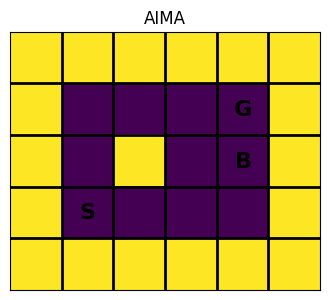

In [20]:
# @title Visualise GridWorlds { form-width: "30%" }

# Instantiate two tabular environments, a simple task, and one that involves
# the avoidance of an obstacle.
simple_grid = build_gridworld_task(
    task='AIMA', observation_type=ObservationType.GRID)
#obstacle_grid = build_gridworld_task(
#    task='obstacle', observation_type=ObservationType.GRID)

# Plot them.
simple_grid.plot_grid()
plt.title('AIMA')

#obstacle_grid.plot_grid()
#plt.title('Obstacle');


In this environment, the agent has four possible  <font color='blue'>**actions**</font>: `up`, `right`, `down`, and `left`.  The <font color='green'>**reward**</font> is `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise. The episode ends when the agent reaches the goal, and otherwise continues. The **discount** on continuing steps, is $\gamma = 0.9$.

Before we start building an agent to interact with this environment, let's first look at the types of objects the environment either returns (e.g. <font color='redorange'>**observations**</font>) or consumes (e.g. <font color='blue'>**actions**</font>). The `environment_spec` will show you the form of the <font color='redorange'>**observations**</font>, <font color='green'>**rewards**</font> and **discounts** that the environment exposes and the form of the <font color='blue'>**actions**</font> that can be taken.


In [21]:
# Note: setup_environment is implemented in the same cell as GridWorld.
environment, environment_spec = setup_environment(simple_grid)
#environment, environment_spec = setup_environment(obstacle_grid)

print('actions:\n', environment_spec.actions, '\n')
print('observations:\n', environment_spec.observations, '\n')
print('rewards:\n', environment_spec.rewards, '\n')
print('discounts:\n', environment_spec.discounts, '\n')

print("bad_terminal_state: ", (environment.bad_terminal_state[1], environment.bad_terminal_state[0]))

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 

observations:
 Array(shape=(5, 6, 3), dtype=dtype('float32'), name='observation_grid') 

rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward') 

discounts:
 BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 

bad_terminal_state:  (4, 2)



We first set the environment to its initial location by calling the `reset()` method which returns the first observation.


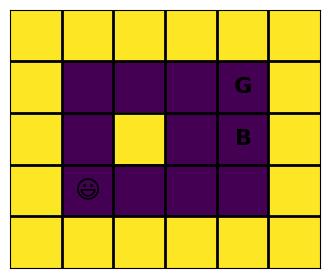

In [22]:
environment.reset()
environment.plot_state()

Now we want to take an action to interact with the environment. We do this by passing a valid action to the `dm_env.Environment.step()` method which returns a `dm_env.TimeStep` namedtuple with fields `(step_type, reward, discount, observation)`.

Let's take an action and visualise the resulting state of the grid-world.

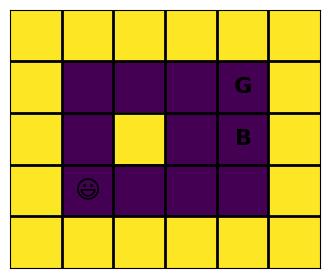

In [23]:
#@title Pick an action and see the state changing
action = 0 #@param ["0", "1", "2", "3"] {type:"raw"}

action = int(action)
timestep = environment.step(action)  # pytype: dm_env.TimeStep
environment.plot_state()

In [24]:
environment.environment._bad_terminal_state_reward

-1

In [25]:
#@title Implement the run loop  { form-width: "30%" }

def run_loop(
    environment: dm_env.Environment,
    agent: acme.Actor,
    num_episodes: Optional[int] = None,
    num_steps: Optional[int] = None,
    logger_time_delta: float = .25,
    label: str = 'training_loop',
    log_loss: bool = False,
):
  """Perform the run loop.

  We are following the Acme run loop.

  Run the environment loop for `num_episodes` episodes. Each episode is itself
  a loop which interacts first with the environment to get an observation and
  then give that observation to the agent in order to retrieve an action. Upon
  termination of an episode a new episode will be started. If the number of
  episodes is not given then this will interact with the environment
  infinitely.

  Args:
    environment: dm_env.Environment used to generate trajectories.
    agent: acme.Actor for selecting actions in the run loop.
    num_steps: number of steps to run the loop for. If `None` (default), runs
      without limit.
    num_episodes: number of episodes to run the loop for. If `None` (default),
      runs without limit.
    logger_time_delta: time interval (in seconds) between consecutive logging
      steps.
    label: optional label used at logging steps.
  """
  logger = loggers.TerminalLogger(label=label, time_delta=logger_time_delta)
  iterator = range(num_episodes) if num_episodes else itertools.count()
  all_returns = []

  num_total_steps = 0
  for episode in iterator:
    # Reset any counts and start the environment.
    start_time = time.time()
    episode_steps = 0
    episode_return = 0
    episode_loss = 0

    timestep = environment.reset()

    # Make the first observation.
    agent.observe_first(timestep)

    # Run an episode.
    while not timestep.last():
      # Generate an action from the agent's policy and step the environment.
      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)

      # Have the agent observe the timestep and let the agent update itself.
      agent.observe(action, next_timestep=timestep)
      agent.update()

      # Book-keeping.
      episode_steps += 1
      num_total_steps += 1
      episode_return += timestep.reward

      if log_loss:
        episode_loss += agent.last_loss

      if num_steps is not None and num_total_steps >= num_steps:
        break

    # Collect the results and combine with counts.
    steps_per_second = episode_steps / (time.time() - start_time)
    result = {
        'episode': episode,
        'episode_length': episode_steps,
        'episode_return': episode_return,
    }
    if log_loss:
      result['loss_avg'] = episode_loss / episode_steps

    all_returns.append(episode_return)

    # Log the given results.
    logger.write(result)

    if num_steps is not None and num_total_steps >= num_steps:
      break

  return all_returns

In [26]:
#@title Implement the evaluation loop { form-width: "30%" }

def evaluate(environment: dm_env.Environment,
             agent: acme.Actor,
             evaluation_episodes: int):
  frames = []

  for episode in range(evaluation_episodes):
    timestep = environment.reset()
    episode_return = 0
    steps = 0
    while not timestep.last():
      frames.append(environment.plot_state(return_rgb=True))

      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)
      steps += 1
      episode_return += timestep.reward
    print(
        f'Episode {episode} ended with reward {episode_return} in {steps} steps'
    )
  return frames

def display_video(frames: Sequence[np.ndarray],
                  filename: str = 'temp.mp4',
                  frame_rate: int = 12):
  """Save and display video."""
  # Write the frames to a video.
  with imageio.get_writer(filename, fps=frame_rate) as video:
    for frame in frames:
      video.append_data(frame)

  # Read video and display the video.
  video = open(filename, 'rb').read()
  b64_video = base64.b64encode(video)
  video_tag = ('<video  width="320" height="240" controls alt="test" '
               'src="data:video/mp4;base64,{0}">').format(b64_video.decode())
  return IPython.display.HTML(video_tag)


## Agent

We will be implementing Tabular & Function Approximation agents. Tabular agents are purely in Python and Function Approximation agents, we will use Tensorflow (v2).

All agents will share the same interface from the Acme `Actor`. Here we borrow a figure from Acme to show how this interaction occurs:


### Agent interface


<center><img src="https://drive.google.com/uc?id=1T7FTpA9RgDYFkciDFZK4brNyURZN_ZGp" width="500" /></center>

Each agent implements the following functions:

```python
class Agent(acme.Actor):
  def __init__(self, number_of_actions, number_of_states, ...):
    """Provides the agent the number of actions and number of states."""

  def select_action(self, observation):
    """Generates actions from observations."""

  def observe_first(self, timestep):
    """Records the initial timestep in a trajectory."""
  
  def observe(self, action, next_timestep):
    """Records the transition which occurred from taking an action."""

  def update(self):
    """Updates the agent's internals to potentially change its behavior."""
```

Remarks on the `observe()` function:

1. In the last method, the `next_timestep` provides the `reward`, `discount`, and `observation` that resulted from selecting `action`.

2. The `next_timestep.step_type` will be either `MID` or `LAST` and should be used to determine whether this is the last observation in the episode.

3. The `next_timestep.step_type` cannot be `FIRST`; such a timestep should only ever be given to `observe_first()`.


### Random Agent

We can just choose actions randomly to move around this environment.

In [27]:
#@title Implementation  { form-width: "30%" }

class RandomAgent(acme.Actor):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    return np.random.randint(self._num_actions)

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass

In [28]:
#@title Visualisation { form-width: "30%" }

# Create the agent by giving it the action space specification.
agent = RandomAgent(environment_spec)

# Run the agent in the evaluation loop, which returns the frames.
#frames = evaluate(environment, agent, evaluation_episodes=1)

# Visualize the random agent's episode.
#display_video(frames)

# Deeper look at a tabular Q-learning agent operating in a toy gridworld environment (AIMA gridworld example)


## Relation between state value function and state-action value function (Q-function) observed by means of action values plotting


In [29]:
# Create the environment.
grid = build_gridworld_task(
    #task='simple',
    task='AIMA',
    observation_type=ObservationType.STATE_INDEX,  # Notice the difference here.
    max_episode_length=200)
environment, environment_spec = setup_environment(grid)

# Notice the difference between this observation specification and that above.
print('observation specification:\n', environment_spec.observations)

observation specification:
 DiscreteArray(shape=(), dtype=int32, name=observation_state_index, minimum=0, maximum=29, num_values=30)


###Policy “greedification” for action values plotting

In [30]:
#@title Implement helpers for value visualisation  { form-width: "30%" }

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))

    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")

  plt.subplot(3, 3, 5)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)

def plot_stats(stats, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(stats.episode_lengths), window)
  plt.plot(xline, smooth(stats.episode_lengths, window=window))
  plt.ylabel('Episode Length')
  plt.xlabel('Episode Count')
  plt.subplot(122)
  plt.plot(xline, smooth(stats.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

### Implement epsilon-greedy

In [31]:
# @title **[Coding task]** Epilson-greedy policy { form-width: "30%" }

def epsilon_greedy(
    q_values_at_s: np.ndarray,  # Q-values in state s: Q(s, :).
    epsilon: float = 0.1,  # Probability of taking a random action.
):
  """Return an epsilon-greedy action sample."""
  pass

In [32]:
# @title **[Solution]** Epilson-greedy policy { form-width: "30%" }

def epsilon_greedy(
    q_values_at_s: np.ndarray,  # Q-values in state s: Q(s, :).
    epsilon: float = 0.1,  # Probability of taking a random action.
):
  """Return an epsilon-greedy action sample."""
  if epsilon < np.random.random():
    # Greedy: Pick action with the largest Q-value.
    return np.argmax(q_values_at_s)
  else:
    # Get the number of actions from the size of the given vector of Q-values.
    num_actions = np.array(q_values_at_s).shape[-1]
    return np.random.randint(num_actions)

In [33]:
#@title **[Solution]** Q-Learning Agent { form-width: "30%" }

QValues = np.ndarray
Action = int
# A policy takes an observation and returns an action.
ValueBasedPolicy = Callable[[QValues], Action]

class QLearningAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               behaviour_policy: ValueBasedPolicy,
               step_size: float = 0.1,
               ):

    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size

    # Store behavior policy.
    self._behaviour_policy = behaviour_policy

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])

  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute the TD error.
    self._action = a
    self._next_state = next_s
    self._td_error = r + g * np.max(self._q[next_s]) - self._q[s, a] # Szwabe: Describe this way of computing the TD error. Compare it to SARSA.
    # Nowak: This computes the TD error using the **max** Q-value of the next state (off-policy), which is the key idea in Q-learning.
    #        Unlike SARSA, which uses the Q-value of the actual action taken in the next state (on-policy), Q-learning assumes the best possible action will be taken from the next state.

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action

    # Update the Q-value table value at (s, a).
    self._q[s, a] += self._step_size * self._td_error

    # Update the current state.
    self._state = self._next_state

Szwabe: Compare each of the 4 cases below (for different values of r) to the corresponding case presented in the AIMA book. Describe the agent's behavior for each of the four r factor values pointing out the values of cells that are the most indicative for each of the values.

AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...


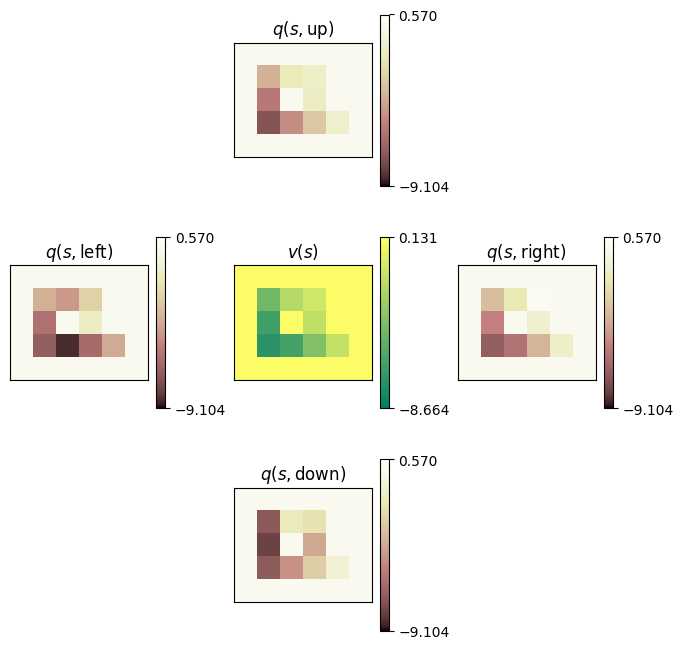

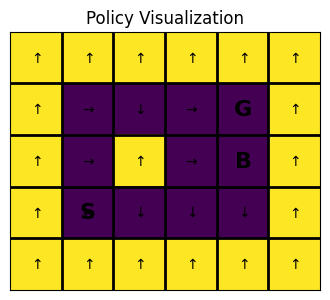

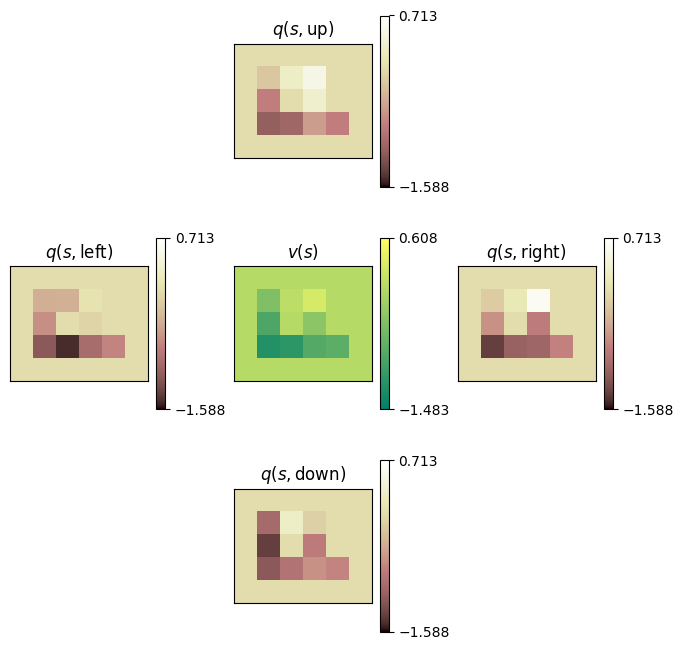

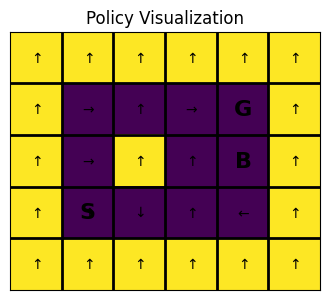

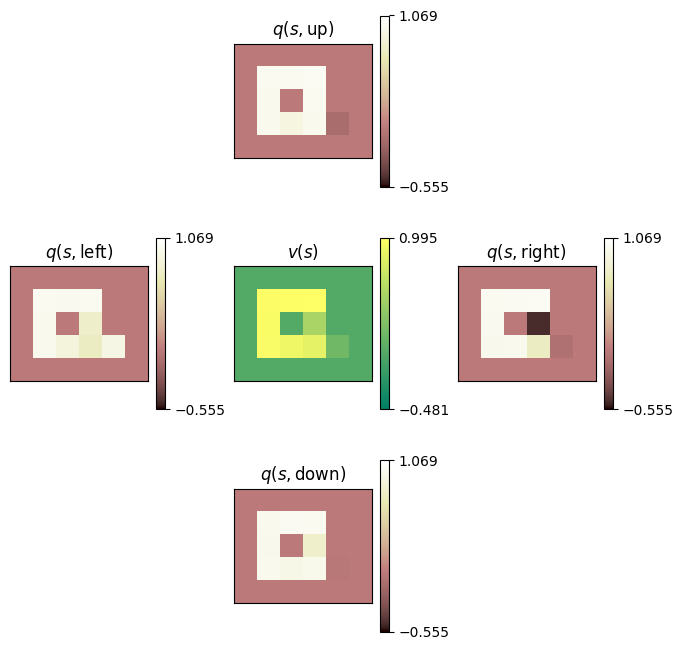

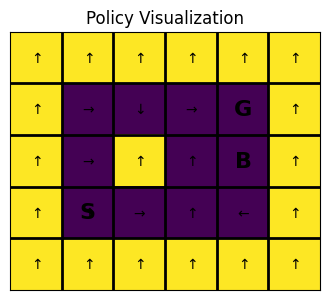

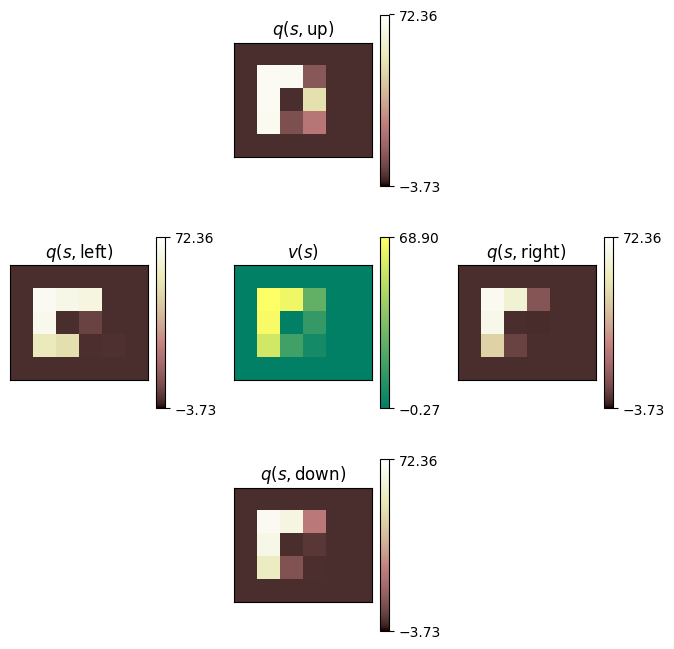

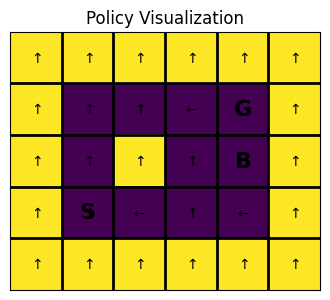

In [34]:
num_steps = 1e5 #@param {type:"number"}
num_steps = int(num_steps)

# behavior policy
epsilon=0.1
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

test_r_values = [-2.0, -0.5, -0.01, 0.1]

for test_r_value in test_r_values:

  # Create the environment.
  #grid = build_gridworld_task(task='obstacle')
  grid = build_gridworld_task(task='AIMA', empty_cell_penalty=test_r_value)
  environment, environment_spec = setup_environment(grid)

  # Create the agent.
  #agent = SarsaAgent(environment_spec, epsilon=0.1, step_size=0.1)

  agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.1)


  # Run the experiment and get the value functions from agent
  returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)
  print('AFTER {0:,} STEPS ...'.format(num_steps))

  # Get the Q-values and reshape them to recover grid-like structure of states.
  q_values = agent.q_values
  grid_shape = grid.layout.shape
  q_values = q_values.reshape([*grid_shape, -1])

  # Visualize the value and Q-value tables.
  plot_action_values(q_values, epsilon=1.)

  # Visualize the greedy policy.
  environment.plot_greedy_policy(q_values)

# Nowak:

#### `r = -2.0`
- Agent wants to reach a terminal state as fast as possible — even choosing death over goal if faster.
- Strongly avoids any unnecessary steps.
- Similar to AIMA: large negative step cost leads to shortest, most direct (and sometimes self-destructive) behavior.

#### `r = -0.5`
- Still prefers short paths, but slightly more tolerant of detours.
- Penalizes wandering, but not as harshly.
- Reflects AIMA's moderate negative reward case.

#### `r = -0.01`
- Mild penalty makes agent willing to explore more.
- Less focused on efficiency, more uniform value map.
- Matches AIMA's observation: small negative rewards reduce urgency.

#### `r = 0.1`
- Agent is rewarded for moving, so it avoids termination.
- May loop endlessly or avoid goal.
- Classic AIMA example: poorly chosen positive reward leads to irrational behavior.

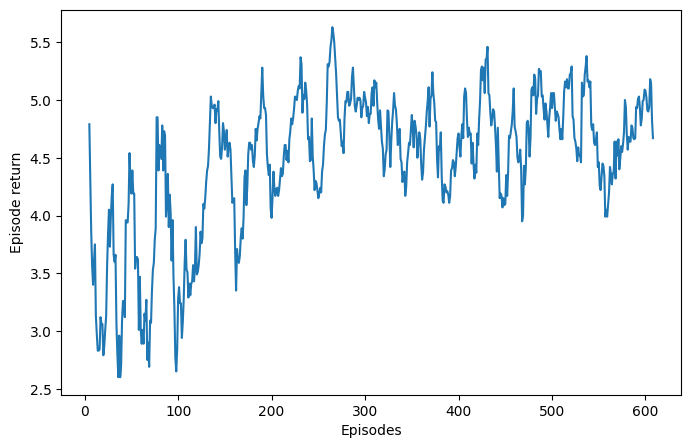

In [35]:
#@title Visualise the training curve { form-width: "30%" }

# Compute rolling average over returns
returns_avg = pd.Series(returns).rolling(10, center=True).mean()

plt.figure(figsize=(8, 5))
plt.plot(range(len(returns)), returns_avg)
plt.xlabel('Episodes')
plt.ylabel('Episode return');

#“Microscopic view” on the exploration-exploitation trade-off along the Q values learning

Reminder: $\color{green}Q$-learning is a very powerful and general algorithm, that enables control (figuring out the optimal policy/value function) both on and off-policy.

**Initialize** $\color{green}Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s} \in \color{red}{\mathcal{S}}$ and $\color{blue}{a} \in \color{blue}{\mathcal{A}}$

**Loop forever**:

1. Get $\color{red}{s} \gets{}$current (non-terminal) state

2. Select $\color{blue}{a} \gets{} \text{behaviour_policy}(\color{red}{s})$

3. Step in the environment by passing the selected action $\color{blue}{a}$

4. Observe resulting reward $\color{green}{r}$, discount $\gamma$, and state, $\color{red}{s'}$

5. Compute the TD error: $\Delta \color{green}Q \gets \color{green}{r} + \gamma \color{green}Q(\color{red}{s'}, \color{blue}{a'}) − \color{green}Q(\color{red}{s}, \color{blue}{a})$, <br>
where $\color{blue}{a'} \gets \arg\max_{\color{blue}{\mathcal A}} \color{green}Q(\color{red}{s'}, \cdot)$

6. Update $\color{green}Q(\color{red}{s}, \color{blue}{a}) \gets \color{green}Q(\color{red}{s}, \color{blue}{a}) + \alpha \Delta \color{green}Q$

Notice that the actions $\color{blue}{a}$ and $\color{blue}{a'}$ are not selected using the same policy, hence this algorithm being **off-policy**.

In [37]:
#@title **[Solution]** Q-Learning Agent { form-width: "30%" }

QValues = np.ndarray
Action = int
# A policy takes an observation and returns an action.
ValueBasedPolicy = Callable[[QValues], Action]

class QLearningAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               behaviour_policy: ValueBasedPolicy,
               step_size: float = 0.1,
               ):

    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size

    # Store behavior policy.
    self._behaviour_policy = behaviour_policy

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])

  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute the TD error.
    self._action = a
    self._next_state = next_s
    self._td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action

    # Update the Q-value table value at (s, a).
    self._q[s, a] += self._step_size * self._td_error

    # Update the current state.
    self._state = self._next_state

### **Task 1**: Run your Q-learning agent



AFTER 100,000 STEPS ...


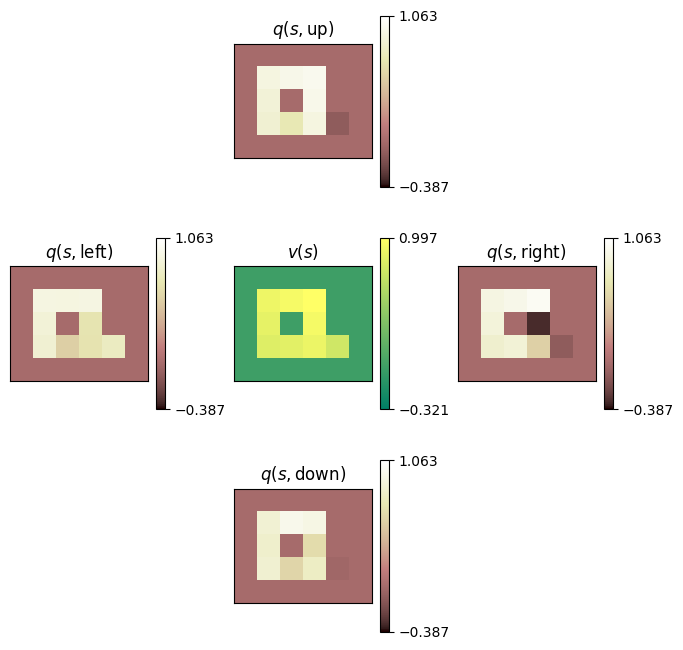

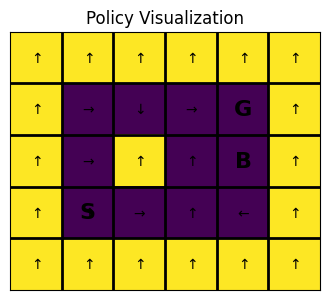

In [38]:
epsilon =   0.1#@param {type:"number"}
num_steps = 1e5  #@param {type:"number"}
num_steps = int(num_steps)
num_episodes = 8000
num_episodes = int(num_episodes)

# environment
#grid = build_gridworld_task(task='obstacle')
grid = build_gridworld_task(task='AIMA')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.1)

# run experiment and get the value functions from agent
#returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps, num_episodes=num_episodes)

# get the q-values
q = agent.q_values.reshape(grid.layout.shape + (4,))

# visualize value functions
print('AFTER {:,} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=0)

# visualise the greedy policy
grid.plot_greedy_policy(q)

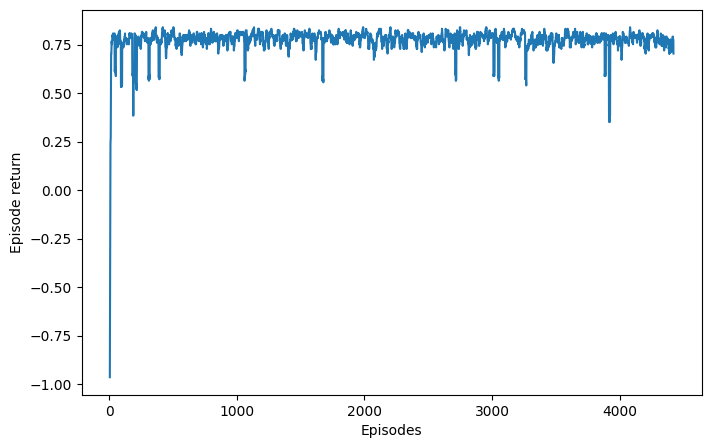

In [39]:
#@title Visualise the training curve { form-width: "30%" }

# Compute rolling average over returns
returns_avg = pd.Series(returns).rolling(10, center=True).mean()

plt.figure(figsize=(8, 5))
plt.plot(range(len(returns)), returns_avg)
plt.xlabel('Episodes')
plt.ylabel('Episode return');

In [40]:
AIMA_Fig_16_3_states_values = np.array(
      [[0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.8516, 0.9078, 0.9578 , 0.   , 0.   ],
       [0.   , 0.8016, 0.   , 0.7003, 0.   , 0.   ],
       [0.   , 0.7453, 0.6953, 0.6514, 0.4279, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])
AIMA_Fig_16_3_states_values

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.852, 0.908, 0.958, 0.   , 0.   ],
       [0.   , 0.802, 0.   , 0.7  , 0.   , 0.   ],
       [0.   , 0.745, 0.695, 0.651, 0.428, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])

AFTER 100,000 STEPS ...


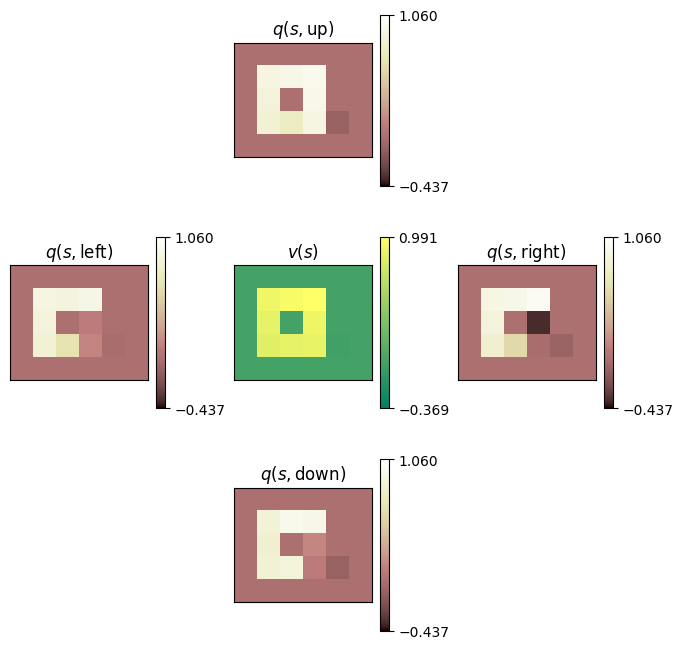

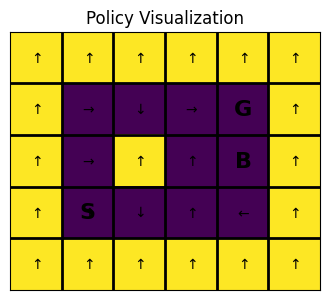

In [41]:
epsilon = 0.05  #@param {type:"number"}
num_steps = 1e5  #@param {type:"number"}
num_steps = int(num_steps)

num_episodes = 8000
num_episodes = int(num_episodes)

# environment
grid = build_gridworld_task(task='AIMA')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.1)

# run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

# get the q-values
q = agent.q_values.reshape(grid.layout.shape + (4,))

# visualize value functions
print('AFTER {:,} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=epsilon)

# visualise the greedy policy
grid.plot_greedy_policy(q)

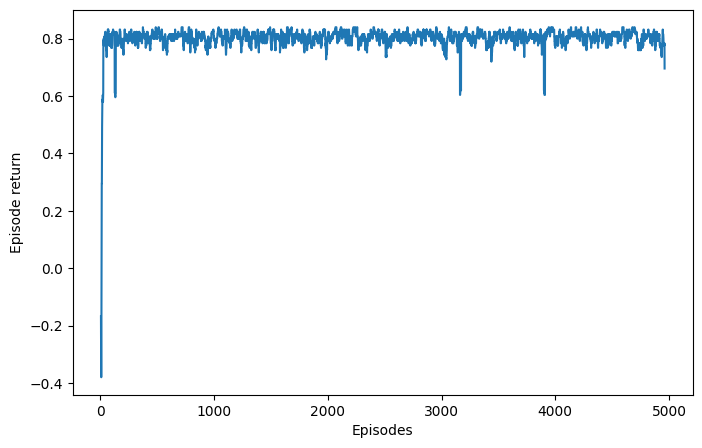

In [42]:
#@title Visualise the training curve { form-width: "30%" }

# Compute rolling average over returns
returns_avg = pd.Series(returns).rolling(10, center=True).mean()

plt.figure(figsize=(8, 5))
plt.plot(range(len(returns)), returns_avg)
plt.xlabel('Episodes')
plt.ylabel('Episode return');

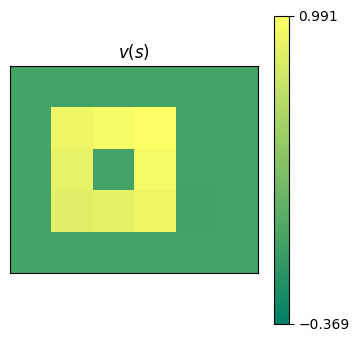

In [43]:
plot_state_value(q, epsilon=0)

In [44]:
def plot_values_with_numbers(values, colormap='pink', vmin=-1, vmax=10):
  ax = plt.gca()
  #im = ax.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax, shape=(20,12))
  im = ax.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  for (j,i),label in np.ndenumerate(np.round(values,4)):
    ax.text(i,j,label,ha='center',va='center')

def plot_state_value_with_numbers(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values_with_numbers(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
  plt.show()
  return v

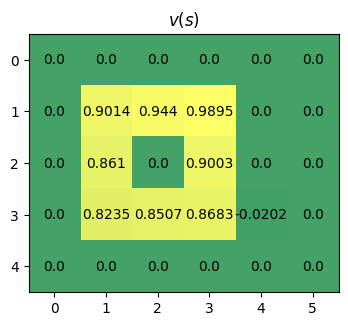

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.901,  0.944,  0.99 ,  0.   ,  0.   ],
       [ 0.   ,  0.861,  0.   ,  0.9  ,  0.   ,  0.   ],
       [ 0.   ,  0.823,  0.851,  0.868, -0.02 ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [45]:
plot_state_value_with_numbers(q, epsilon=epsilon)

In [46]:
AIMA_Fig_16_3_states_values = np.array(
      [[0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.8516, 0.9078, 0.9578 , 0.   , 0.   ],
       [0.   , 0.8016, 0.   , 0.7003, 0.   , 0.   ],
       [0.   , 0.7453, 0.6953, 0.6514, 0.4279, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])
AIMA_Fig_16_3_states_values

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.852, 0.908, 0.958, 0.   , 0.   ],
       [0.   , 0.802, 0.   , 0.7  , 0.   , 0.   ],
       [0.   , 0.745, 0.695, 0.651, 0.428, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])

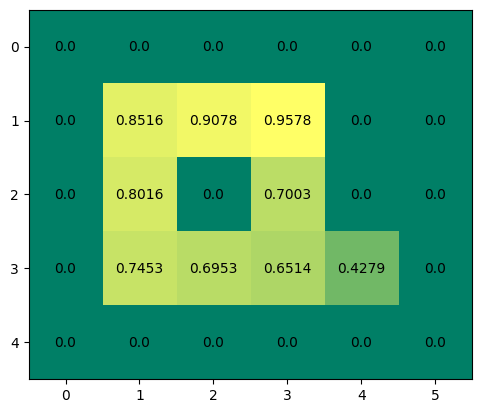

In [47]:
AIMA_vmin = np.min(AIMA_Fig_16_3_states_values)
AIMA_vmax = np.max(AIMA_Fig_16_3_states_values)
plot_values_with_numbers(AIMA_Fig_16_3_states_values, colormap='summer', vmin=AIMA_vmin, vmax=AIMA_vmax)
plt.show()

###Szwabe: Analyze the impact of epsilon on the learning stability and the quality of the final policy.

AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...


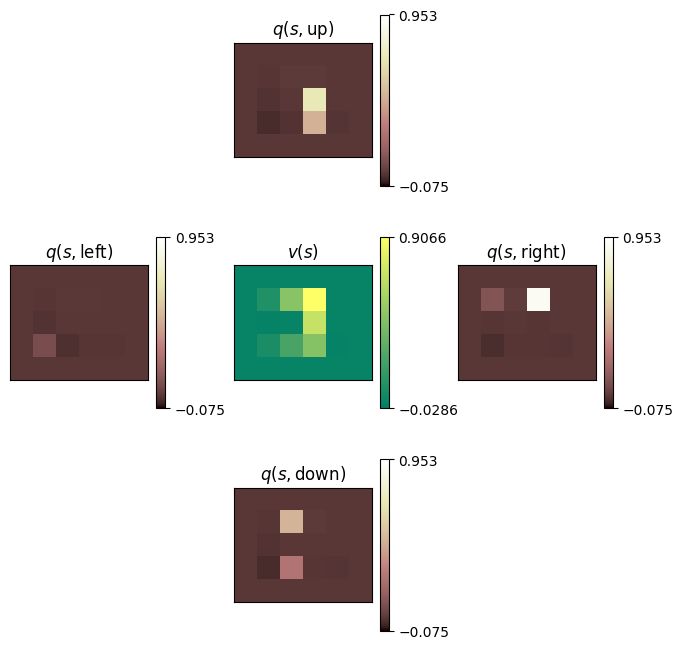

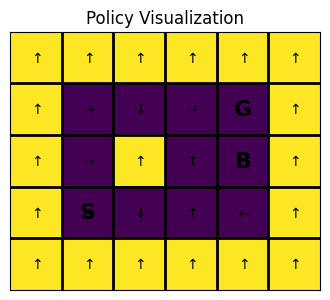

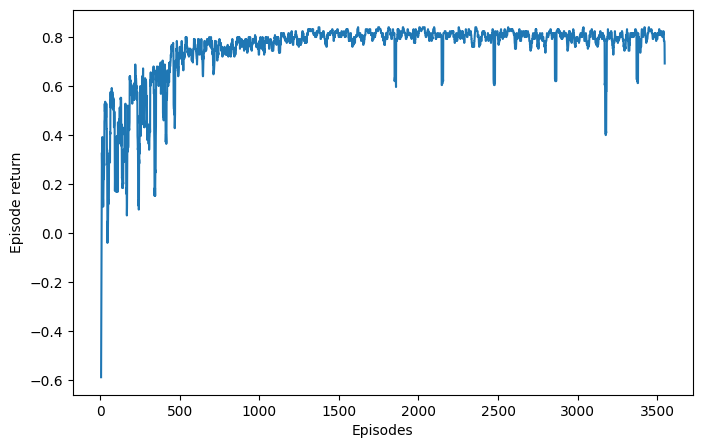

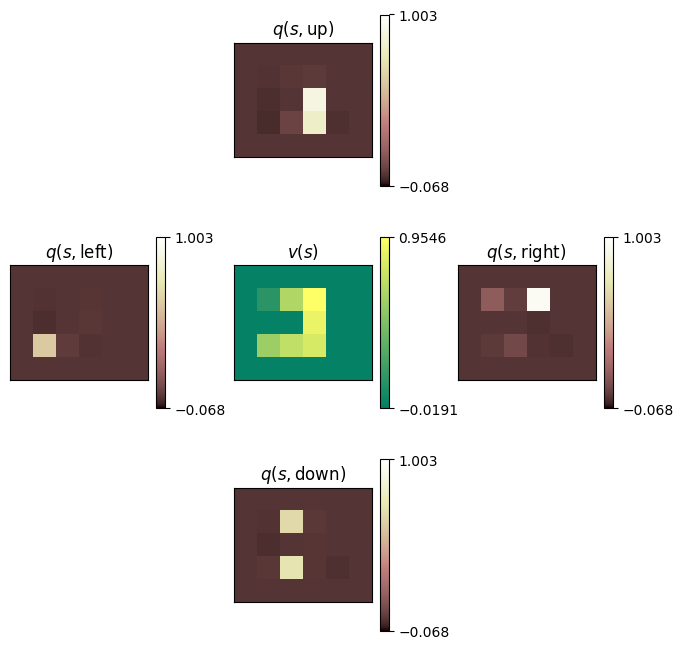

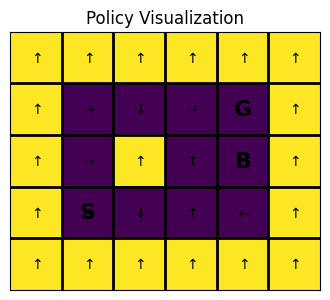

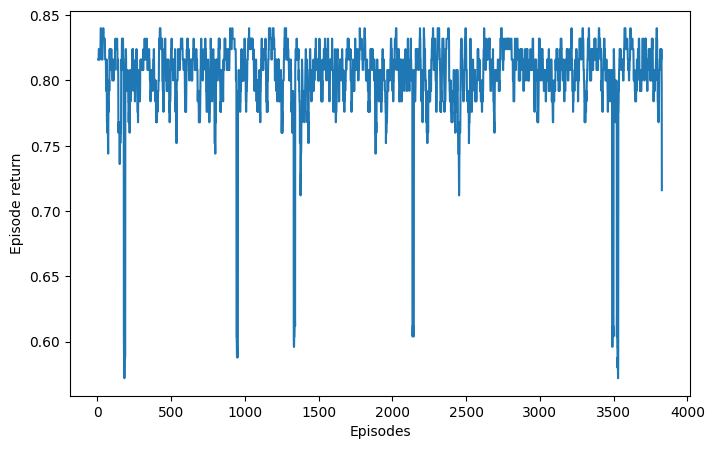

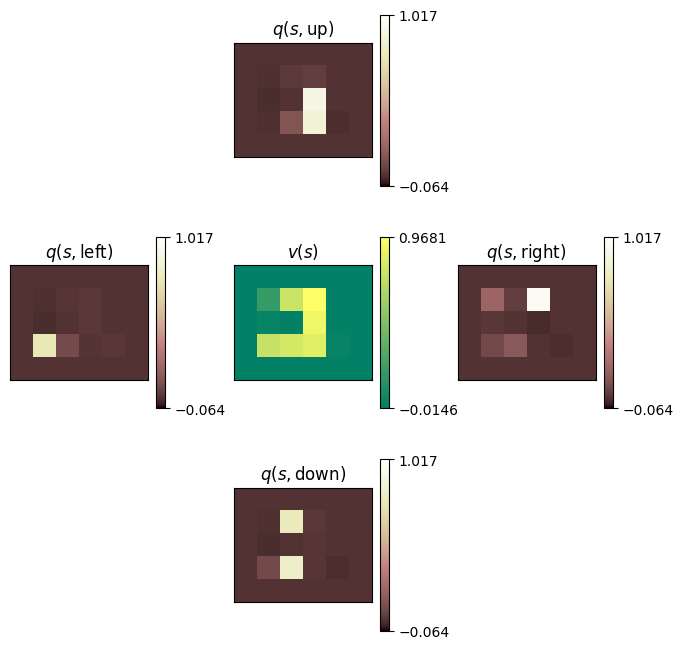

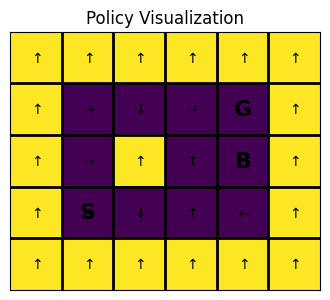

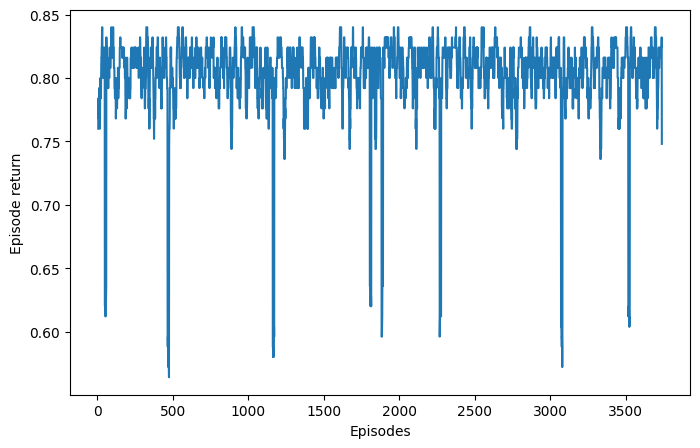

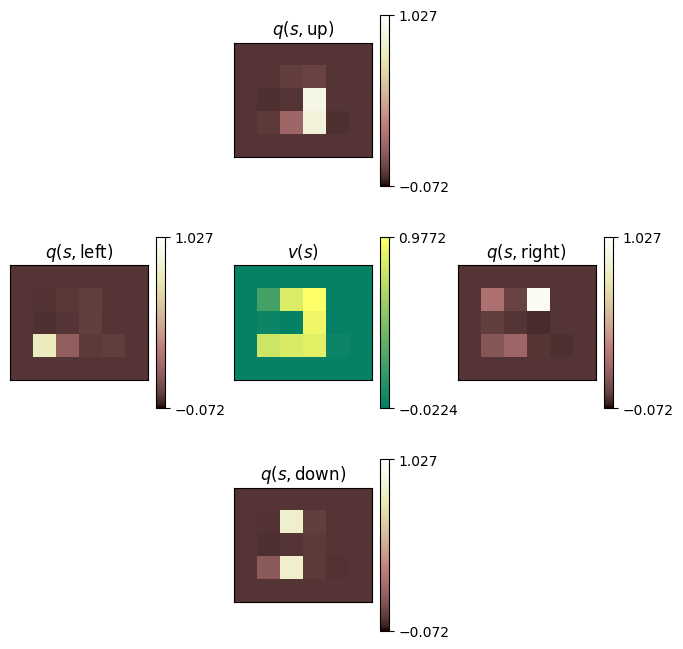

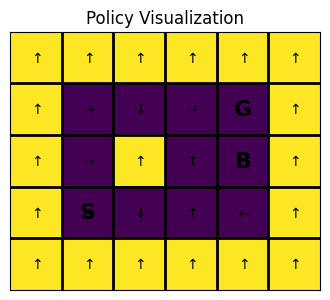

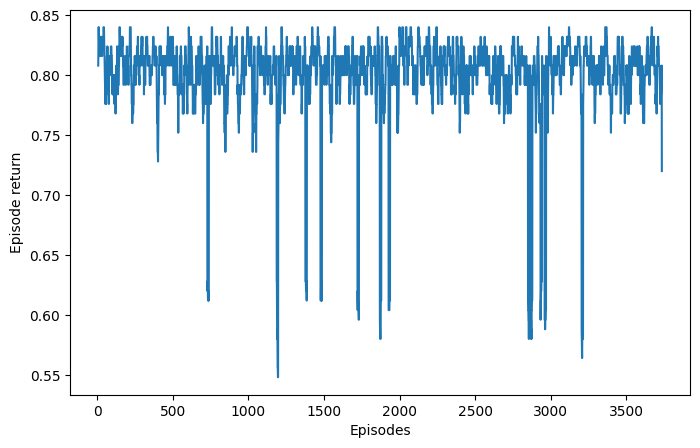

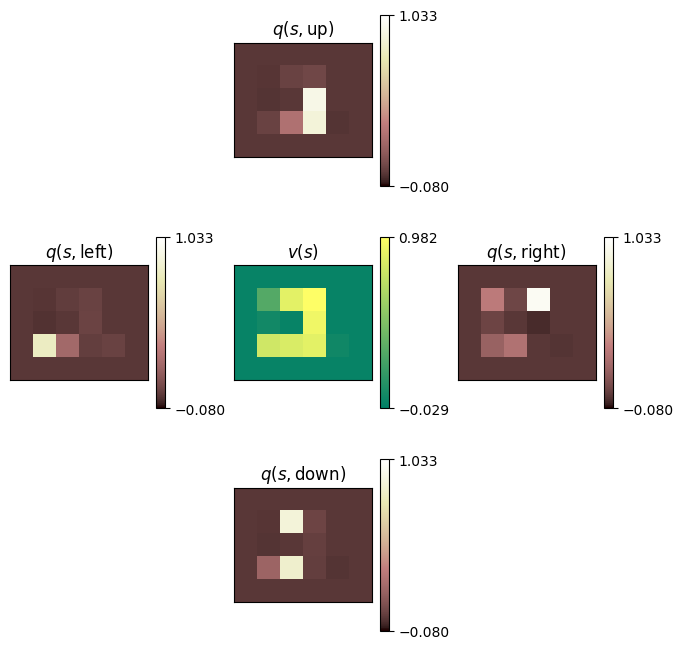

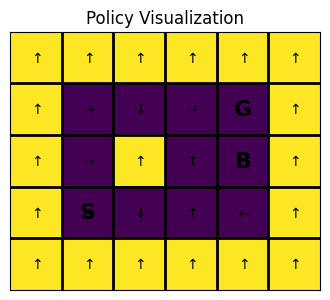

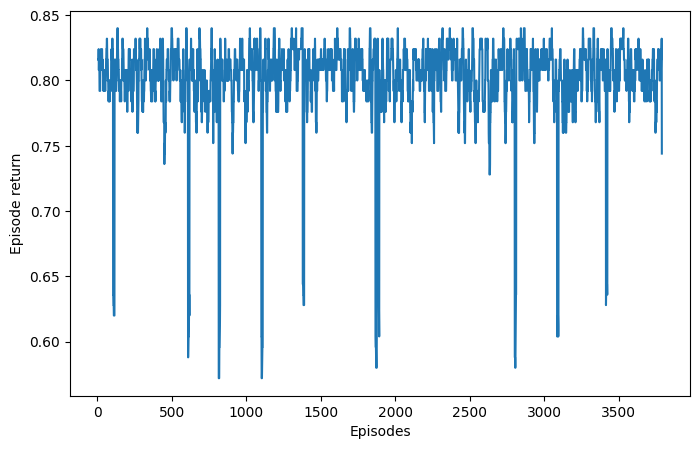

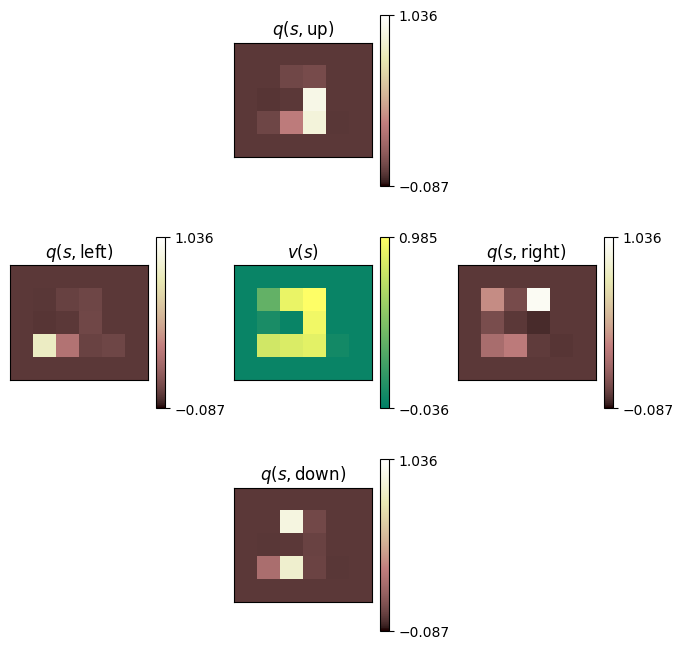

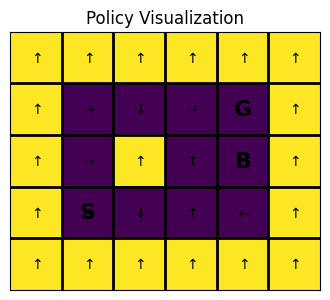

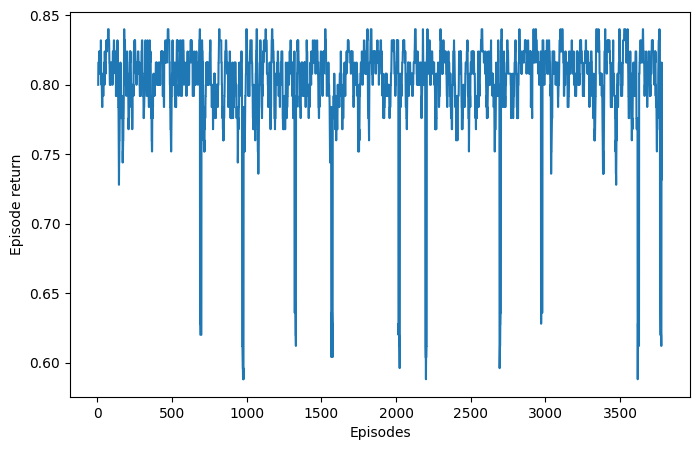

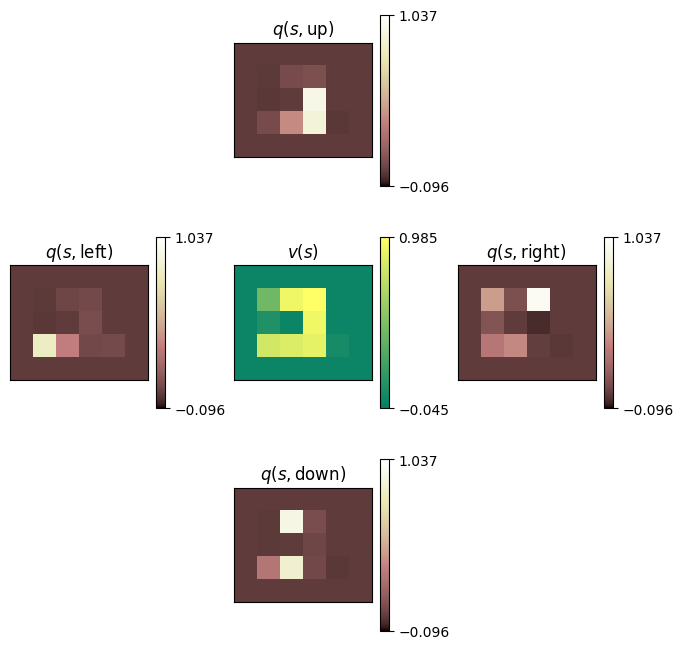

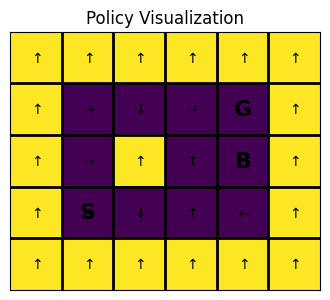

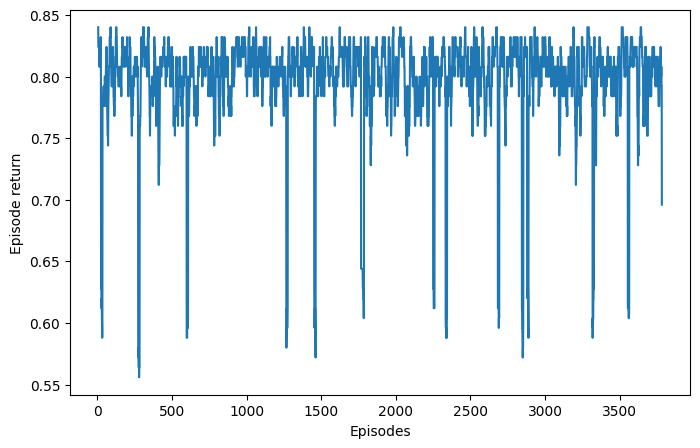

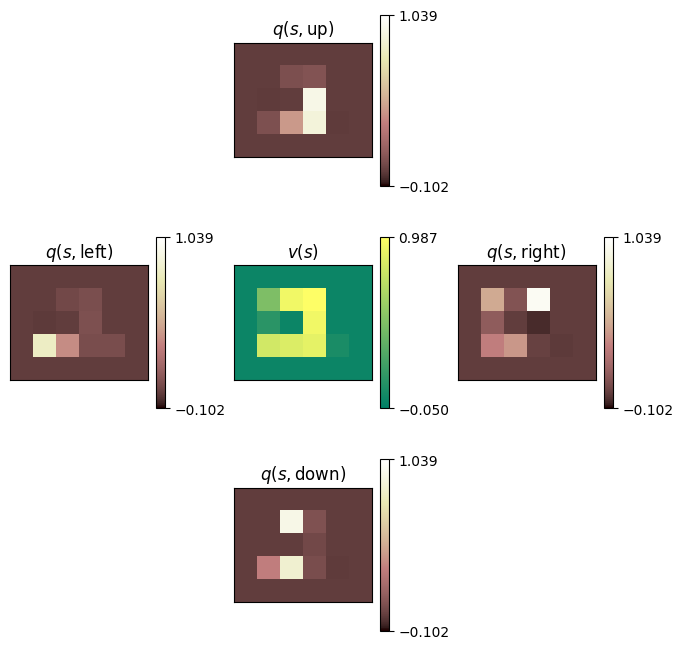

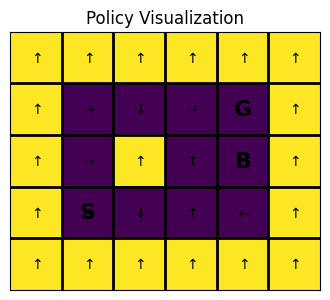

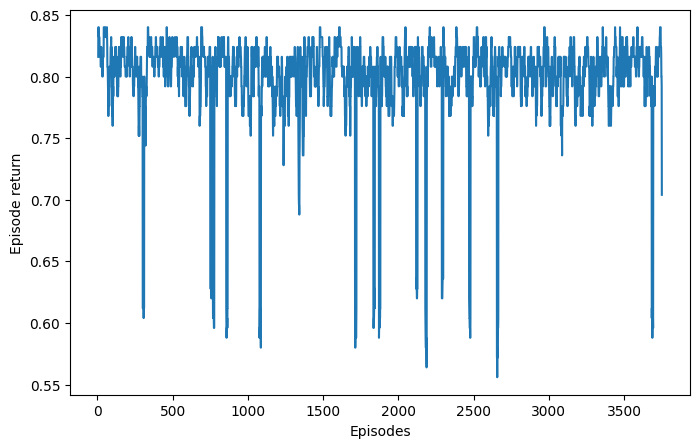

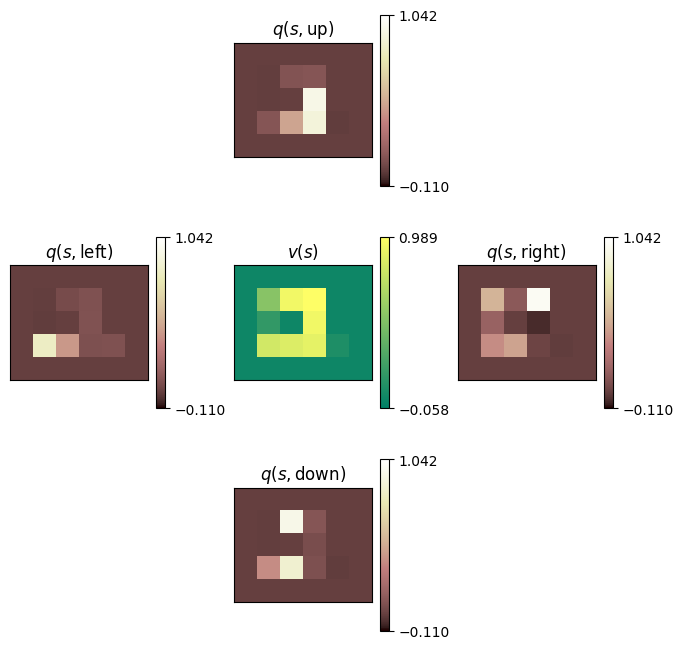

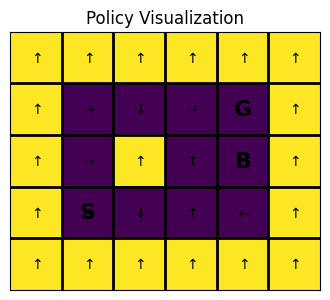

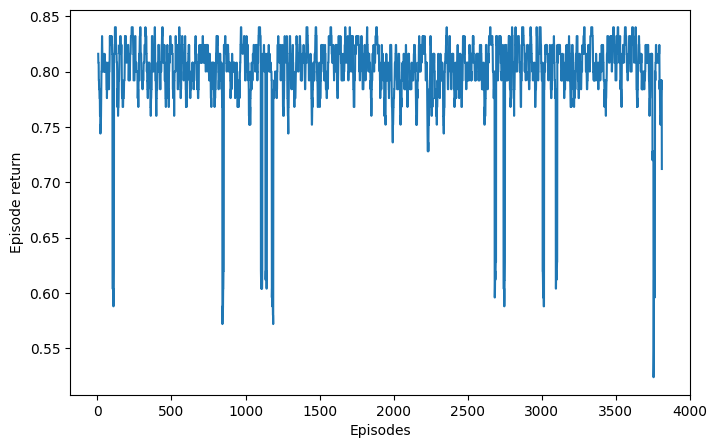

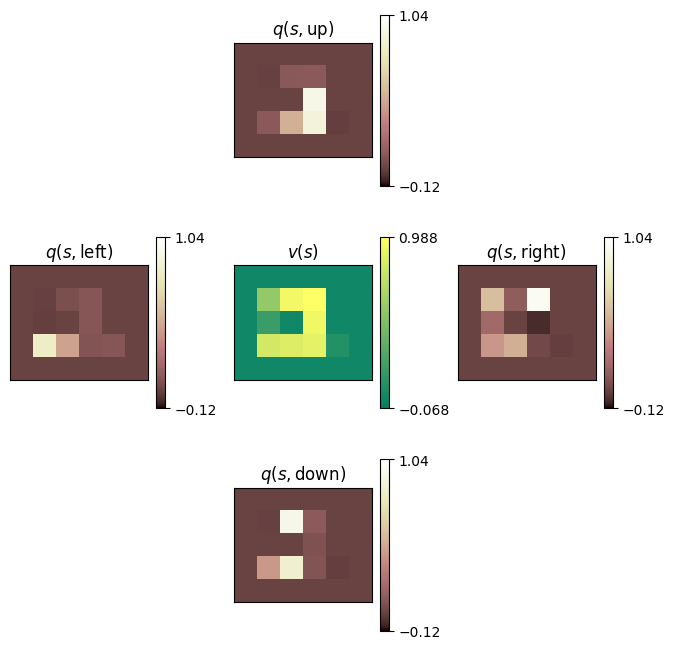

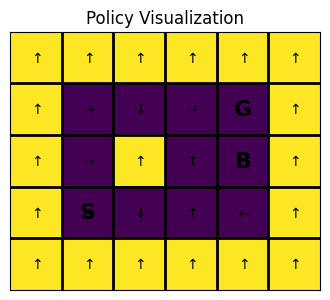

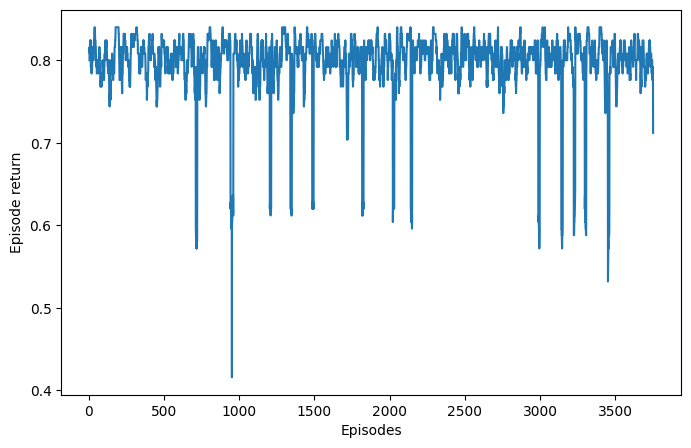

In [48]:
epsilon = 0.01  #@param {type:"number"}
num_steps = 1e5  #@param {type:"number"}
num_steps = int(num_steps)

num_episodes = 8000
num_episodes = int(num_episodes)

# environment
grid = build_gridworld_task(task='AIMA')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.001)

for i in range(10):
  # run experiment and get the value functions from agent
  returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

  # get the q-values
  q = agent.q_values.reshape(grid.layout.shape + (4,))

  # visualize value functions
  print('AFTER {:,} STEPS ...'.format(num_steps))
  plot_action_values(q, epsilon=epsilon)

  # visualise the greedy policy
  grid.plot_greedy_policy(q)

  #@title Visualise the training curve { form-width: "30%" }

  # Compute rolling average over returns
  returns_avg = pd.Series(returns).rolling(10, center=True).mean()

  plt.figure(figsize=(8, 5))
  plt.plot(range(len(returns)), returns_avg)
  plt.xlabel('Episodes')
  plt.ylabel('Episode return');

AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...


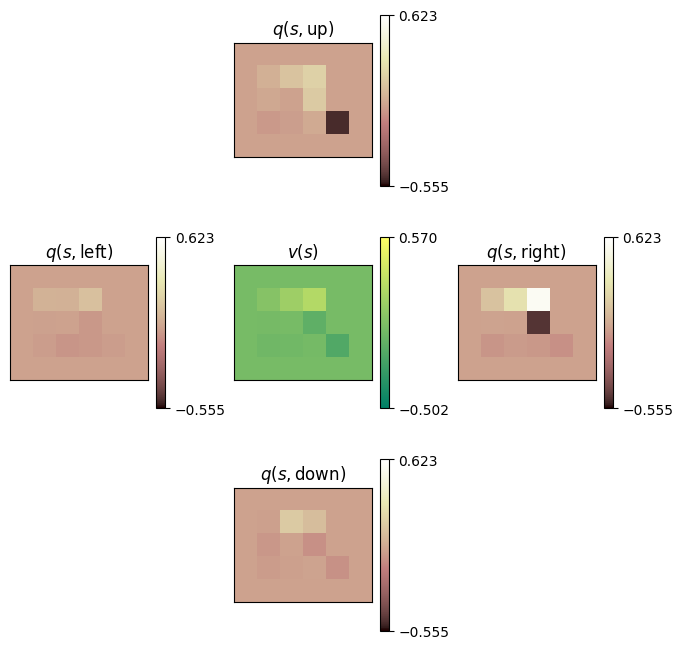

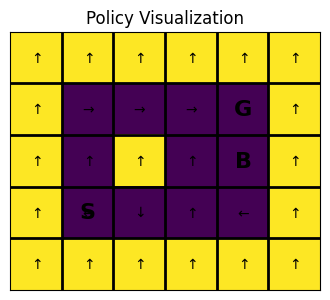

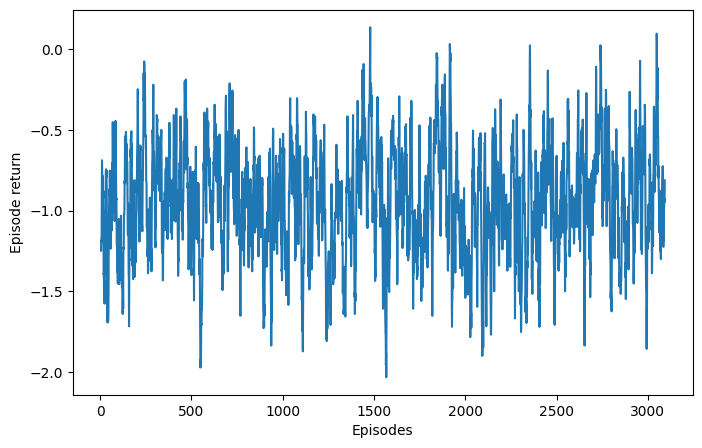

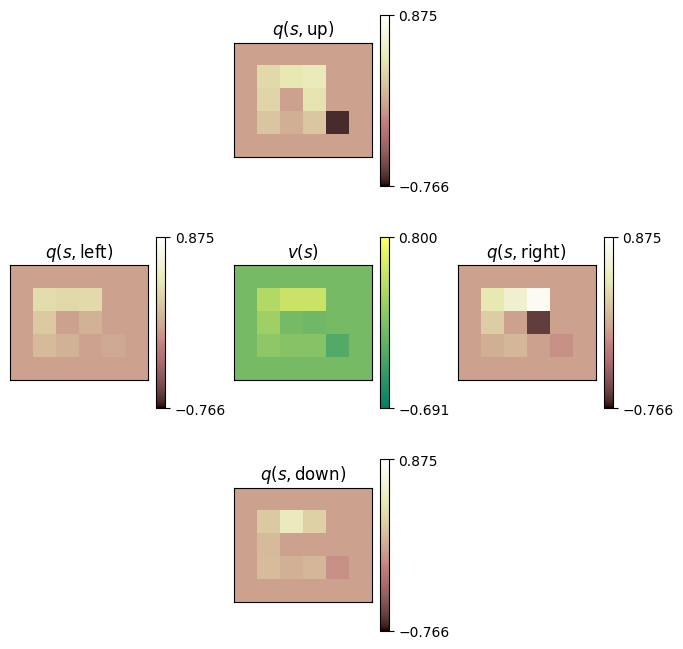

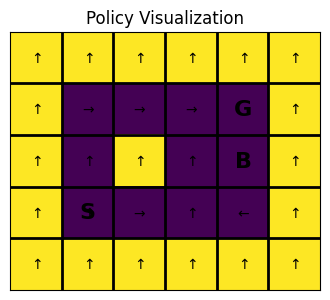

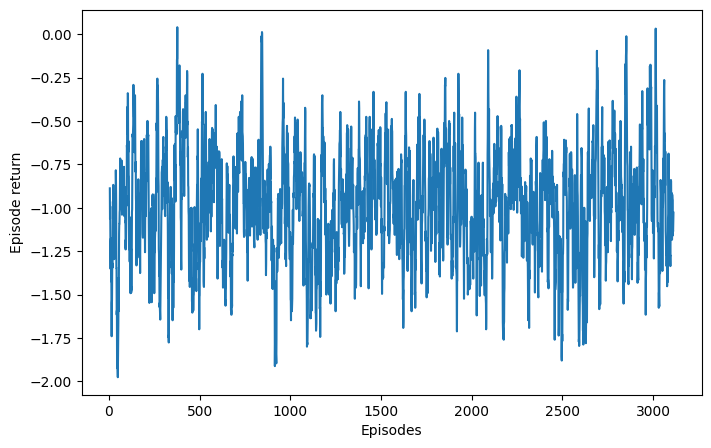

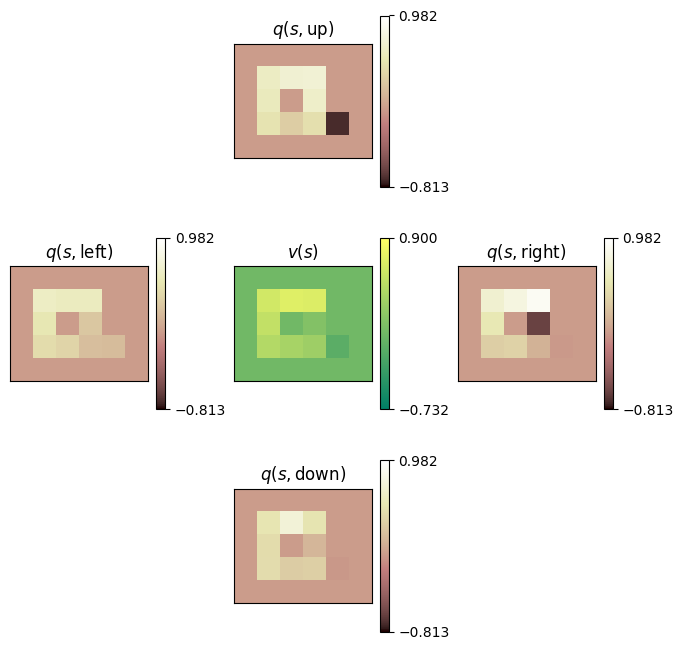

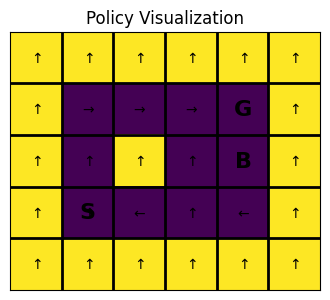

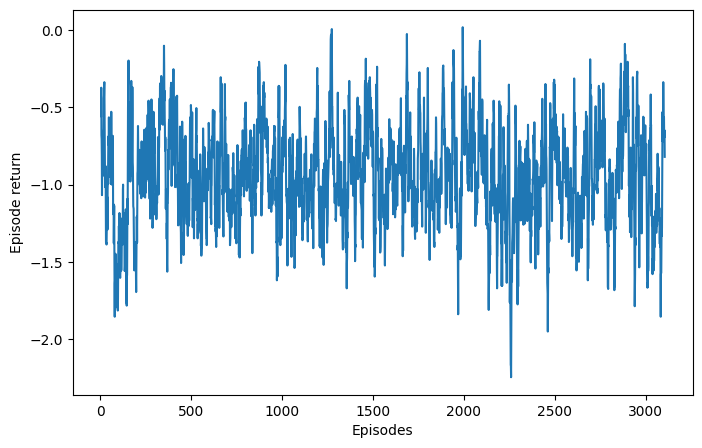

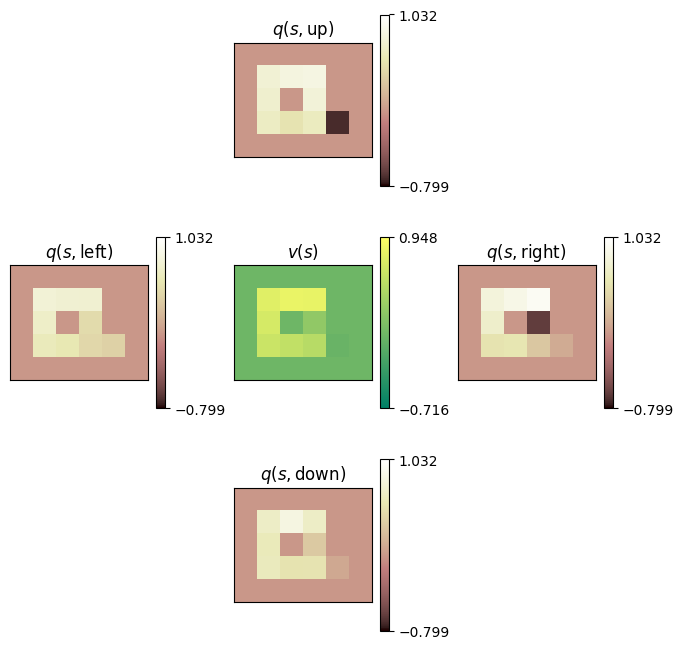

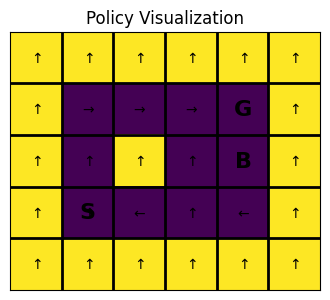

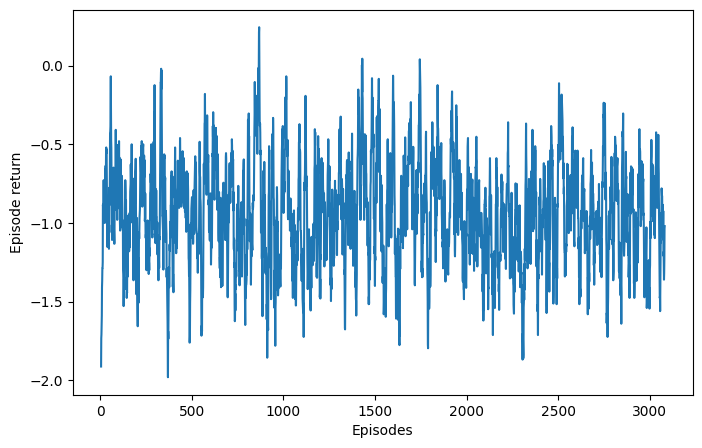

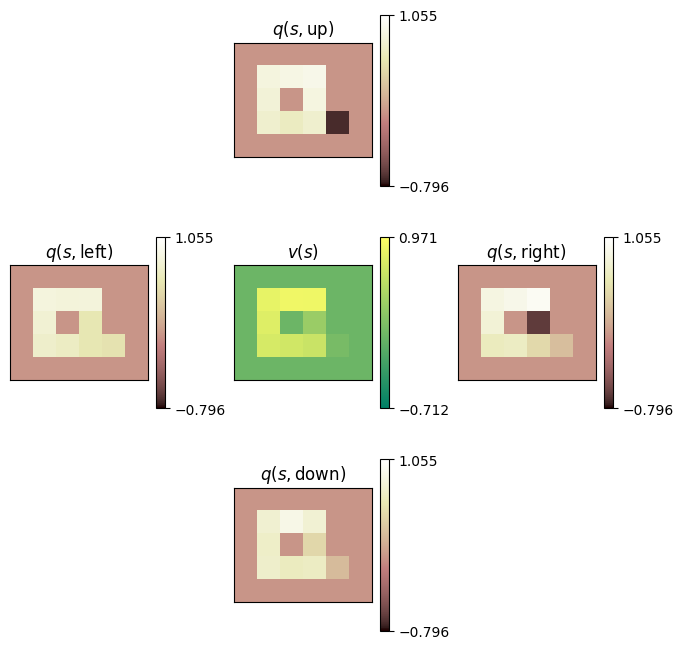

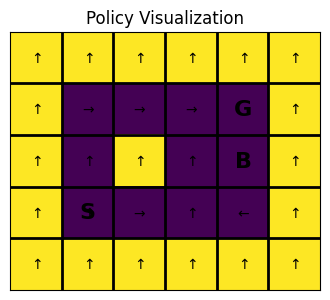

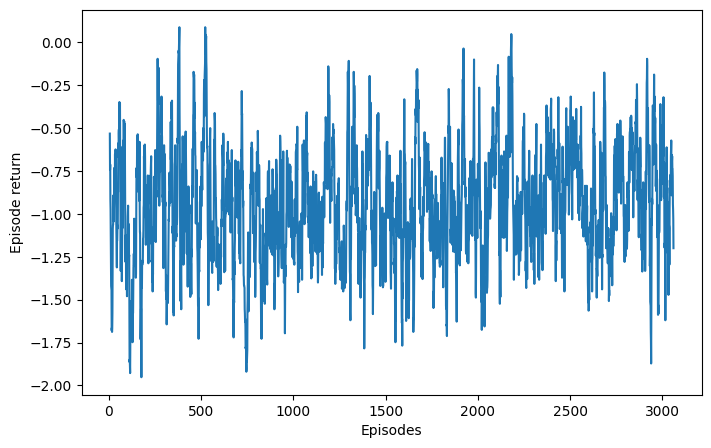

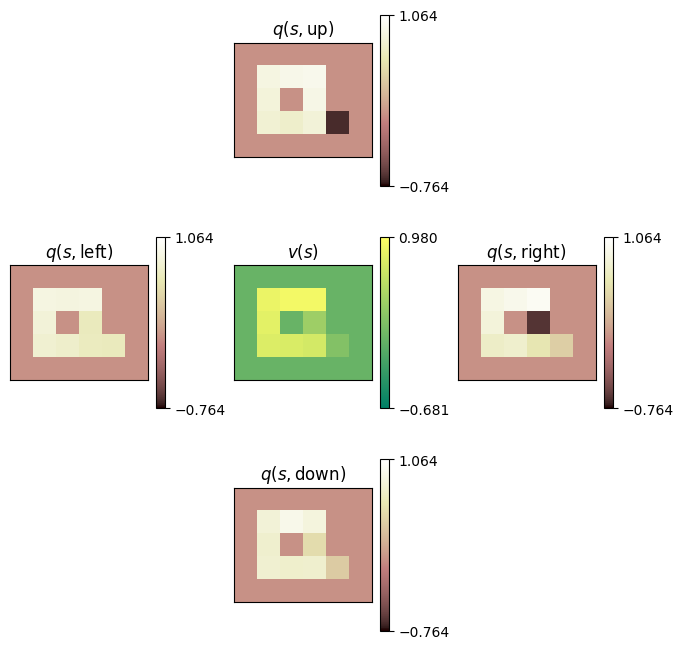

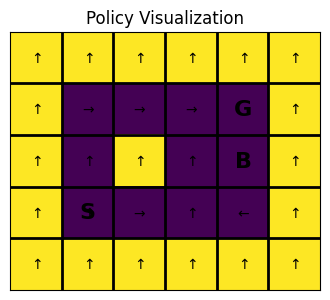

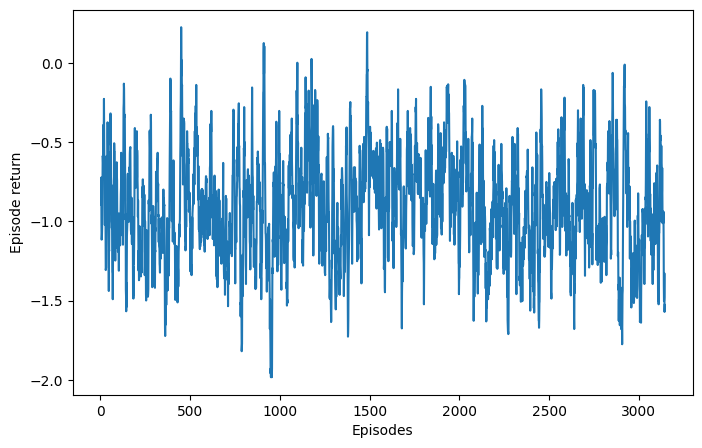

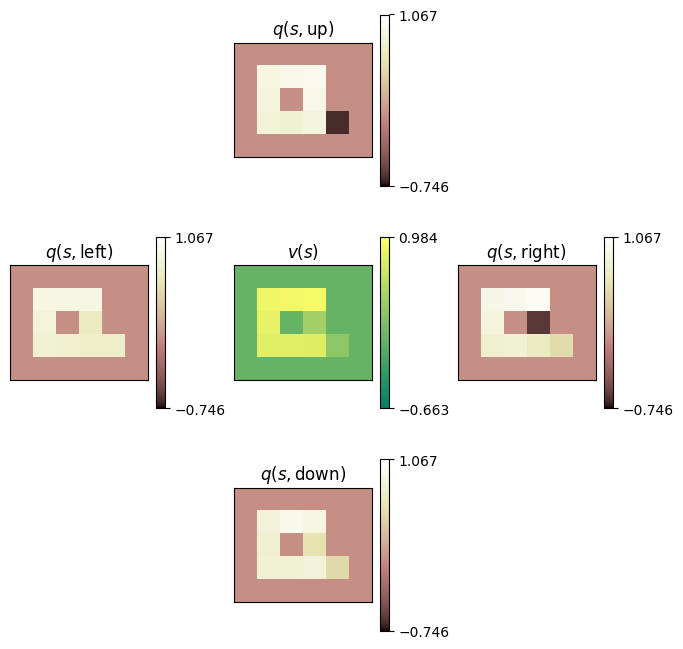

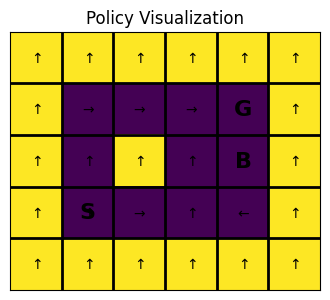

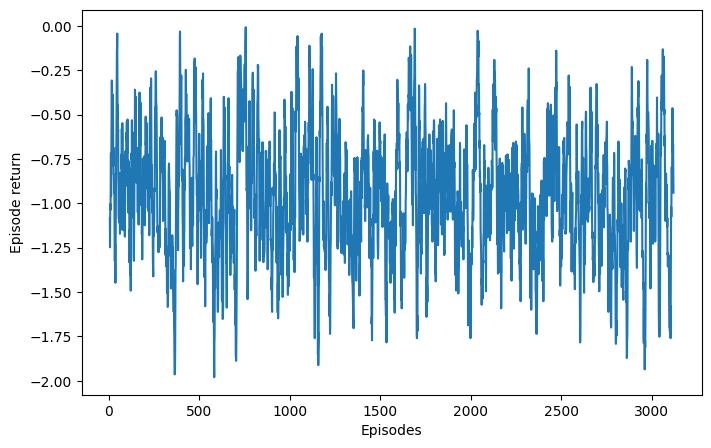

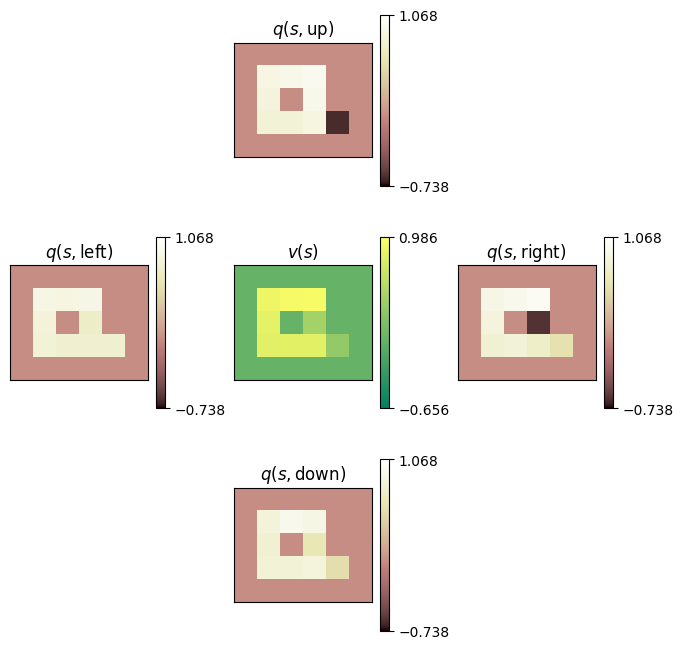

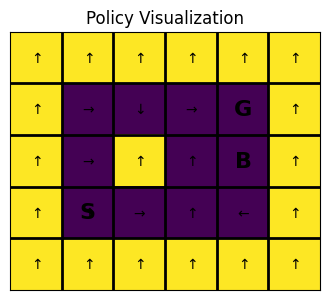

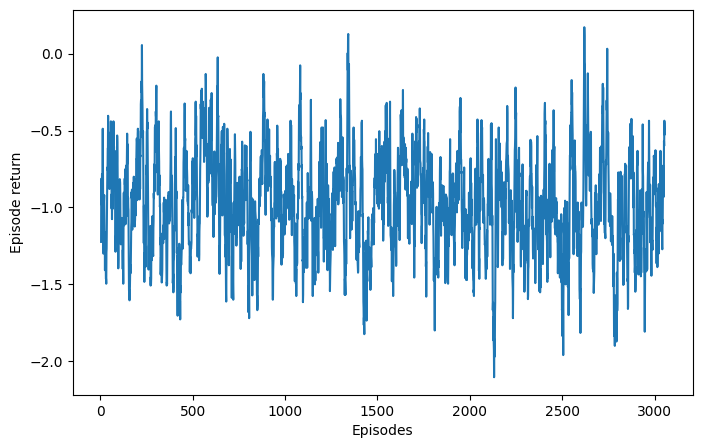

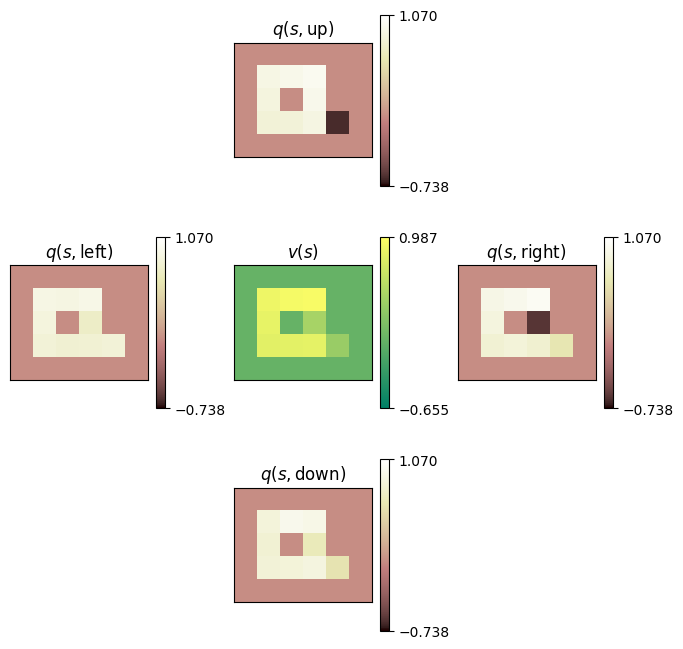

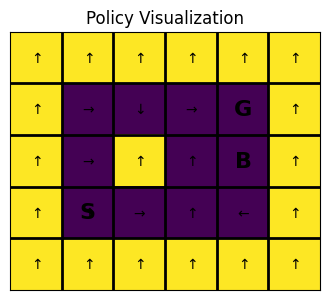

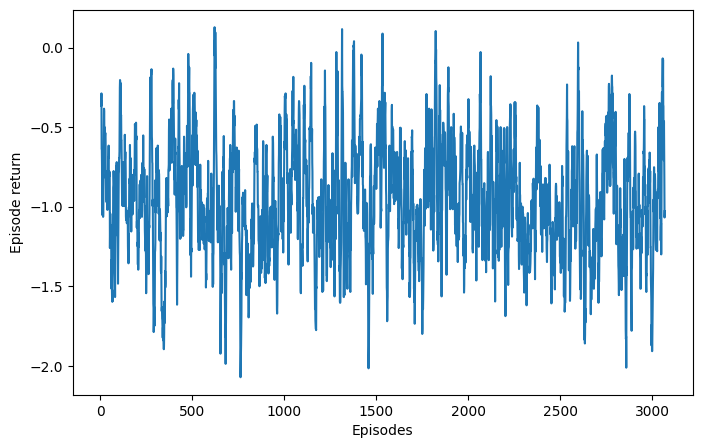

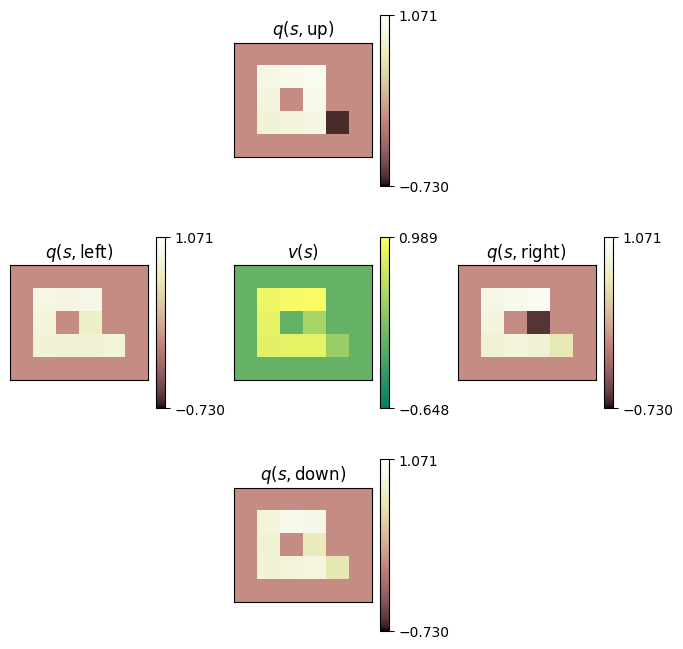

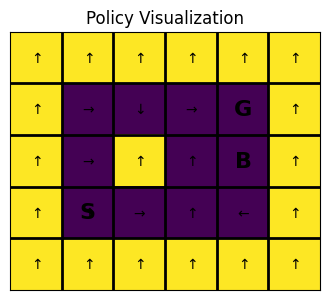

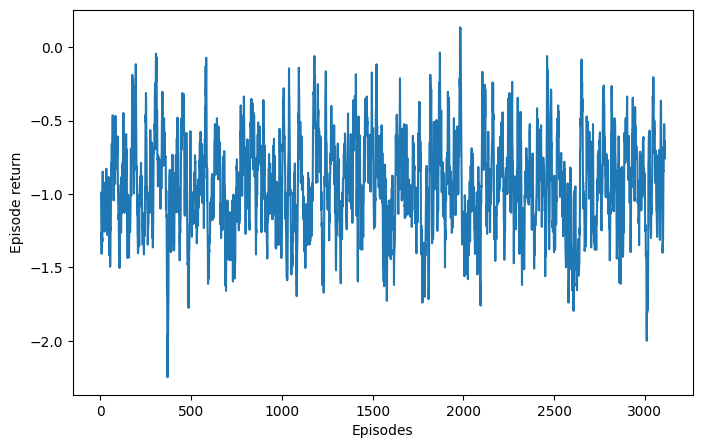

In [49]:
epsilon = 1.00  #@param {type:"number"}
num_steps = 1e5  #@param {type:"number"}
num_steps = int(num_steps)

num_episodes = 8000
num_episodes = int(num_episodes)

# environment
grid = build_gridworld_task(task='AIMA')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.001)

for i in range(10):
  # run experiment and get the value functions from agent
  returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

  # get the q-values
  q = agent.q_values.reshape(grid.layout.shape + (4,))

  # visualize value functions
  print('AFTER {:,} STEPS ...'.format(num_steps))
  plot_action_values(q, epsilon=epsilon)

  # visualise the greedy policy
  grid.plot_greedy_policy(q)

  #@title Visualise the training curve { form-width: "30%" }

  # Compute rolling average over returns
  returns_avg = pd.Series(returns).rolling(10, center=True).mean()

  plt.figure(figsize=(8, 5))
  plt.plot(range(len(returns)), returns_avg)
  plt.xlabel('Episodes')
  plt.ylabel('Episode return');

### Nowak: Impact of Epsilon on Learning Stability and Policy Quality

- **Low epsilon (e.g., 0.01)** results in nearly greedy behavior:
  - Agent quickly exploits current knowledge.
  - Leads to high policy quality if initial learning is stable.
  - Risk: poor exploration → may converge to suboptimal policy.

- **High epsilon (e.g., 1.0)** means nearly full random exploration:
  - Agent ignores learned Q-values almost entirely.
  - Ensures full coverage of state space but prevents convergence.
  - Policy remains noisy and unstable over time.

- **Stability**:
  - Learning becomes less noisy with low epsilon.
  - Fewer random actions → more stable Q-values.
  - But policy may overfit early experiences.

- **Final Policy**:
  - If agent explores enough early on, low epsilon yields clean, near-optimal deterministic policy.
  - Otherwise, quality depends heavily on lucky early exploration.

- **Conclusion**:
  - Low epsilon improves stability but must be balanced with sufficient exploration.
  - A decaying epsilon schedule is often used in practice to combine early exploration with late-stage exploitation.


###Szwabe: Experiment with different values of num_steps for the promising values of epsilon. Is there a trade off between epsilon and num_steps?  

AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...


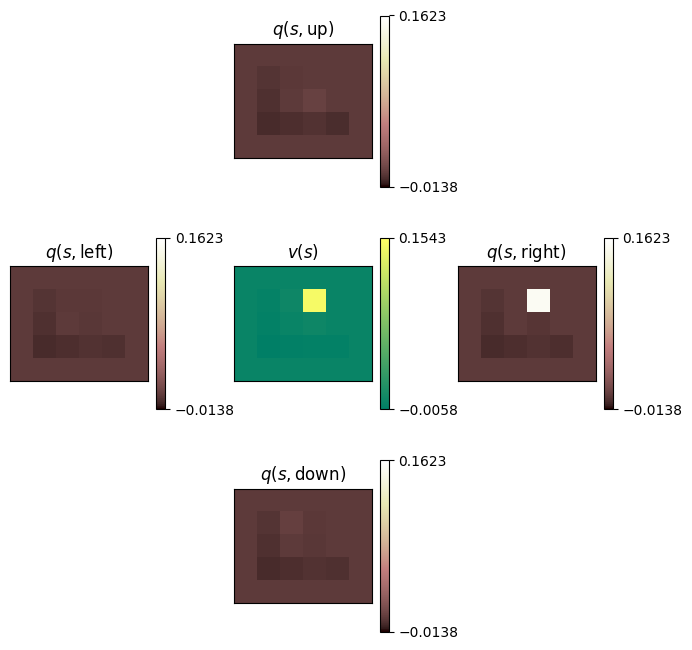

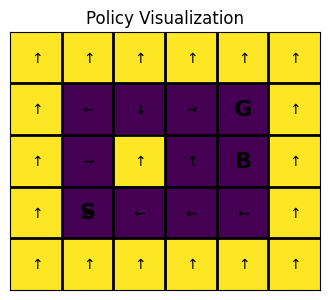

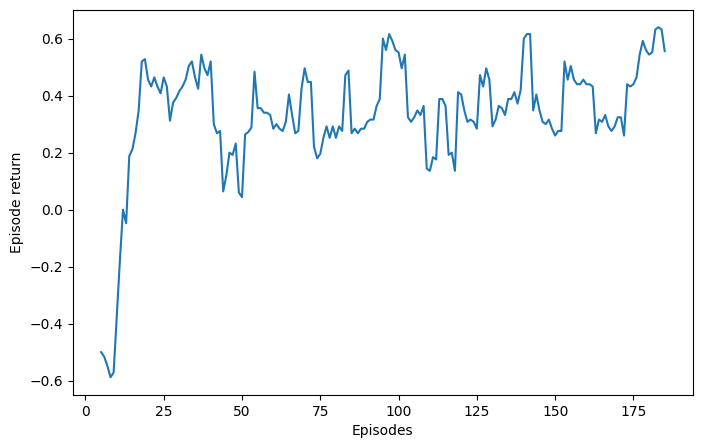

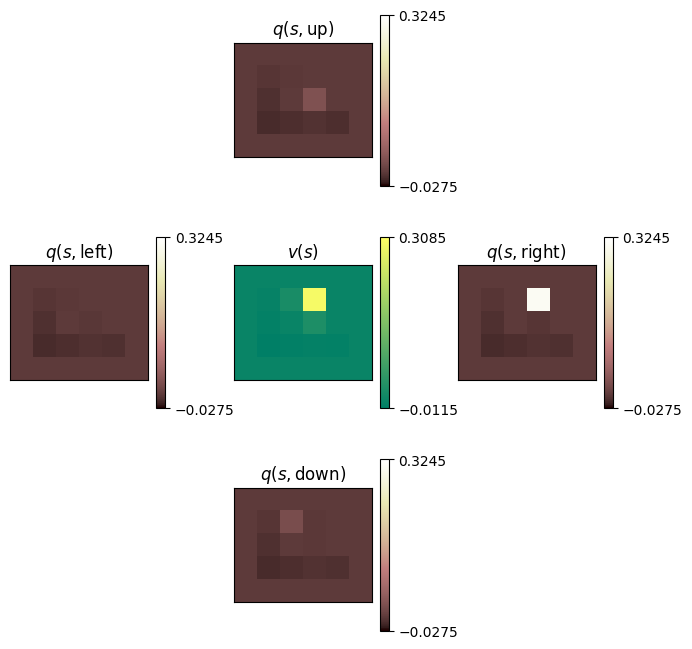

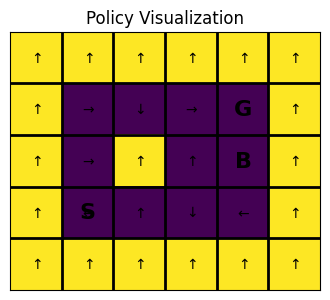

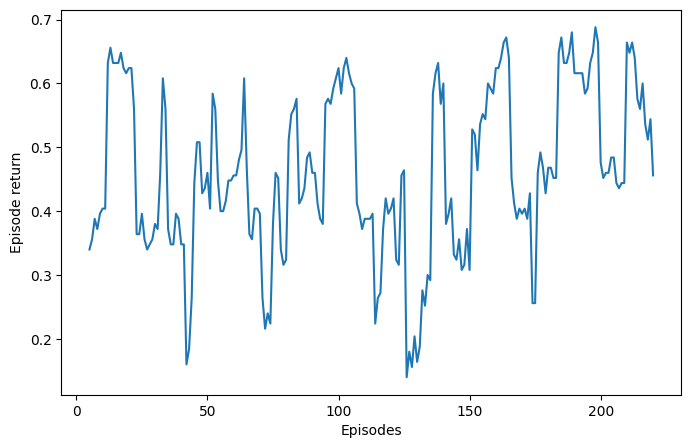

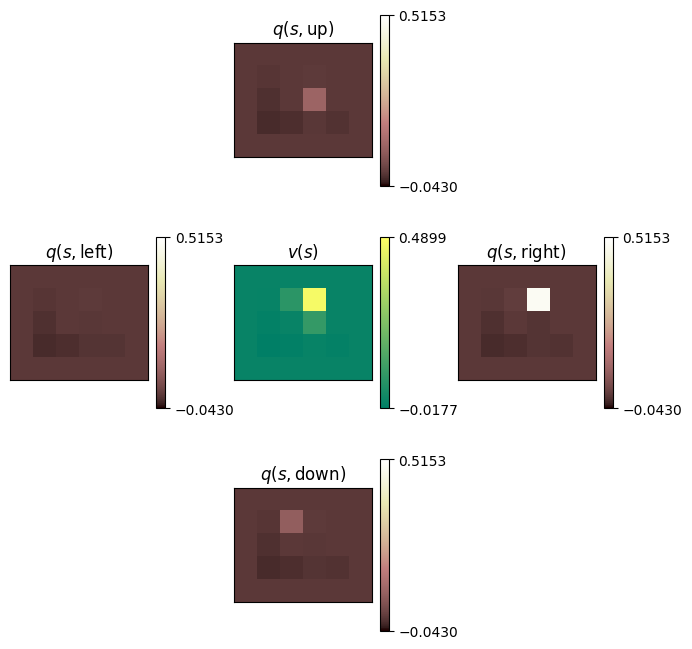

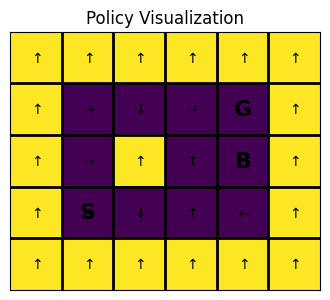

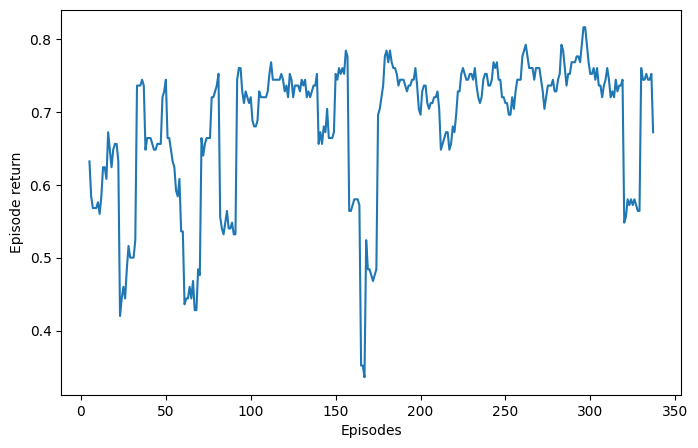

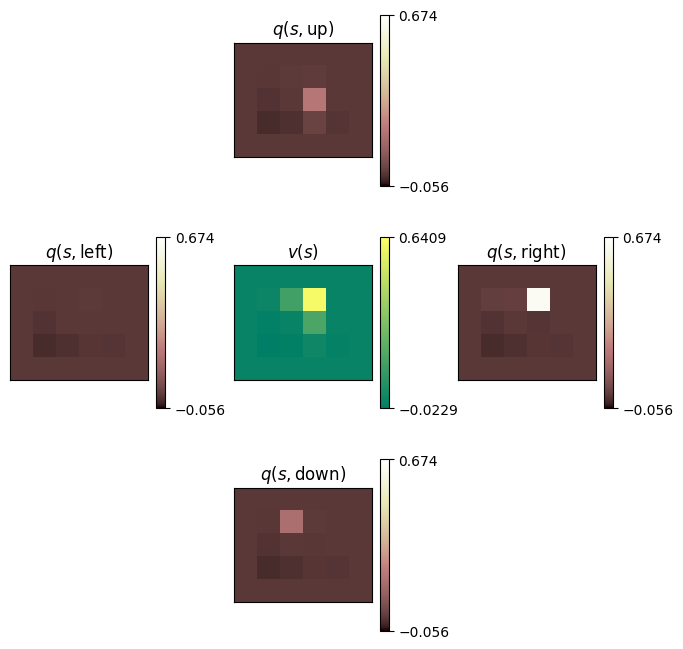

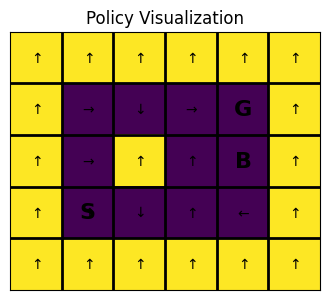

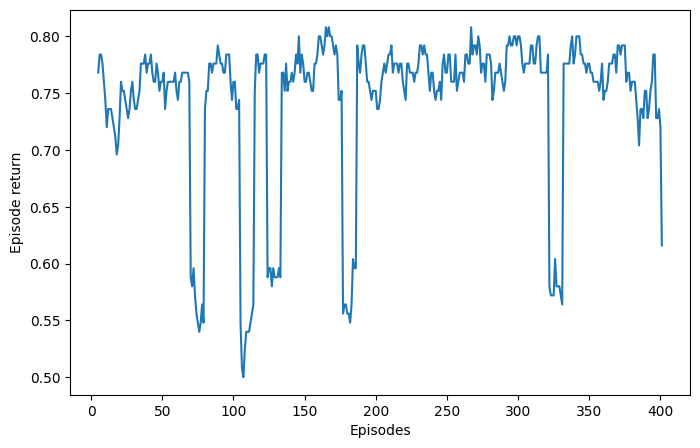

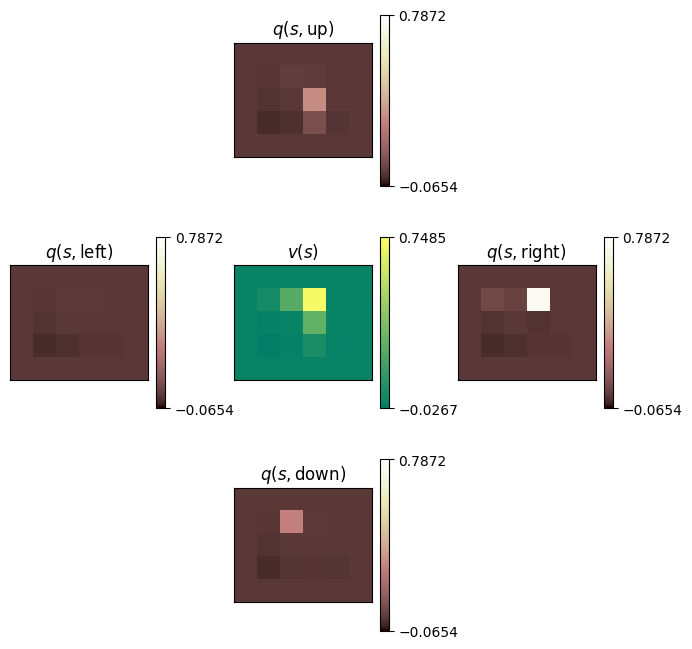

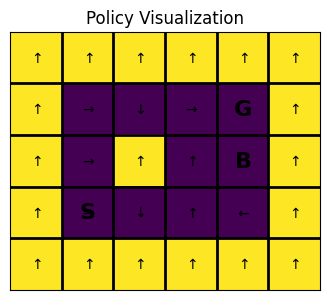

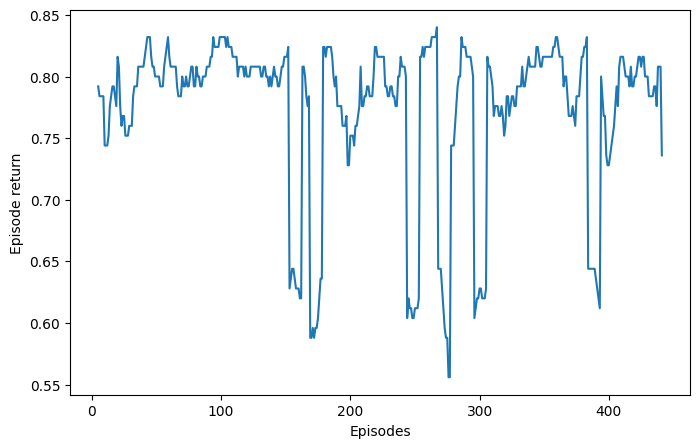

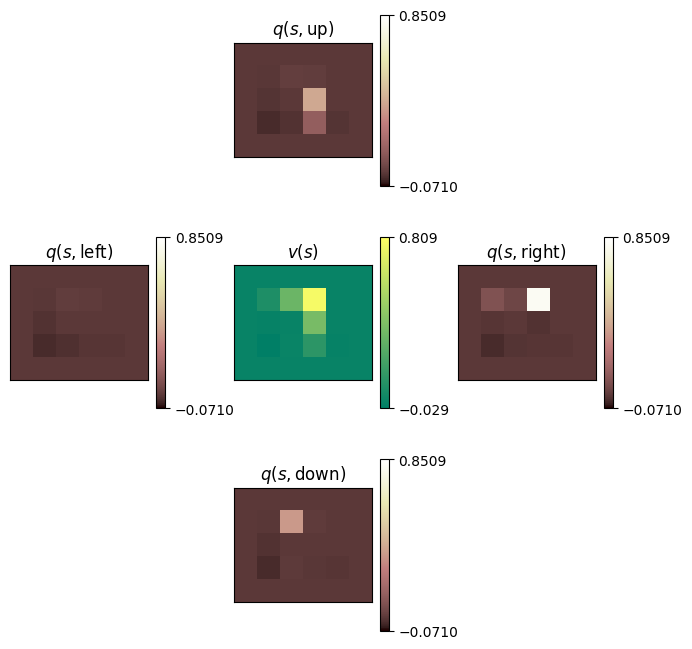

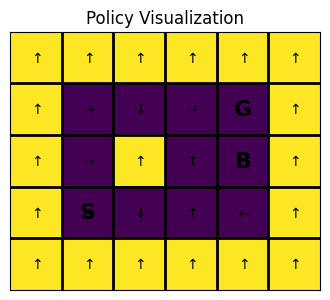

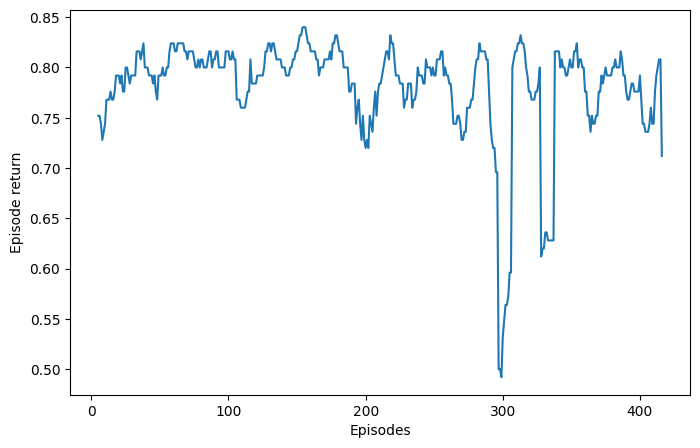

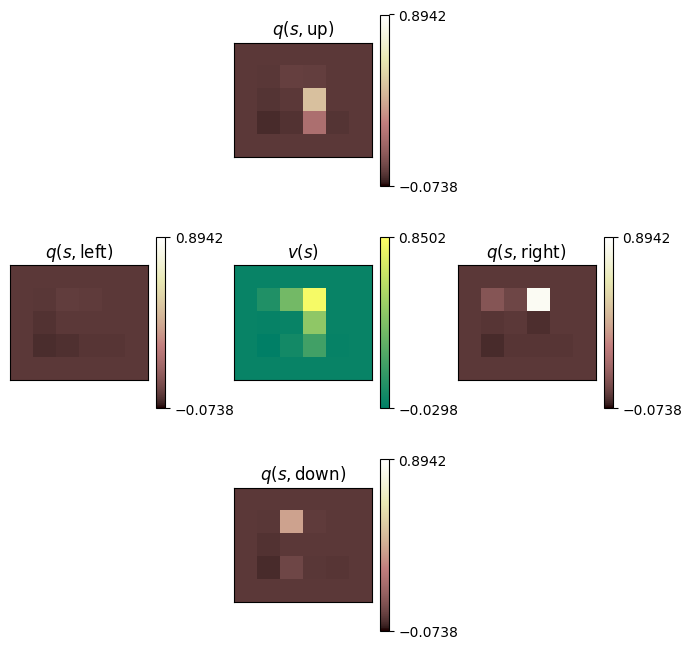

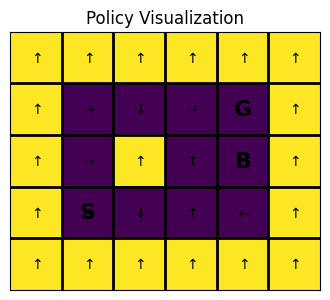

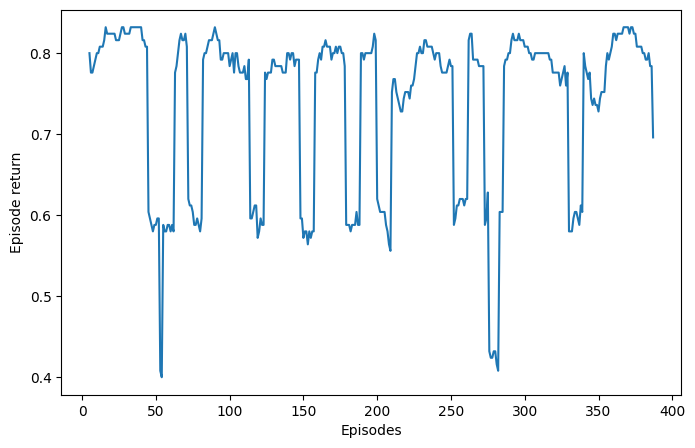

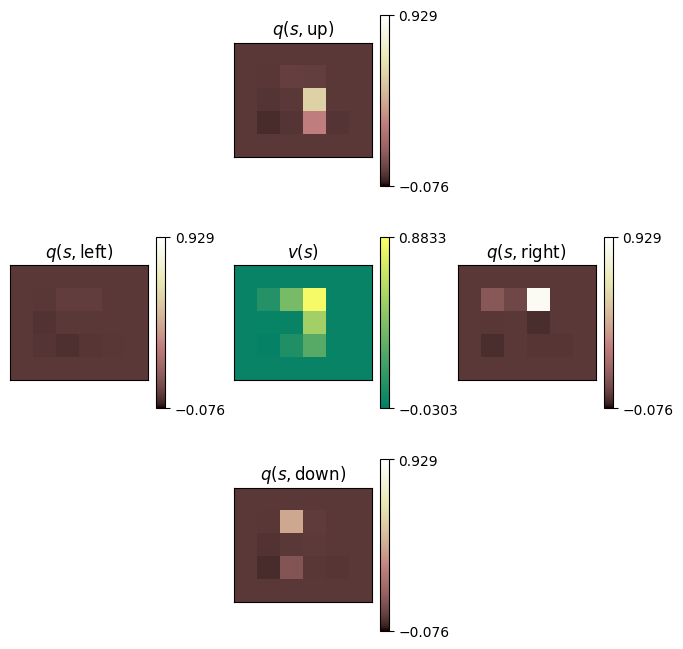

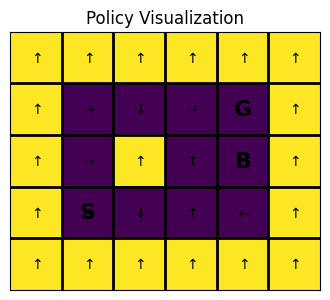

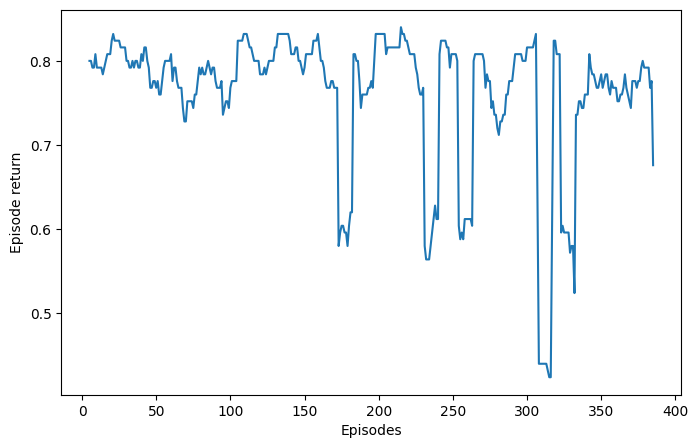

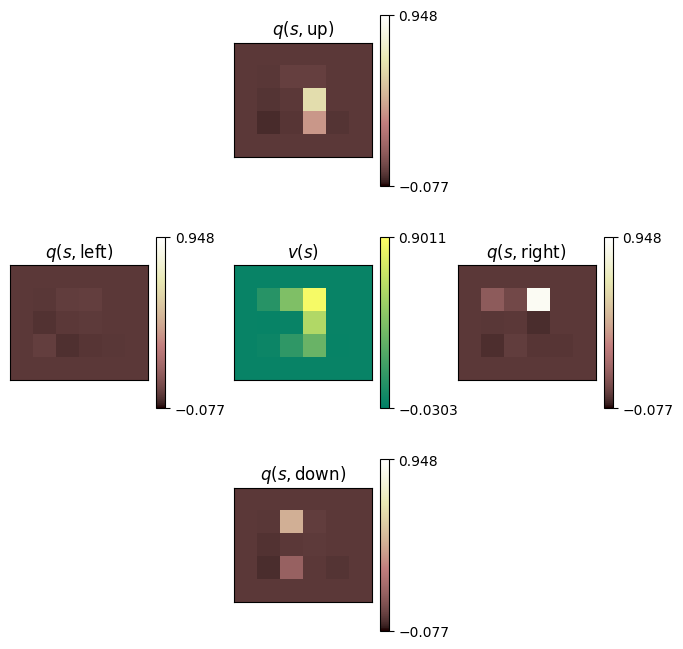

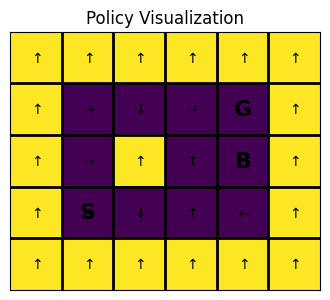

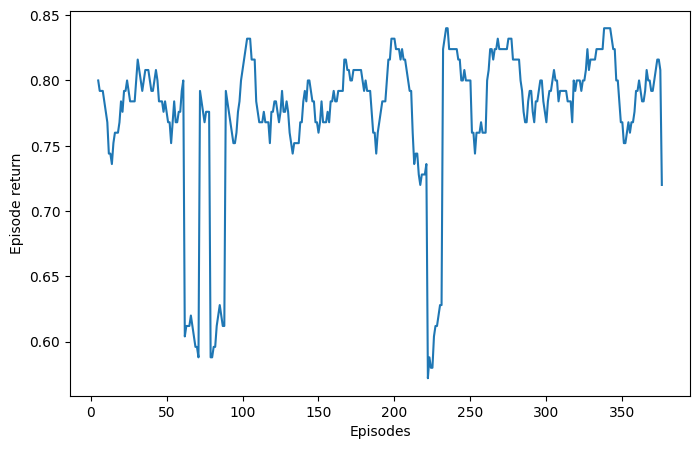

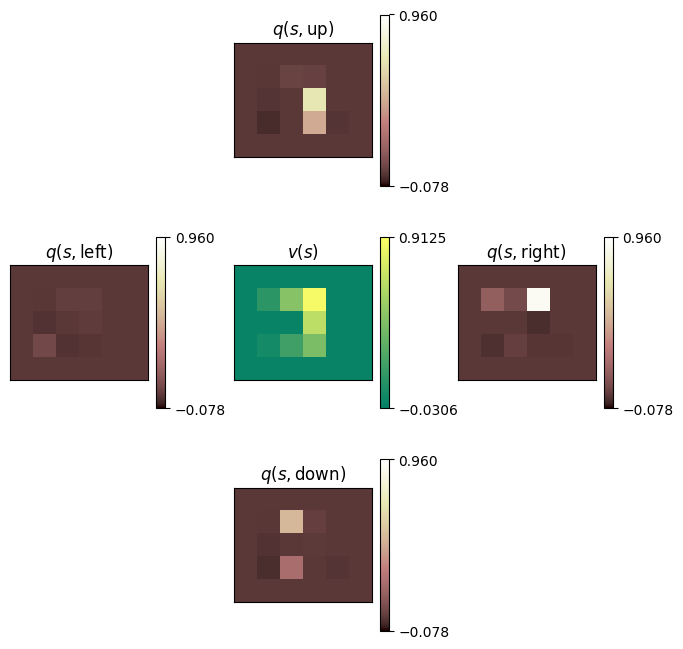

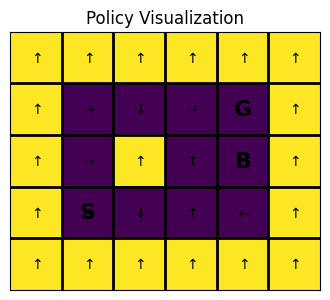

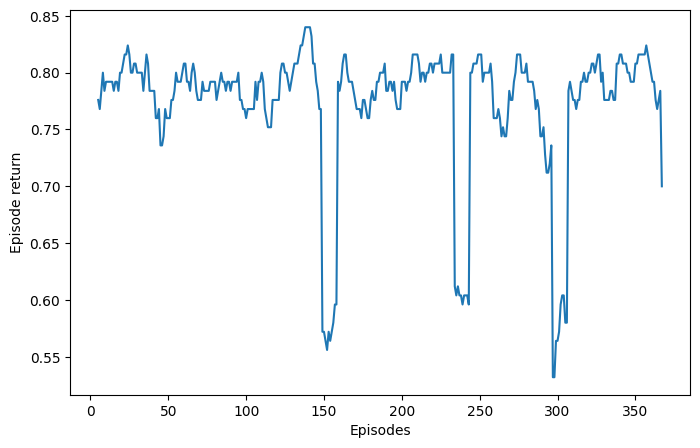

In [50]:
epsilon = 0.05  #@param {type:"number"}
num_steps = 1e4  #@param {type:"number"}
num_steps = int(num_steps)

num_episodes = 8000
num_episodes = int(num_episodes)

# environment
grid = build_gridworld_task(task='AIMA')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# agent
agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.001)

for i in range(10):
  # run experiment and get the value functions from agent
  returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

  # get the q-values
  q = agent.q_values.reshape(grid.layout.shape + (4,))

  # visualize value functions
  print('AFTER {:,} STEPS ...'.format(num_steps))
  plot_action_values(q, epsilon=epsilon)

  # visualise the greedy policy
  grid.plot_greedy_policy(q)

  #@title Visualise the training curve { form-width: "30%" }

  # Compute rolling average over returns
  returns_avg = pd.Series(returns).rolling(10, center=True).mean()

  plt.figure(figsize=(8, 5))
  plt.plot(range(len(returns)), returns_avg)
  plt.xlabel('Episodes')
  plt.ylabel('Episode return');

### Nowak: Different Values of `num_steps`

- **Observation**:
  - For a fixed `epsilon = 0.05`, increasing `num_steps` leads to better policy convergence.
  - With low `num_steps` (e.g., 10⁴), the agent may not explore enough to fully learn the environment dynamics.

- **Trade-off**:
  - **Low epsilon** (exploitation-focused) requires **more steps** to discover good actions through limited exploration.
  - **Higher epsilon** agents explore more per step, so fewer steps may still give decent learning — but risk less stable policies.

- **Conclusion**:
  - Yes, there is a trade-off between `epsilon` and `num_steps`.
  - **Lower epsilon needs more steps** to ensure sufficient exploration through time.
  - In practice: use **decaying epsilon** or schedule `num_steps` based on how much exploration your epsilon allows.


## Experience Replay buffer and its impact of the Q-learning agent performance

An important property of off-policy methods like $\color{green}Q$-learning is that they involve two policies: one for exploration and one that is being optimized (via the $\color{green}Q$-function updates). This means that we can generate data from the **behavior** policy and insert that data into some form of data storage---usually referred to as **replay**.

In order to optimize the $\color{green}Q$-function we can then sample data from the replay <font color='purple'>**dataset**</font> and use that data to perform an update. An illustration of this learning loop is shown below.

<center><img src="https://drive.google.com/uc?id=1ivTQBHWkYi_J9vWwXFd2sSWg5f2TB5T-" width="400" /></center>

A simple replay buffer may be as simple as a Python list containing transition data. In more complicated scenarios we might want to have a more performance-tuned variant, we might have to be more concerned about how large replay is and what to do when its full, and we might want to sample from replay in different ways. But a simple python list can go a surprisingly long way.

Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions using the behaviour policy
* accumulate all observed transitions $(\color{red}s, \color{blue}a, \color{green}r, \color{red}s')$ in the environment in a *replay buffer*,
* apply an online $\color{green}Q$-learning update
* apply multiple $\color{green}Q$-learning updates based on transitions sampled from the *replay buffer* (in addition to the online updates).


**Initialize:** $\color{green}Q(\color{red}s, \color{blue}a)$ for all $\color{red}{s} ∈ \mathcal{\color{red}S}$ and $\color{blue}a ∈ \mathcal{\color{blue}A}$

**Loop forever:**

1. Get $\color{red}{s} \gets{}$current (non-terminal) state

2. Select $\color{blue}{a} \gets{}  \text{behaviour_policy}(\color{red}{s})$

3. Step in the environment by passing the chosen action $\color{blue}{a}$

4. Observe resulting reward $\color{green}{r}$, discount $\gamma$, and state $\color{red}{s'}$

5. Apply online $\color{green}Q$-learning update<br>
$\color{green}Q(\color{red}{s}, \color{blue}{a}) \gets \color{green}Q(\color{red}{s}, \color{blue}{a}) + \alpha (\color{green}{r} + \gamma \color{green}Q(\color{red}{s'}, \color{blue}{a'}) − \color{green}Q(\color{red}{s}, \color{blue}{a}))$

5. Add transition $(\color{red}{s}, \color{blue}{a}, \color{green}{r}, \gamma, \color{red}{s'})$ to the replay buffer

6. Loop repeat n times:

  1. $(\color{red}{s}, \color{blue}{a}, \color{green}{r}, \gamma, \color{red}{s'}) \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  4. $\color{green}Q(\color{red}{s}, \color{blue}{a}) \gets \color{green}Q(\color{red}{s}, \color{blue}{a}) + \alpha (\color{green}{r} + \gamma \max_\color{blue}{a'} \color{green}Q(\color{red}{s'}, \color{blue}{a'}) − \color{green}Q(\color{red}{s}, \color{blue}{a}))$

In [52]:
#@title **[Solution]**  Q-learning with replay { form-width: "30%" }

class ReplayQLearningAgent(acme.Actor):

  def __init__(
      self,
      environment_spec: specs.EnvironmentSpec,
      behaviour_policy: ValueBasedPolicy,
      num_offline_updates: int = 0,
      step_size: float = 0.1
  ):

    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size
    self._num_offline_updates = num_offline_updates

    # Store behavior policy.
    self._behaviour_policy = behaviour_policy

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

    # Create a container for experiences.
    self._replay_buffer = []

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])

  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute the TD error.
    self._action = a
    self._next_state = next_s
    self._td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]

    if self._num_offline_updates > 0:
      self._replay_buffer.append((s, a, r, g, next_s))

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action

    # Update the Q-value table value at (s, a).
    self._q[s, a] += self._step_size * self._td_error

    # Update the current state.
    self._state = self._next_state

    # Perform offline Q-value updates.
    if len(self._replay_buffer) > self._num_offline_updates:
      for i in range(self._num_offline_updates):
        # Randomly sample from the replay buffer.
        idx = np.random.randint(0, len(self._replay_buffer))
        s, a, r, g, next_s = self._replay_buffer[idx]

        # Compute TD error of sampled transition.
        td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]

        # Perform an offline update.
        self._q[s, a] += self._step_size * td_error

Szwabe: Describe the main difference between QLearningAgent class and the ReplayQLearningAgent class.

Nowak: Main Difference Between `QLearningAgent` and `ReplayQLearningAgent`

- **Core Idea**:
  - Both agents use standard Q-learning updates to estimate the action-value function.

- **Key Difference**:
  - `ReplayQLearningAgent` adds a **replay buffer** and performs **offline updates** from past experiences.
  - `QLearningAgent` updates only on the current transition (no replay).

- **ReplayQLearningAgent**:
  - Stores transitions in `_replay_buffer`.
  - Performs additional updates by **sampling past transitions** (`num_offline_updates`).
  - Helps stabilize learning by reusing data and smoothing over noisy transitions.

- **QLearningAgent**:
  - Simpler and more online.
  - Only uses the most recent transition to update the Q-table.

- **Implication**:
  - Replay enables more data-efficient and stable learning at the cost of computation and memory.


#### **Task**: Szwabe: Compare Q-learning with/without experience replay

Use a small number of training steps (e.g. `num_steps = 1e4`) and vary `num_offline_updates` between `0` and `30`.

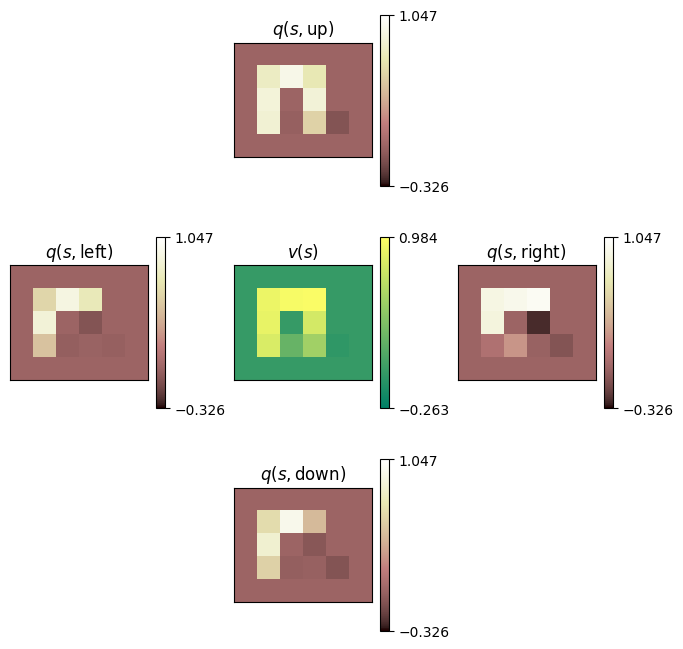

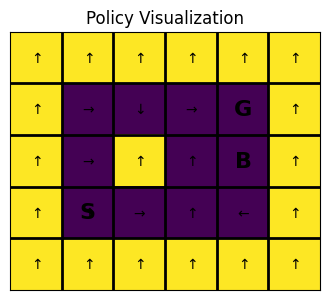

In [53]:
num_offline_updates = 0  # @param {type:"integer"}
epsilon = 0.1  #@param {type:"number"}
num_steps = 1e4  # @param {type: "number"}
num_steps = int(num_steps)

num_episodes = 8000
num_episodes = int(num_episodes)

# Create the environment.
grid = build_gridworld_task(task='AIMA')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

agent = ReplayQLearningAgent(
    environment_spec,
    behaviour_policy=behavior_policy,
    num_offline_updates=num_offline_updates,
    step_size=0.1)

# Run experiment and get the value functions from agent.
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

# Plot values and policy.
q = agent.q_values.reshape(grid.layout.shape + (4,))
plot_action_values(q)
grid.plot_greedy_policy(q)

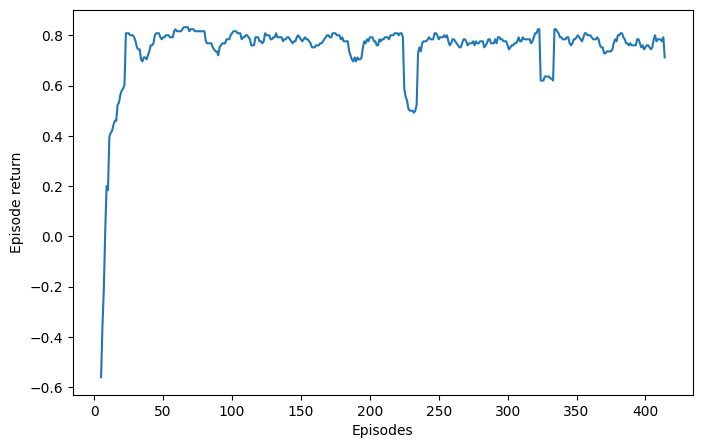

In [54]:
#@title Visualise the training curve { form-width: "30%" }

# Compute rolling average over returns
returns_avg = pd.Series(returns).rolling(10, center=True).mean()

plt.figure(figsize=(8, 5))
plt.plot(range(len(returns)), returns_avg)
plt.xlabel('Episodes')
plt.ylabel('Episode return');

AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...


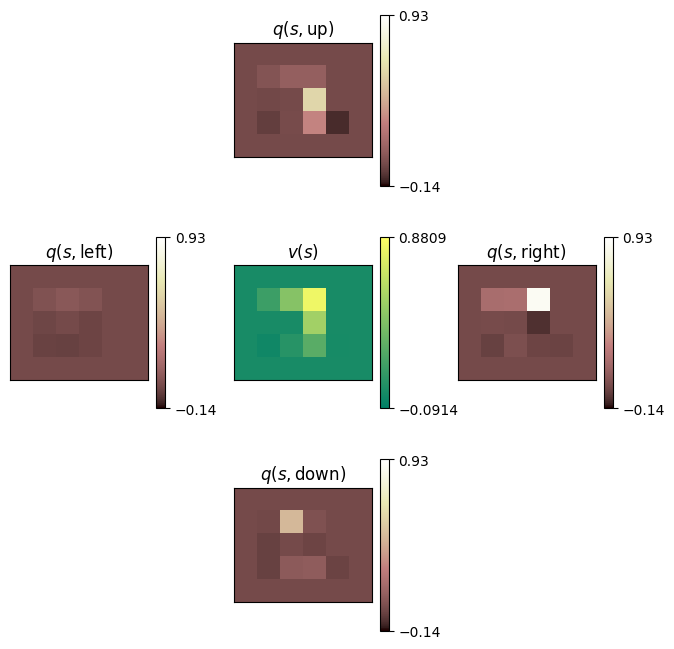

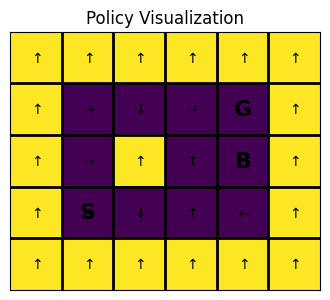

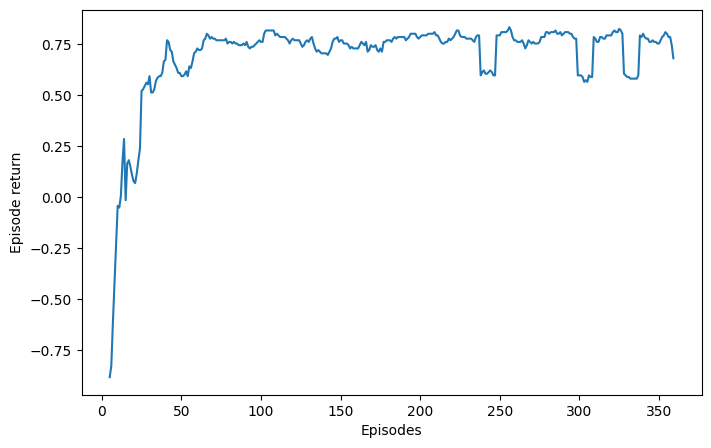

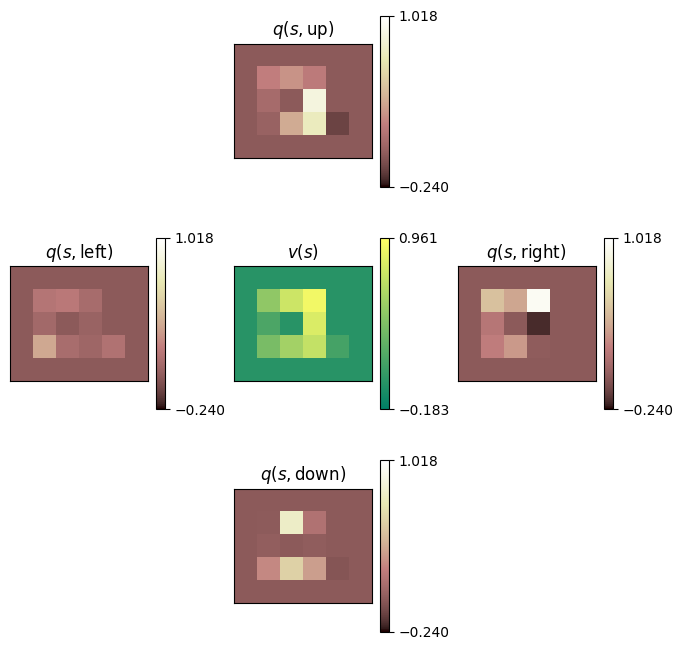

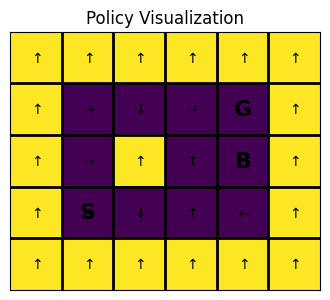

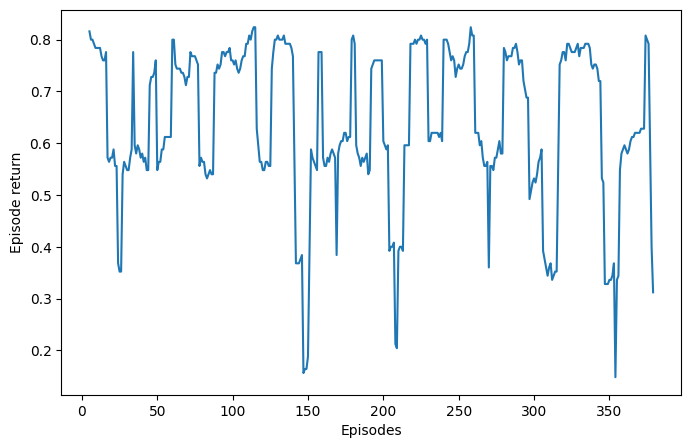

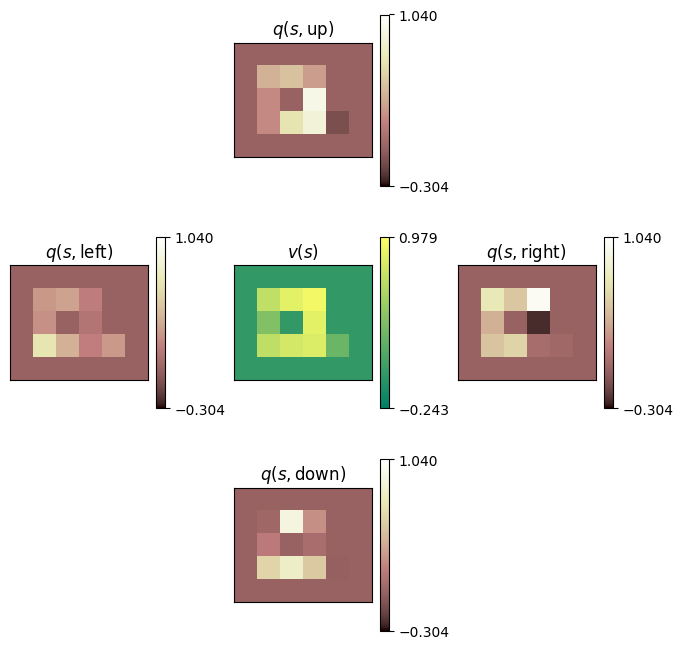

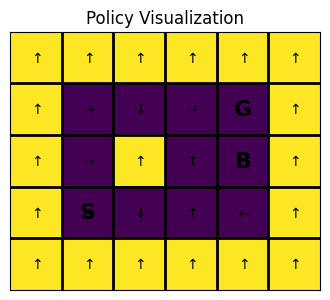

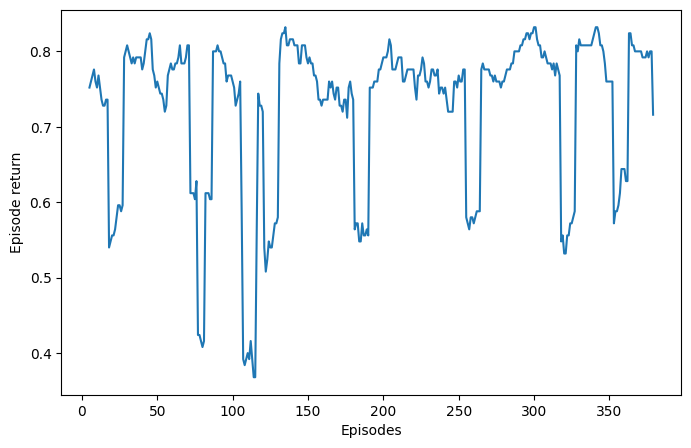

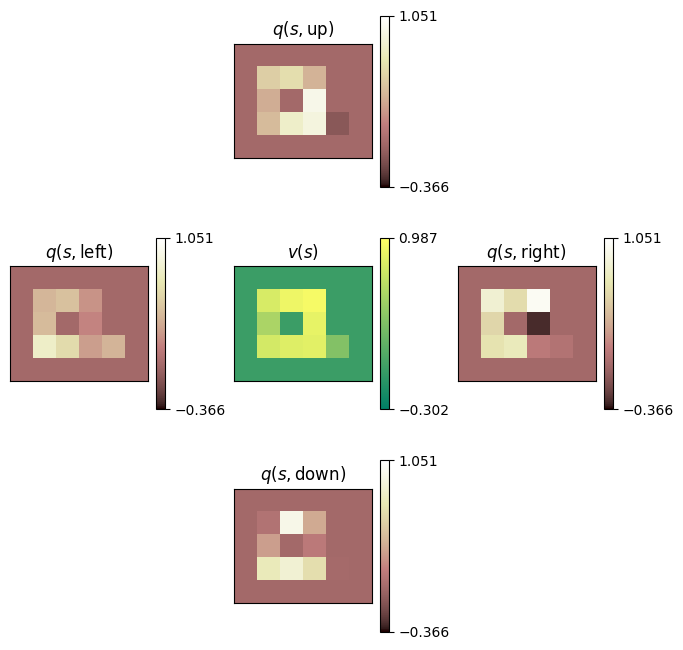

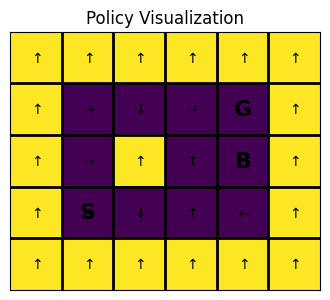

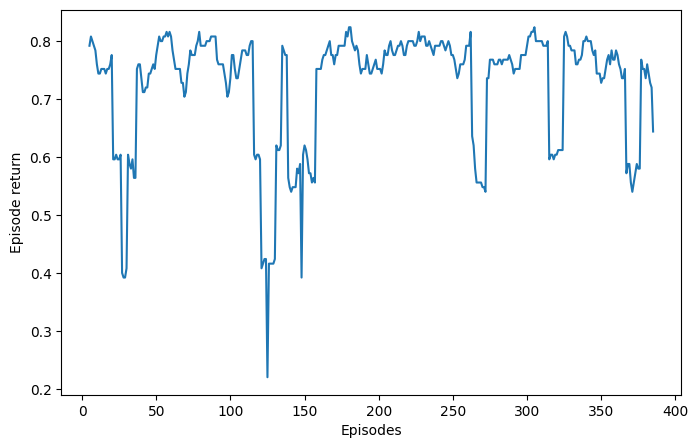

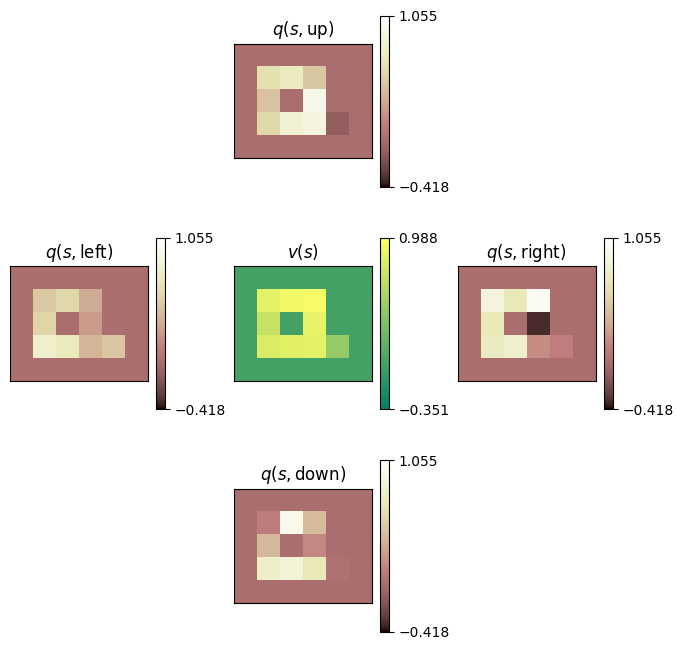

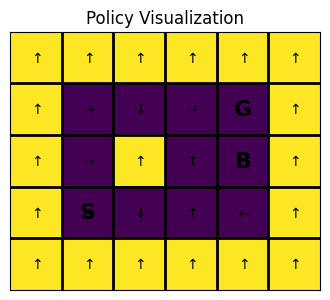

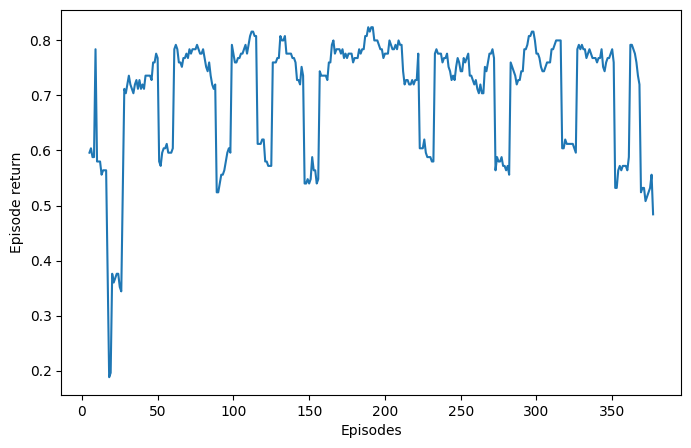

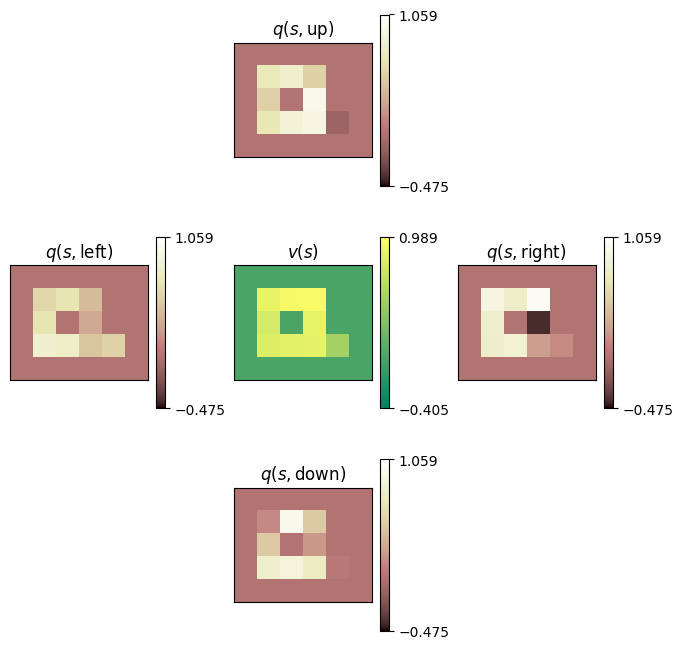

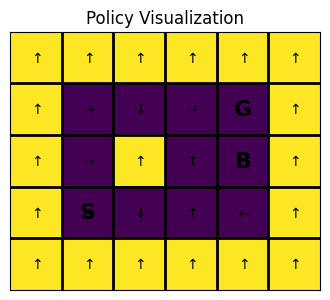

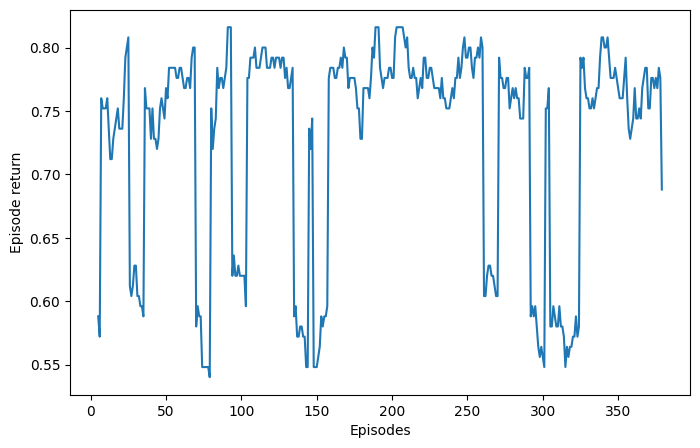

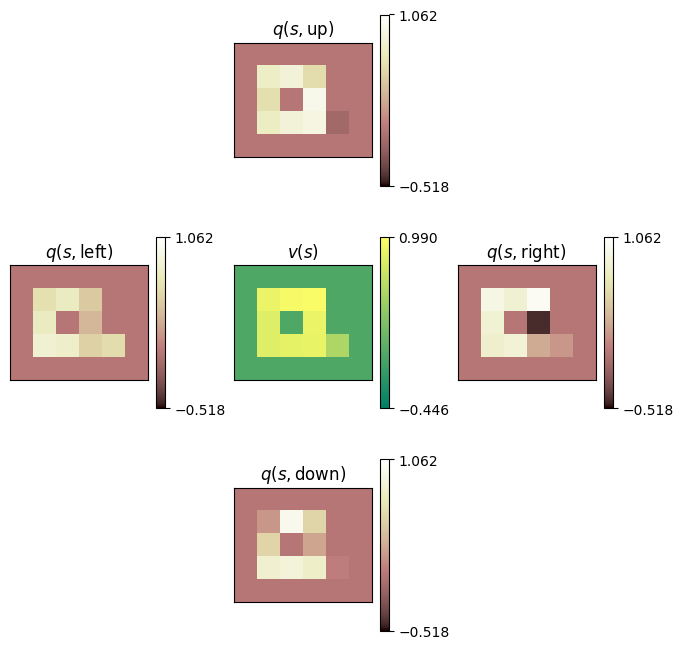

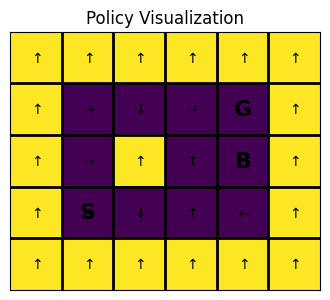

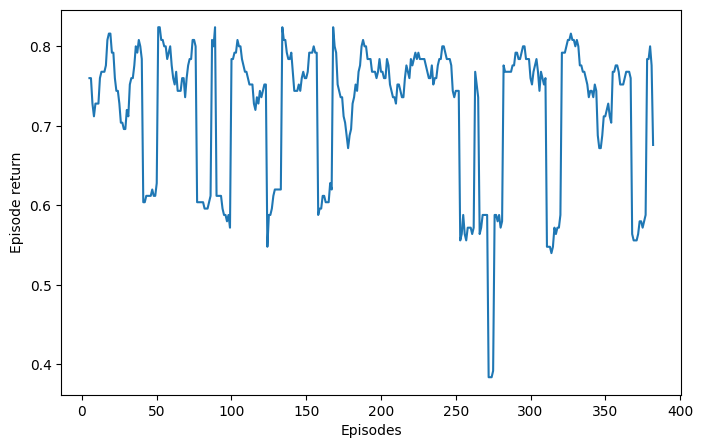

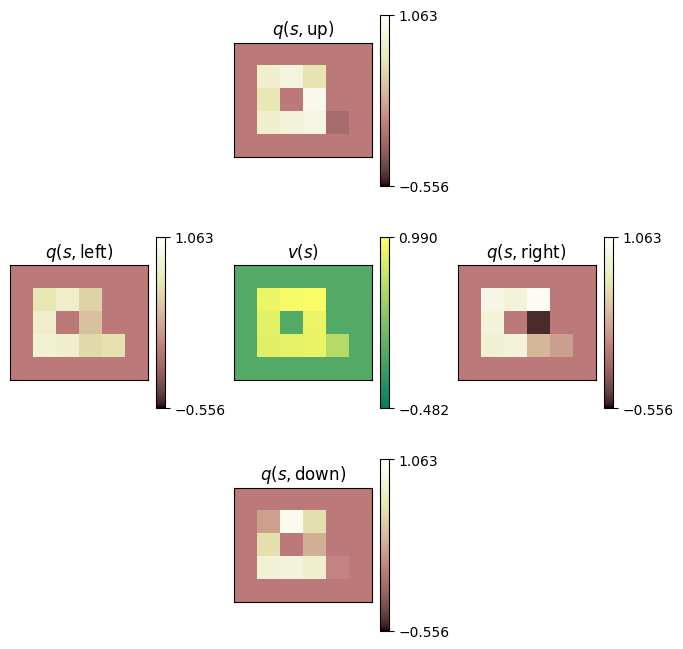

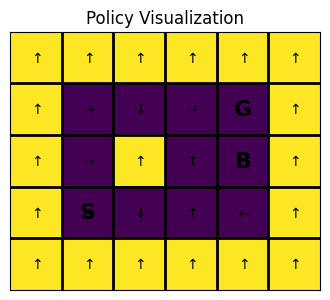

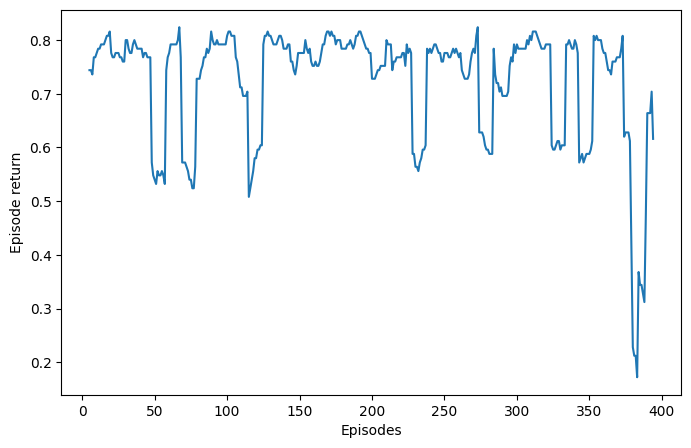

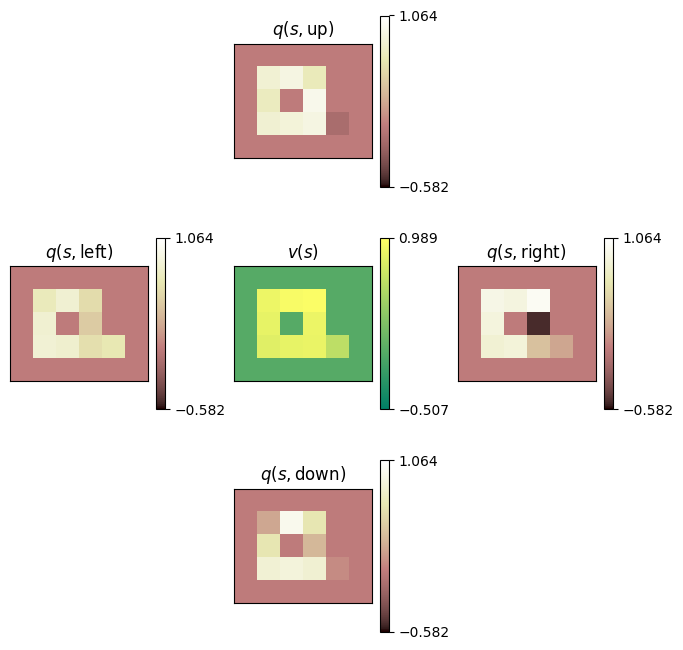

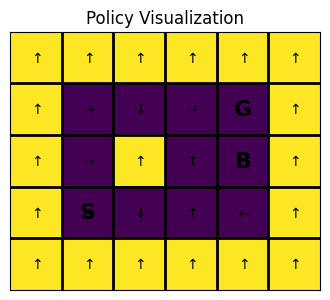

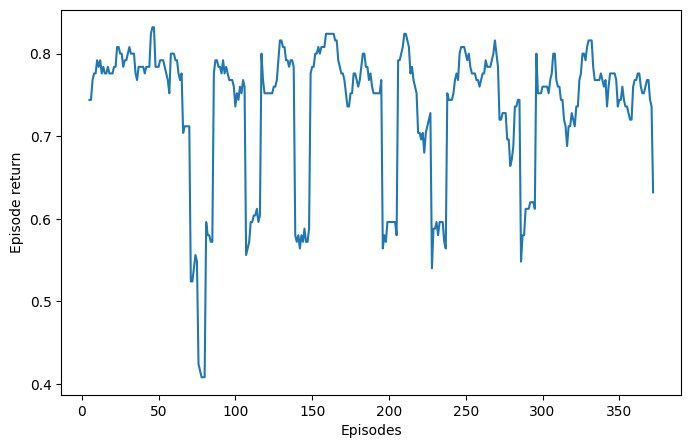

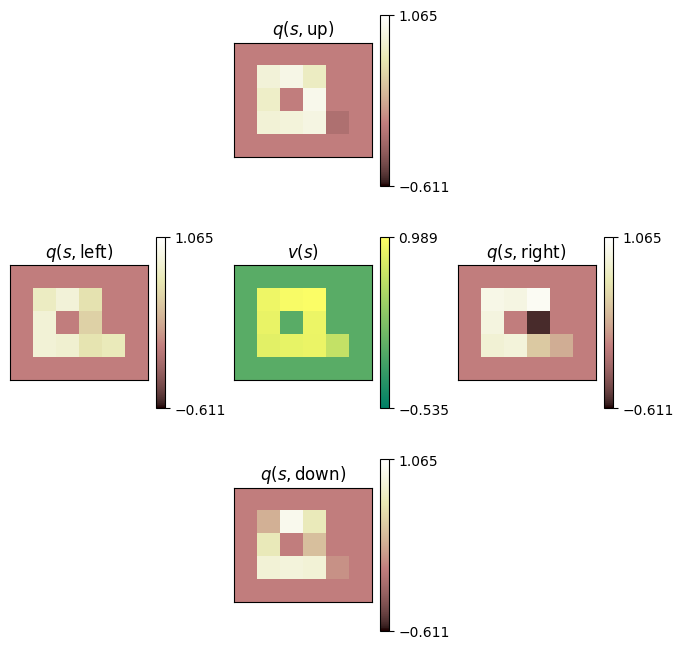

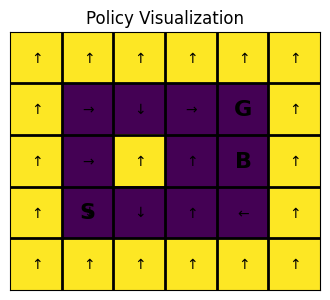

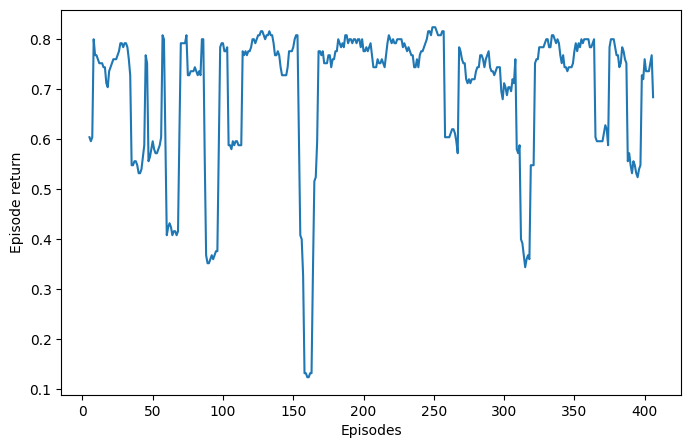

In [55]:
num_offline_updates = 10  # @param {type:"integer"}
epsilon = 0.1  #@param {type:"number"}
num_steps = 1e4  # @param {type: "number"}
num_steps = int(num_steps)

num_episodes = 8000
num_episodes = int(num_episodes)

# Create the environment.
grid = build_gridworld_task(task='AIMA')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

agent = ReplayQLearningAgent(
    environment_spec,
    behaviour_policy=behavior_policy,
    num_offline_updates=num_offline_updates,
    step_size=0.001)

for i in range(10):
  # run experiment and get the value functions from agent
  returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

  # get the q-values
  q = agent.q_values.reshape(grid.layout.shape + (4,))

  # visualize value functions
  print('AFTER {:,} STEPS ...'.format(num_steps))
  plot_action_values(q, epsilon=epsilon)

  # visualise the greedy policy
  grid.plot_greedy_policy(q)

  #@title Visualise the training curve { form-width: "30%" }

  # Compute rolling average over returns
  returns_avg = pd.Series(returns).rolling(10, center=True).mean()

  plt.figure(figsize=(8, 5))
  plt.plot(range(len(returns)), returns_avg)
  plt.xlabel('Episodes')
  plt.ylabel('Episode return');

AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...
AFTER 10,000 STEPS ...


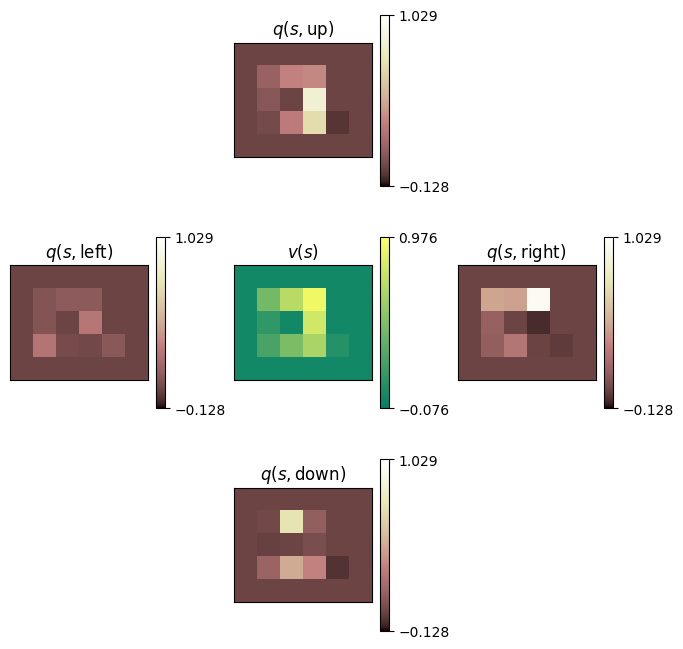

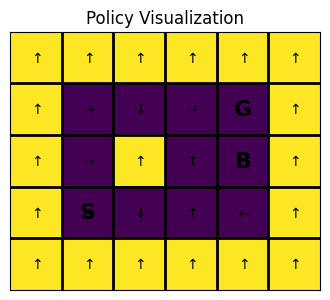

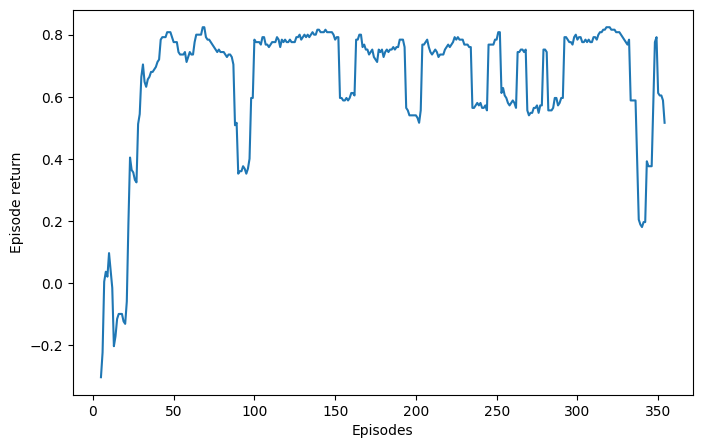

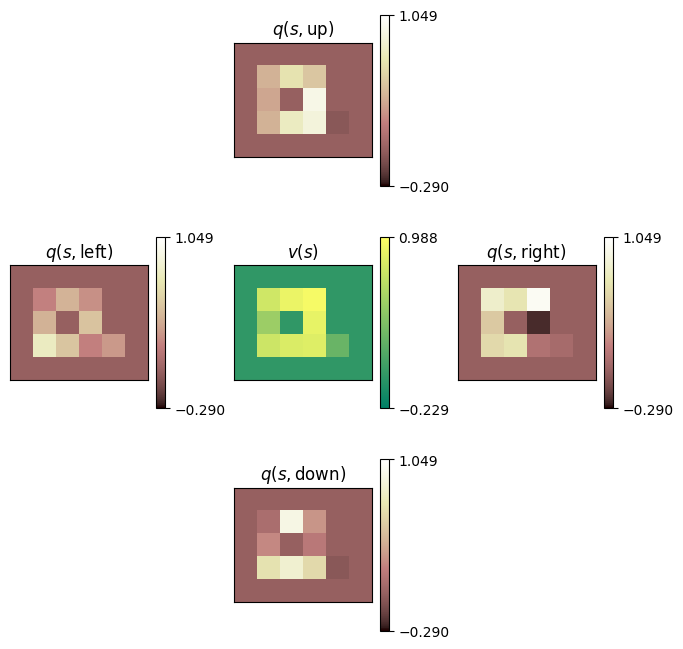

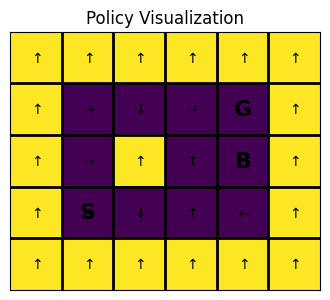

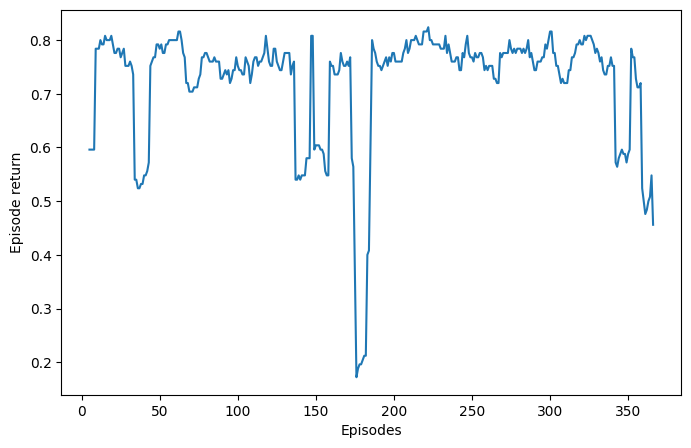

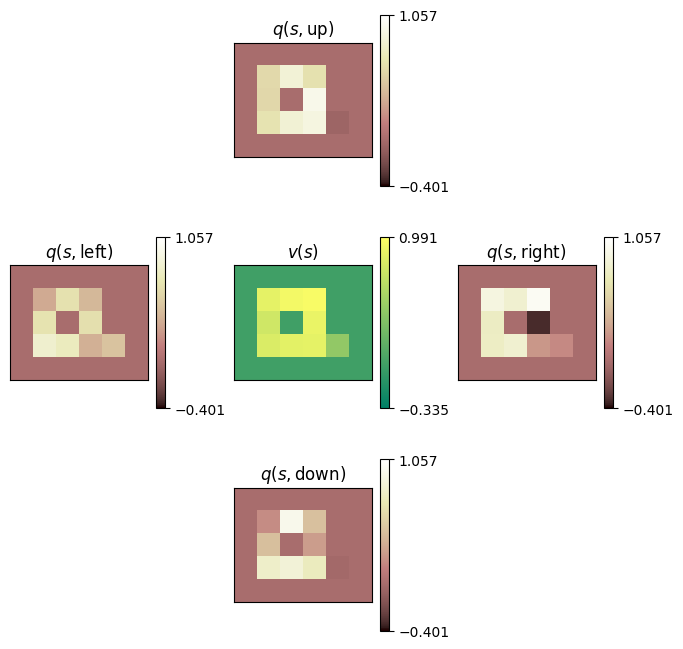

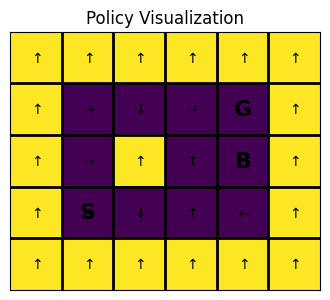

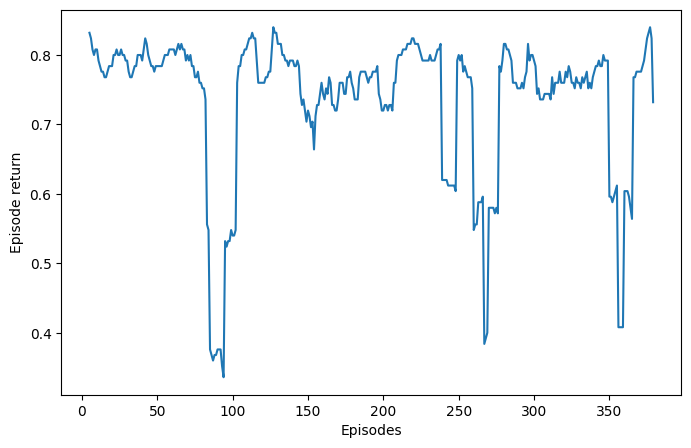

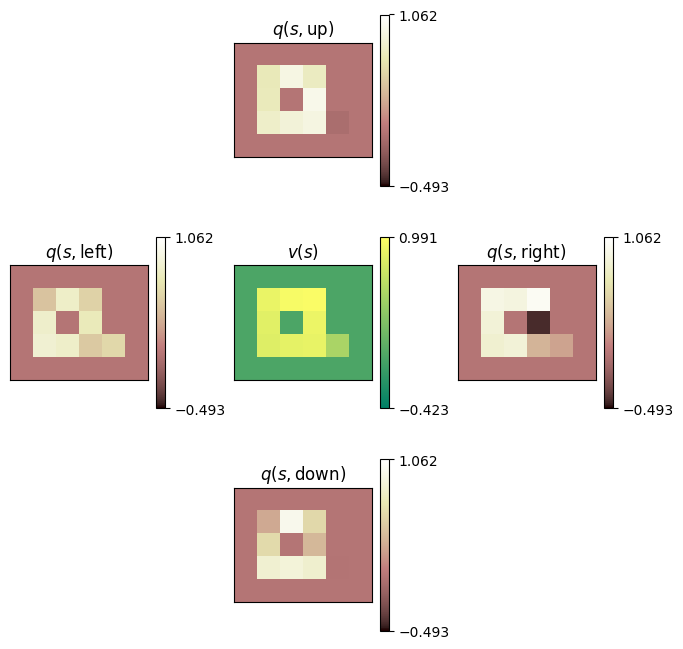

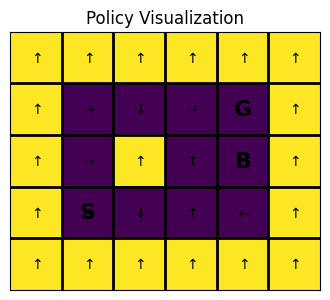

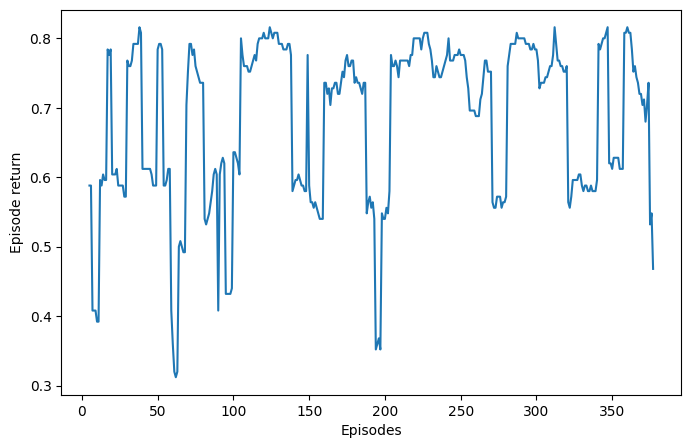

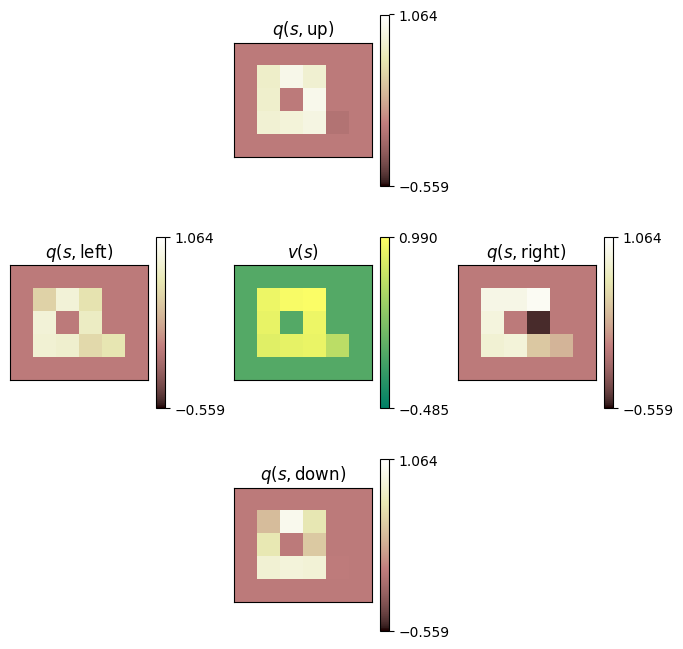

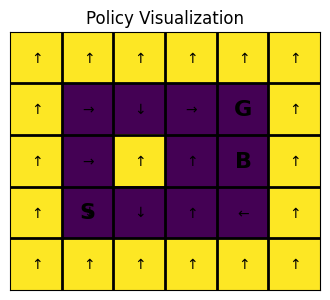

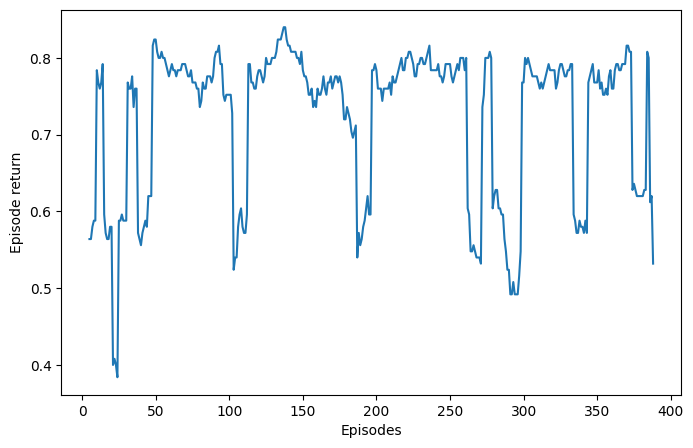

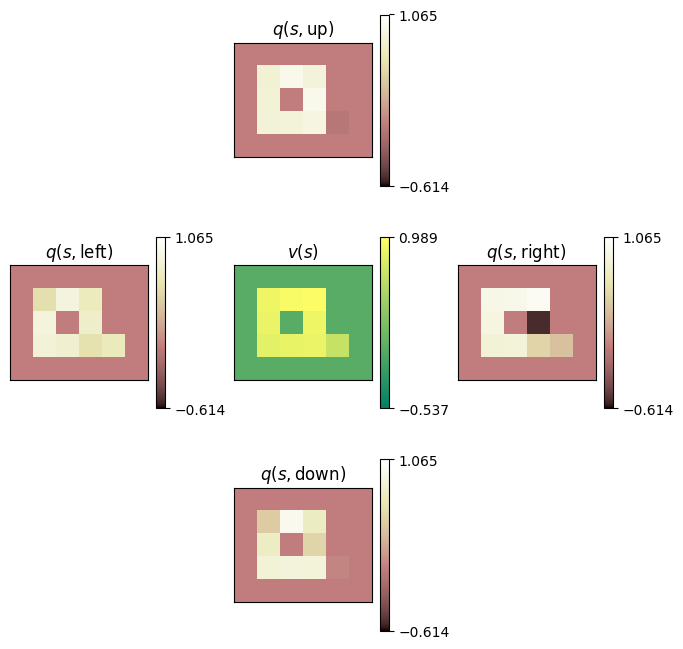

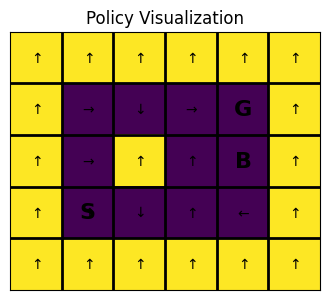

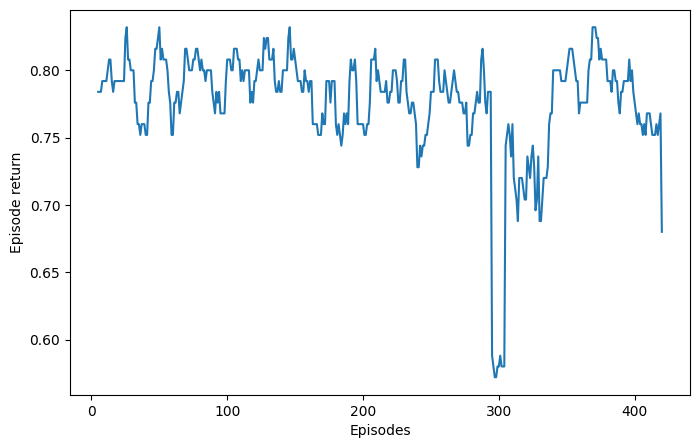

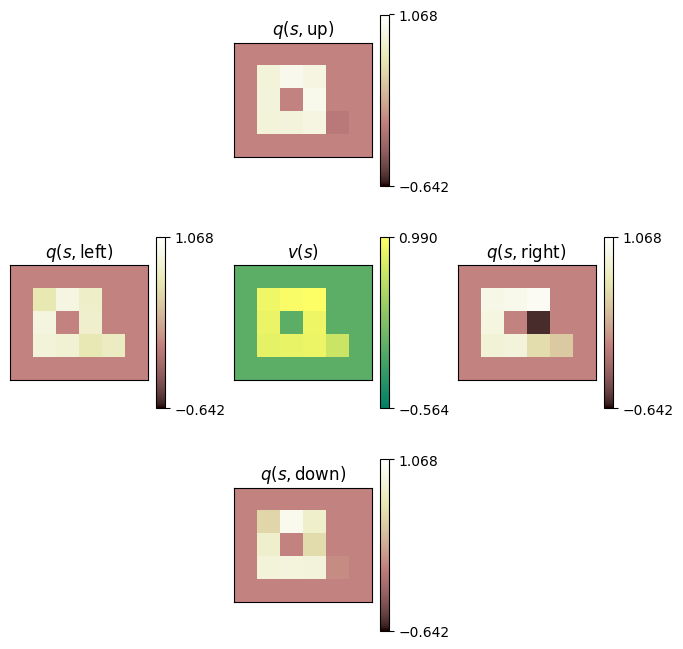

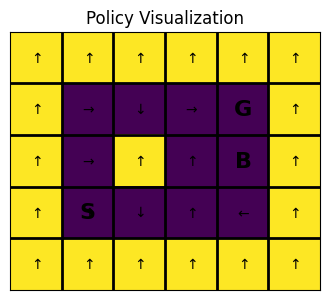

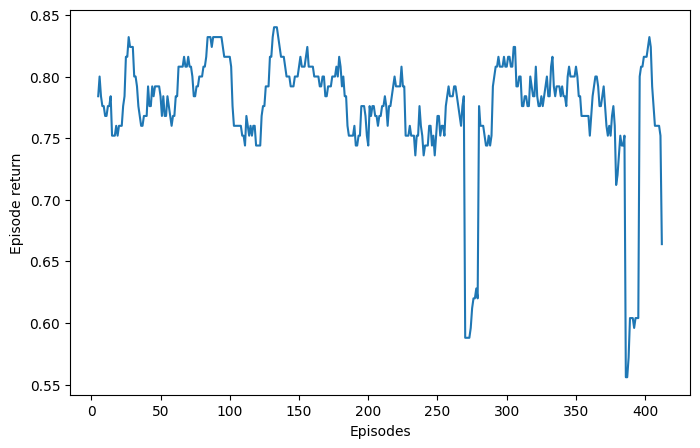

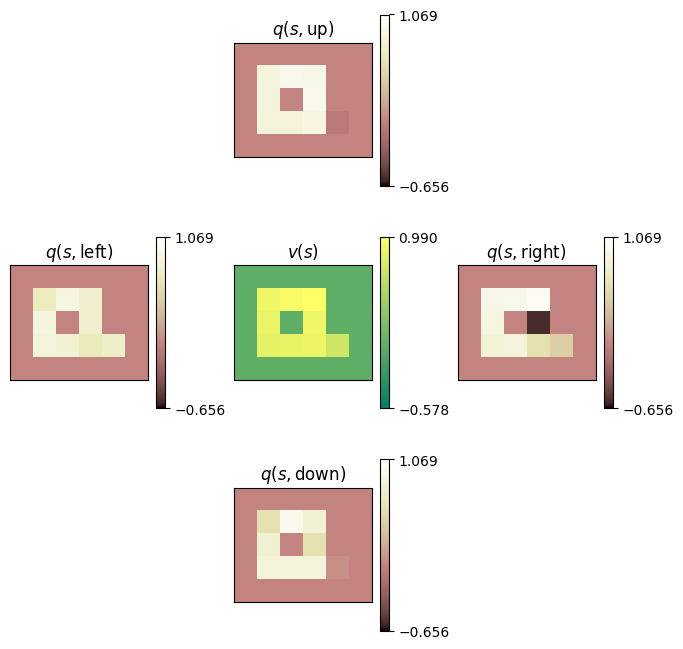

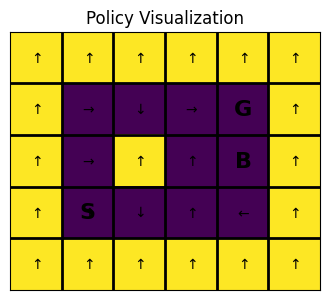

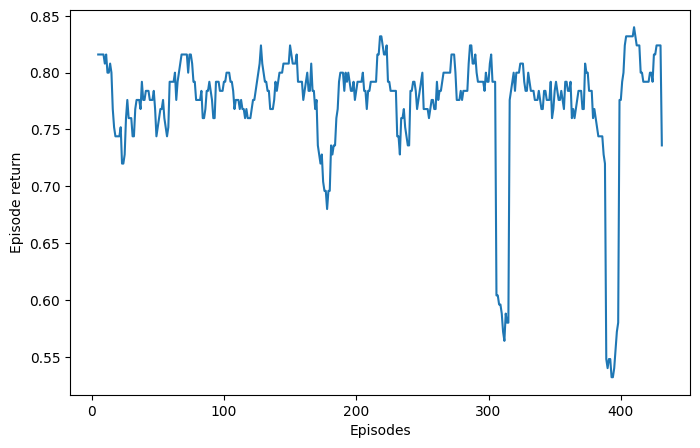

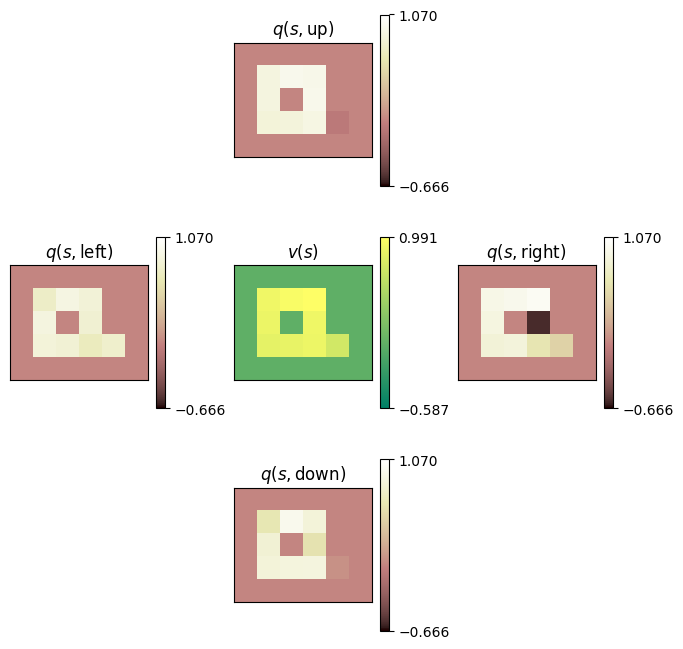

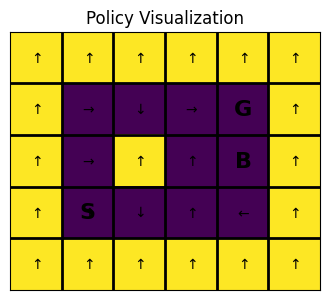

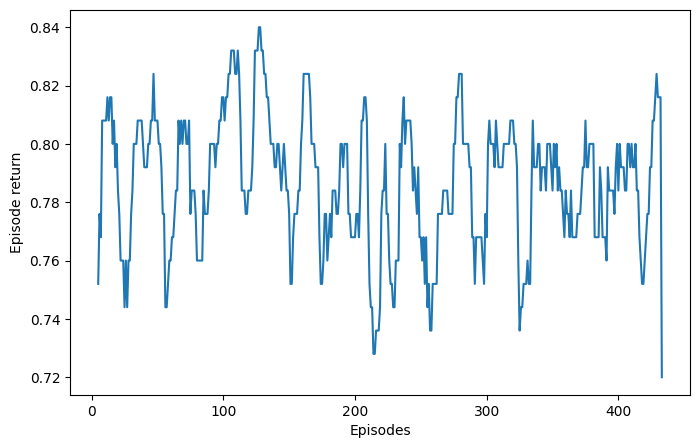

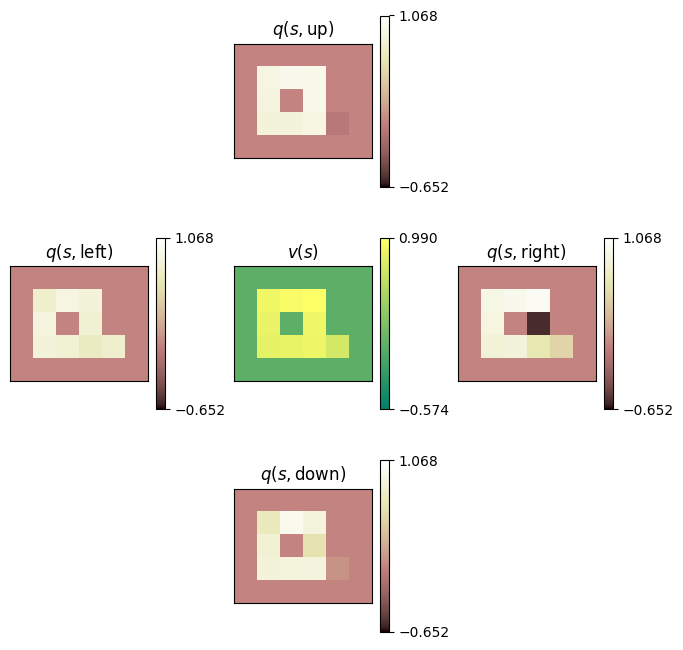

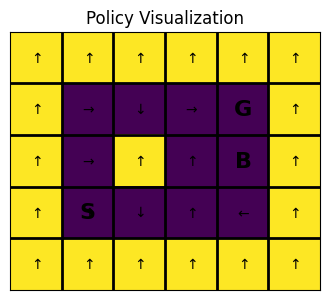

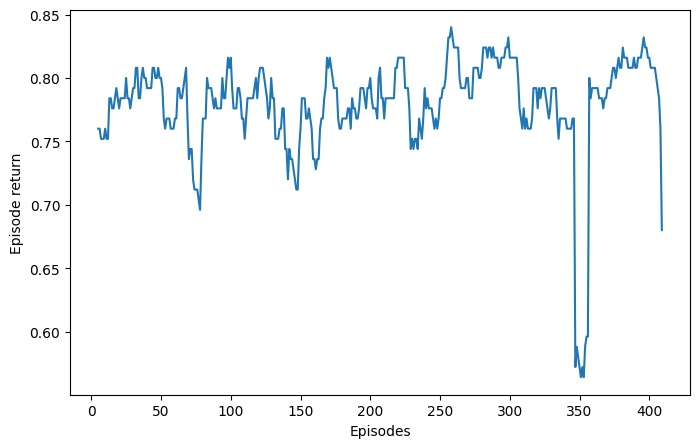

In [56]:
num_offline_updates = 20  # @param {type:"integer"}
epsilon = 0.1  #@param {type:"number"}
num_steps = 1e4  # @param {type: "number"}
num_steps = int(num_steps)

num_episodes = 8000
num_episodes = int(num_episodes)

# Create the environment.
grid = build_gridworld_task(task='AIMA')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

agent = ReplayQLearningAgent(
    environment_spec,
    behaviour_policy=behavior_policy,
    num_offline_updates=num_offline_updates,
    step_size=0.001)

for i in range(10):
  # run experiment and get the value functions from agent
  returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

  # get the q-values
  q = agent.q_values.reshape(grid.layout.shape + (4,))

  # visualize value functions
  print('AFTER {:,} STEPS ...'.format(num_steps))
  plot_action_values(q, epsilon=epsilon)

  # visualise the greedy policy
  grid.plot_greedy_policy(q)

  #@title Visualise the training curve { form-width: "30%" }

  # Compute rolling average over returns
  returns_avg = pd.Series(returns).rolling(10, center=True).mean()

  plt.figure(figsize=(8, 5))
  plt.plot(range(len(returns)), returns_avg)
  plt.xlabel('Episodes')
  plt.ylabel('Episode return');

### Szwabe: Set all the three parameters in a way approaching the AIMA values as close as possible and analyze its performance:

AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...
AFTER 100,000 STEPS ...


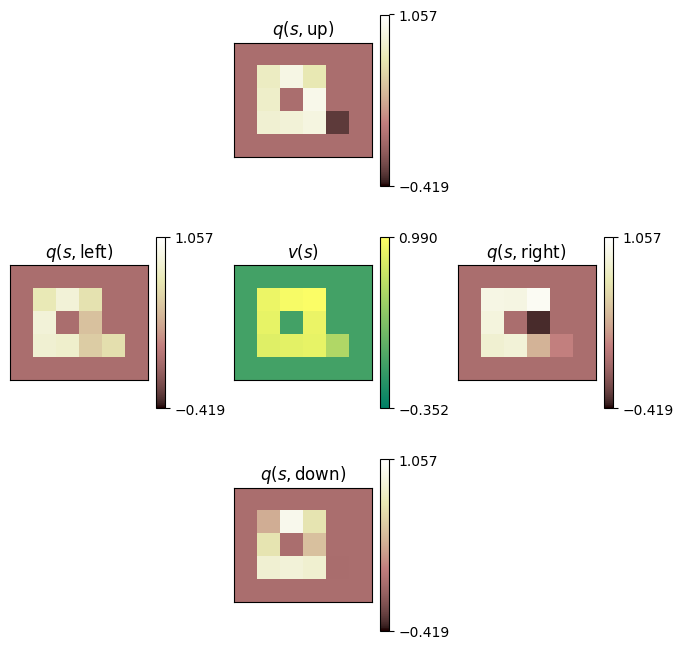

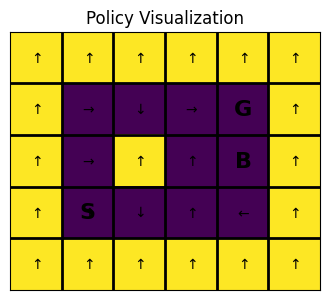

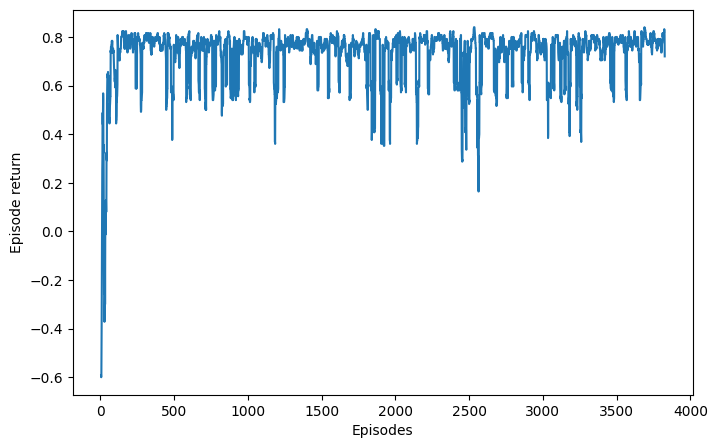

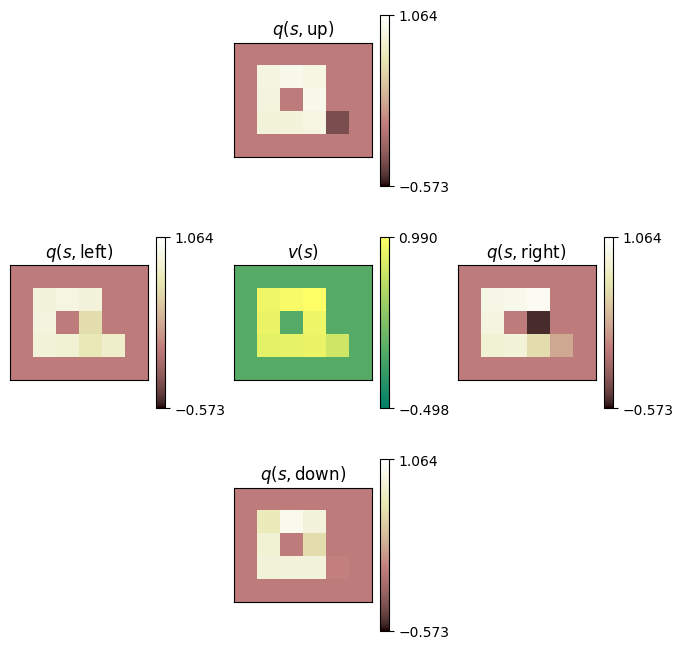

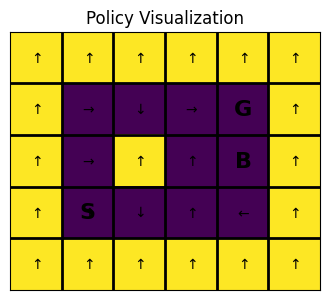

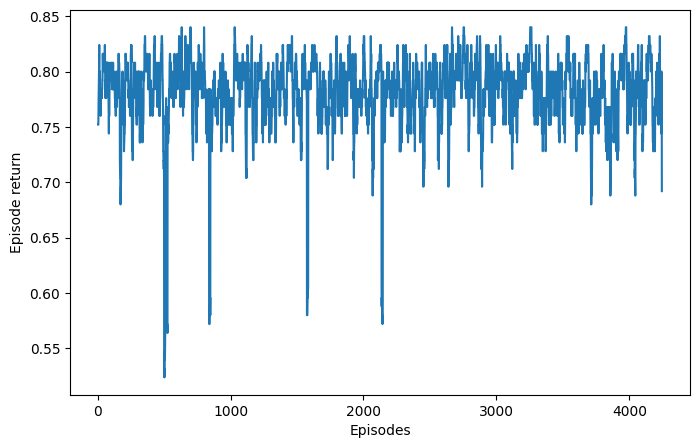

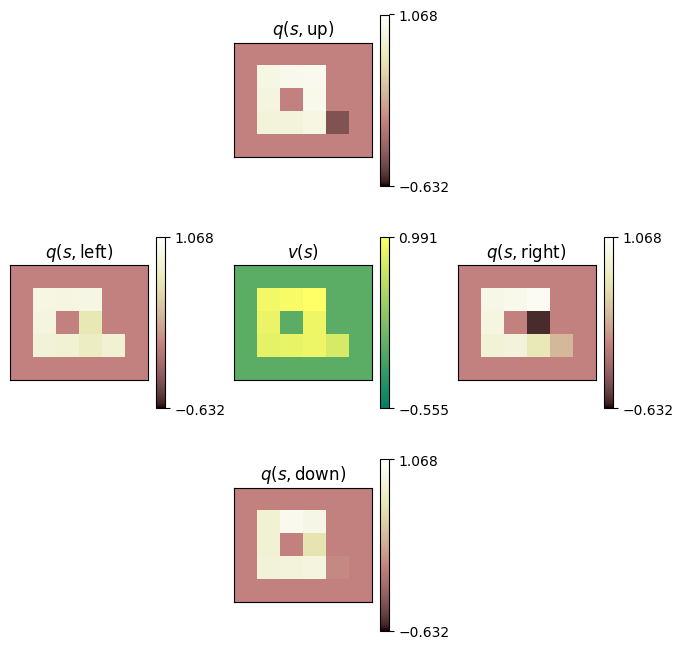

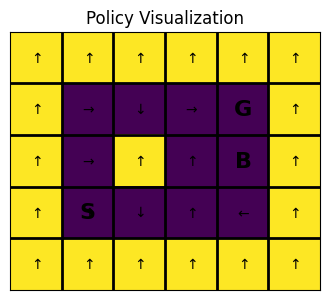

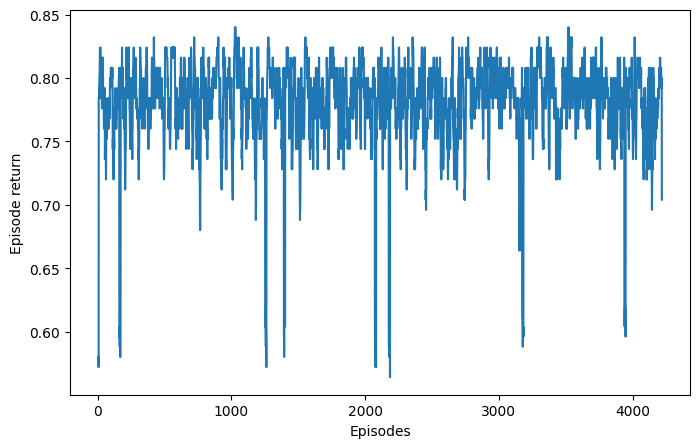

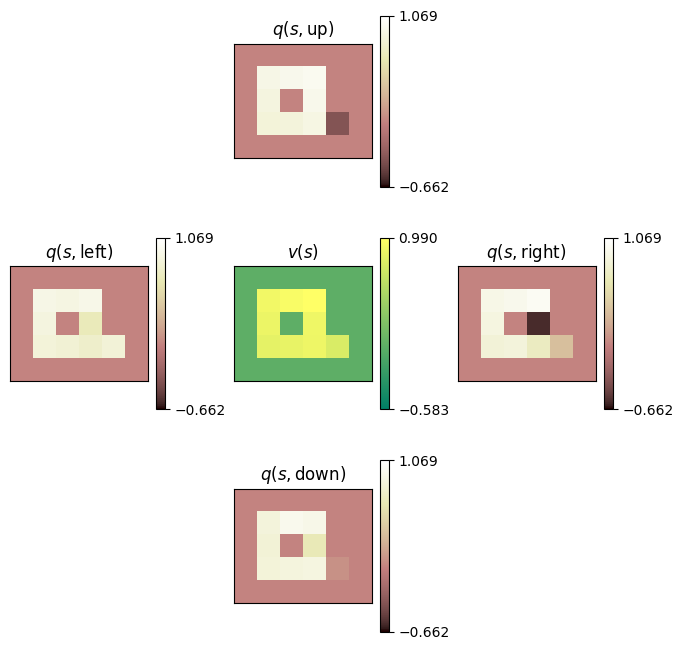

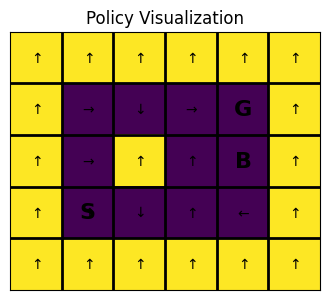

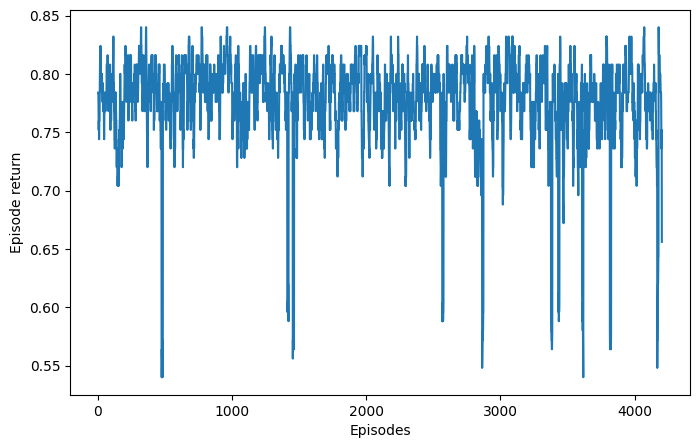

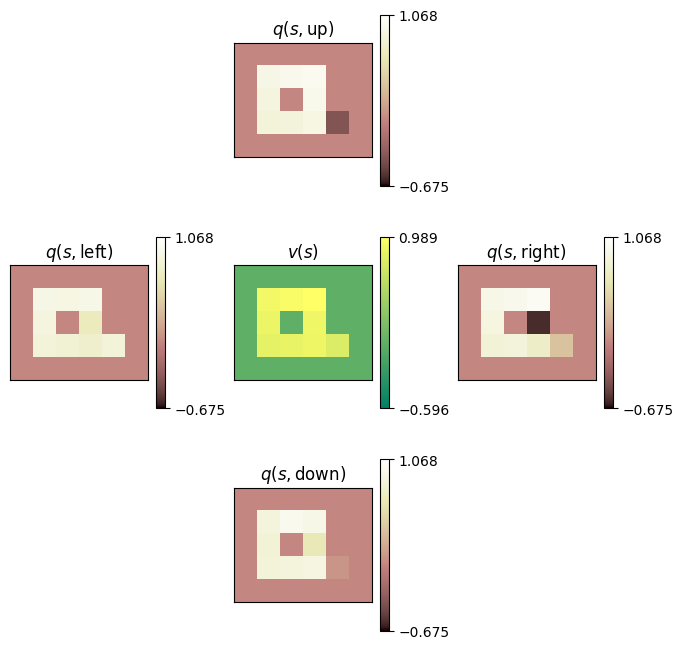

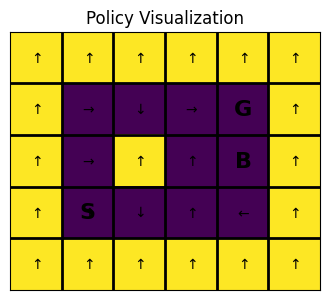

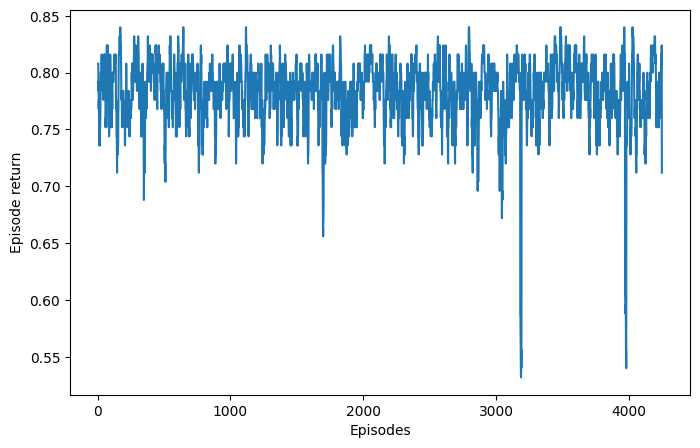

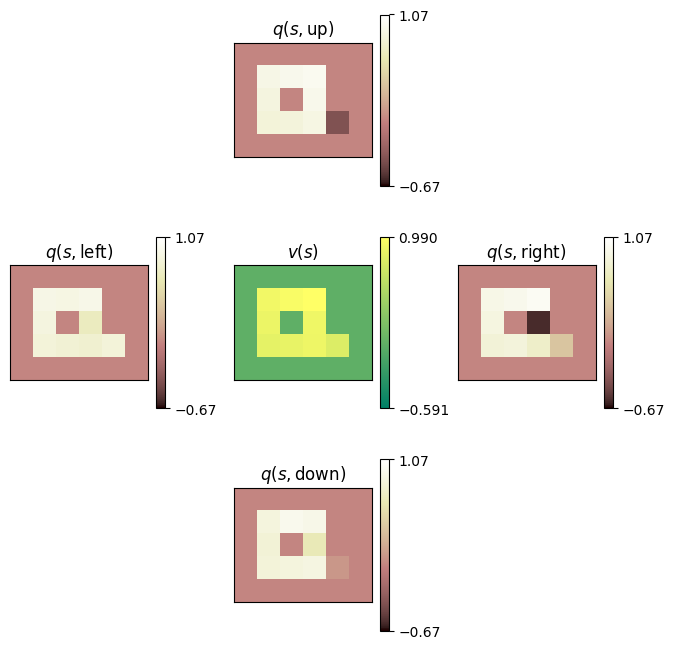

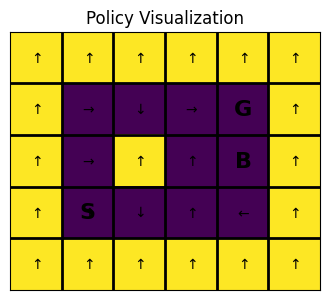

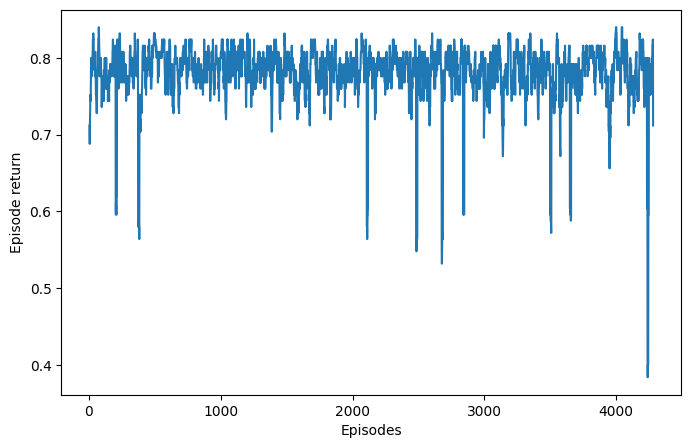

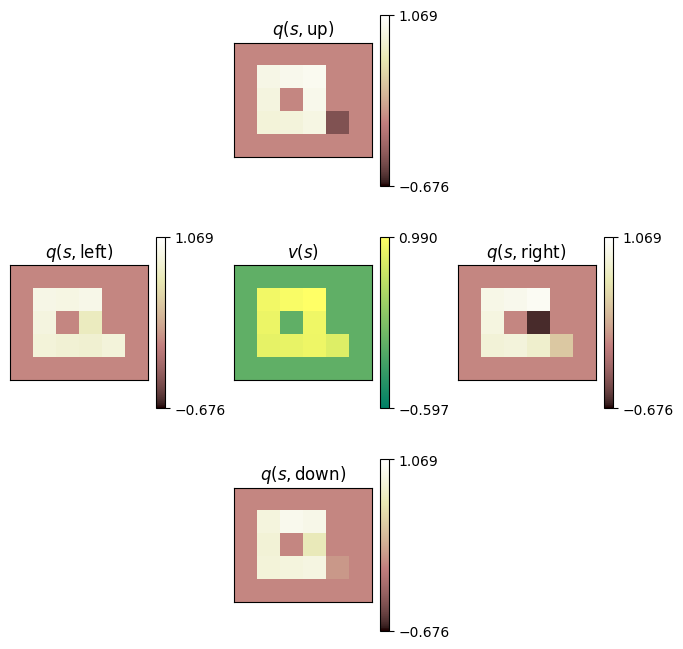

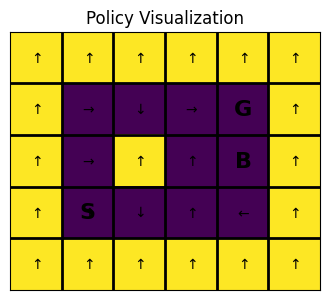

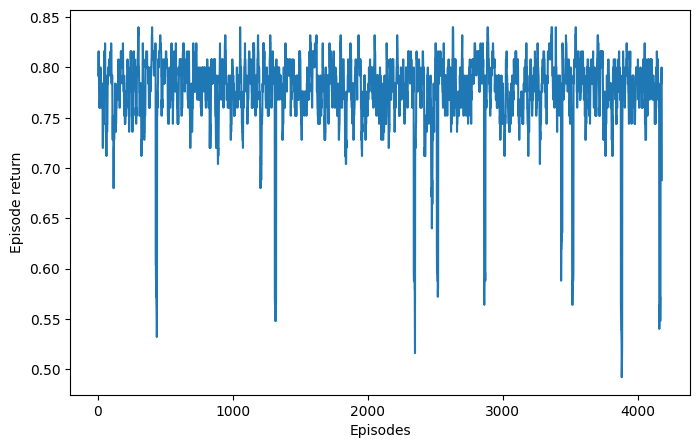

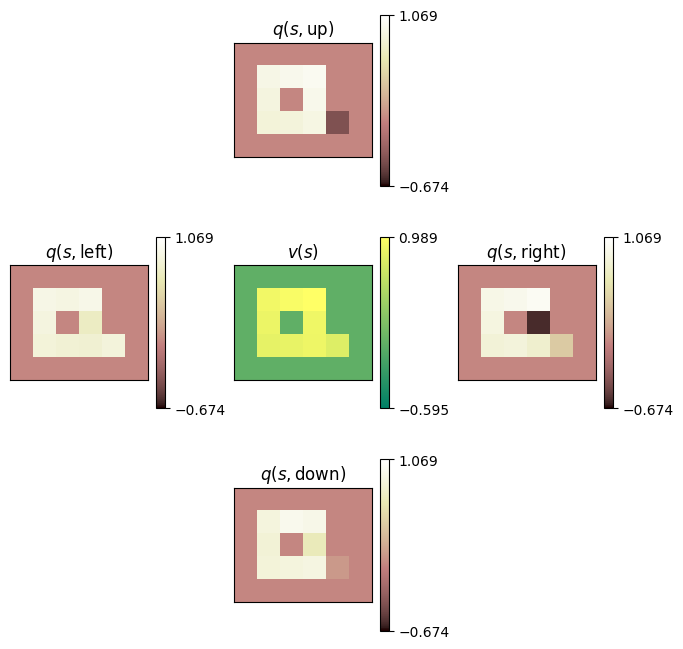

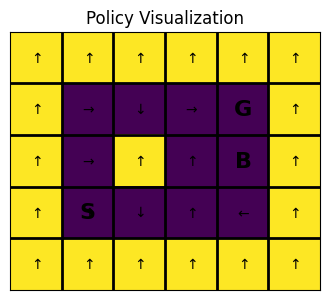

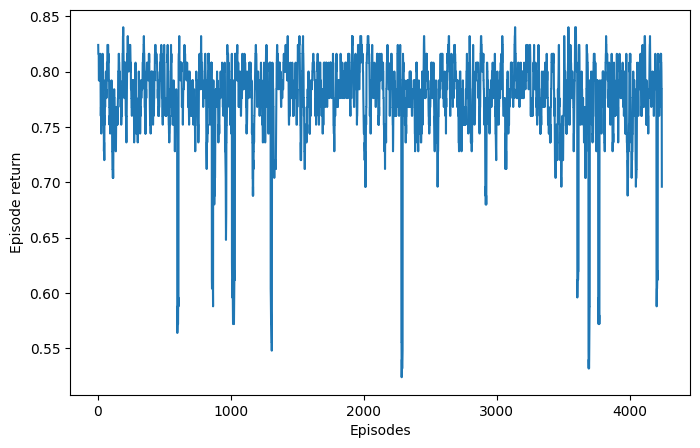

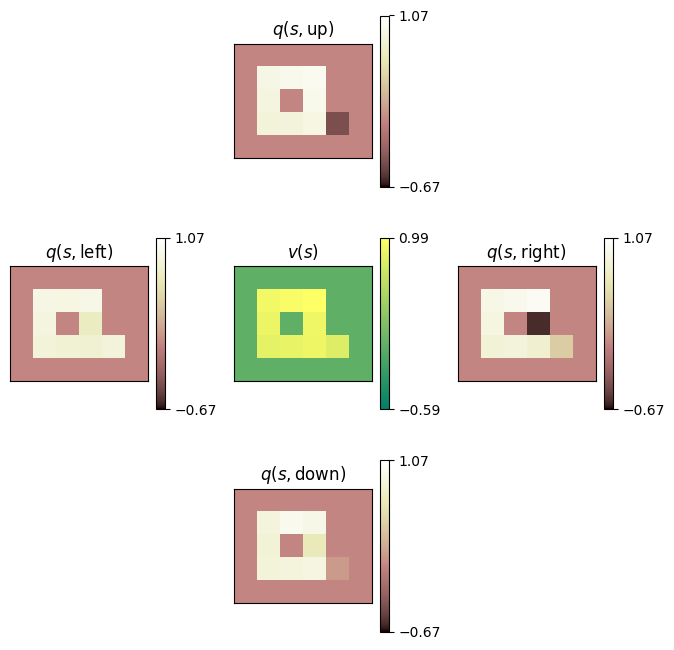

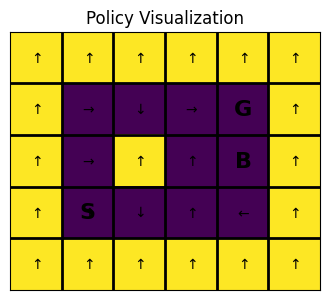

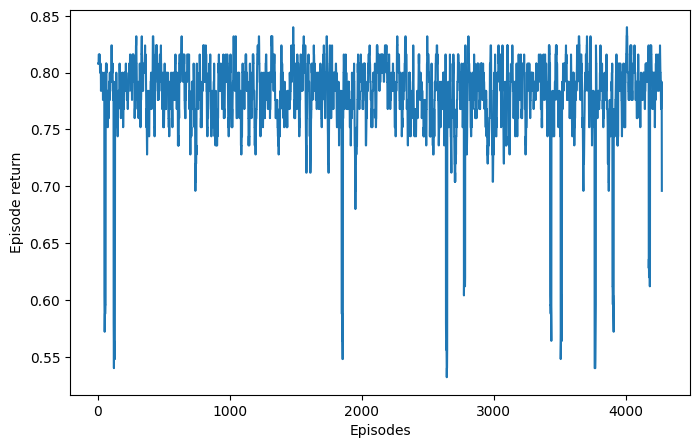

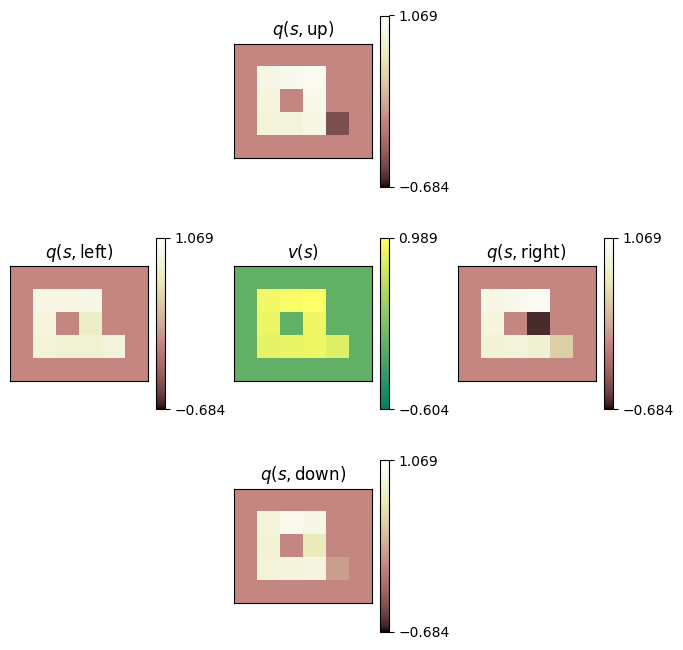

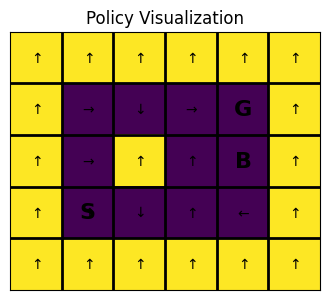

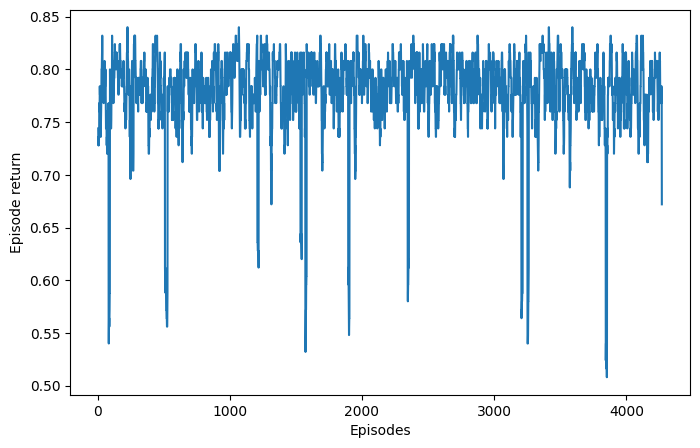

In [57]:
num_offline_updates = 10  # @param {type:"integer"}
epsilon = 0.1  #@param {type:"number"}
num_steps = 1e5  # @param {type: "number"}
num_steps = int(num_steps)

num_episodes = 8000
num_episodes = int(num_episodes)

# Create the environment.
grid = build_gridworld_task(task='AIMA')
environment, environment_spec = setup_environment(grid)

# behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

agent = ReplayQLearningAgent(
    environment_spec,
    behaviour_policy=behavior_policy,
    num_offline_updates=num_offline_updates,
    step_size=0.001)

for i in range(10):
  # run experiment and get the value functions from agent
  returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

  # get the q-values
  q = agent.q_values.reshape(grid.layout.shape + (4,))

  # visualize value functions
  print('AFTER {:,} STEPS ...'.format(num_steps))
  plot_action_values(q, epsilon=epsilon)

  # visualise the greedy policy
  grid.plot_greedy_policy(q)

  #@title Visualise the training curve { form-width: "30%" }

  # Compute rolling average over returns
  returns_avg = pd.Series(returns).rolling(10, center=True).mean()

  plt.figure(figsize=(8, 5))
  plt.plot(range(len(returns)), returns_avg)
  plt.xlabel('Episodes')
  plt.ylabel('Episode return');

### Nowak: Effect of Varying `num_offline_updates` in Q-learning with Experience Replay

- **num_offline_updates = 0**:
  - No experience replay.
  - Agent learns only from most recent transitions.
  - Q-values update slowly; learning can be unstable or inconsistent with limited data.
  - Final policy may remain noisy or suboptimal.

- **num_offline_updates = 10**:
  - Moderate replay improves sample efficiency.
  - Agent starts to reinforce good experiences and correct mistakes more consistently.
  - Policy improves, but convergence is still not smooth.

- **num_offline_updates = 20**:
  - More replay leads to noticeably better value propagation.
  - Agent generalizes better from limited experience.
  - Final policy is closer to optimal; Q-values become more stable and reliable.

- **num_offline_updates = 30**:
  - Frequent replay maximizes learning from past transitions.
  - Converges faster and learns a more coherent and deterministic policy.
  - Most effective configuration in low-step regime; clear improvement over lower replay counts.

- **Conclusion**:
  - Increasing `num_offline_updates` improves performance in low-data scenarios.
  - Higher replay allows better use of limited experience and accelerates value propagation.


###Szwabe: Compare the results with a the analogical results for deterministic state transition.

Nowak:

In stochastic environments, Q-values are updated based on noisy samples. That makes it harder to estimate the true value of actions from limited data.

In deterministic environments, every sample is reliable—so even without replay, learning can progress quickly and smoothly.

---

#### **num_offline_updates = 0** (No replay):
- **Stochastic**: Learning is slower and less stable due to randomness in transitions. The agent may need more steps to average out noisy updates.
- **Deterministic**: Learning is faster and more stable. Since the environment behaves predictably, even without replay, the agent can efficiently converge to a good policy.

---

#### **num_offline_updates = 10**:
- **Stochastic**: Replay significantly improves performance. Reusing past experiences helps stabilize learning by countering transition noise.
- **Deterministic**: Still beneficial but less dramatic. The agent already receives consistent updates from the environment, so replay mainly reinforces correct Q-values.

---

#### **num_offline_updates = 20 and 30**:
- **Stochastic**: Further improvement. More replay helps correct noisy value estimates, especially early in training.
- **Deterministic**: Gains are marginal beyond 10 updates. The added offline updates yield diminishing returns because learning is already stable.



# Towards Deep Q-learning: simple approximation of the Q function


<center>
<img src="https://drive.google.com/uc?id=1XIj68U3eB1bKYfIEHAcVbfwobmMYQQ4X" width="500" />
</center>

So far we only considered look-up tables for value-functions. In all previous cases every state and action pair $(\color{red}{s}, \color{blue}{a})$, had an entry in our $\color{green}Q$-table. Again, this is possible in this environment as the number of states is equal to the number of cells in the grid. But this is not scalable to situations where, say, the goal location changes or the obstacles are in different locations at every episode (consider how big the table could be in this situation?).

An example (not covered in this tutorial) is ATARI from pixels, where the number of possible frames an agent can see is exponential in the number of pixels on the screen.

<center><img width="200" alt="portfolio_view" src="https://miro.medium.com/max/1760/1*XyIpmXXAjbXerDzmGQL1yA.gif"></center>

But what we **really** want is just to be able to *compute* the Q-value, when fed with a particular $(\color{red}{s}, \color{blue}{a})$ pair. So if we had a way to get a function to do this work instead of keeping a big table, we'd get around this problem.

To address this, we can use **function approximation** as a way to generalize Q-values over some representation of the very large state space, and **train** them to output the values they should. In this section, we will explore $\color{green}Q$-learning with function approximation, which (although it has been theoretically proven to diverge for some degenerate MDPs) can yield impressive results in very large environments. In particular, we will look at [Neural Fitted Q (NFQ) Iteration](http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf) and [Deep Q-Networks (DQN)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf).



### Quick recap on replay

An important property of off-policy methods like $\color{green}Q$-learning is that they involve two policies: one for exploration and one that is being optimized (via the $\color{green}Q$-function updates). This means that we can generate data from the **behavior** policy and insert that data into some form of data storage---usually referred to as **replay**.

In order to optimize the $\color{green}Q$-function we can then sample data from the replay <font color='purple'>**dataset**</font> and use that data to perform an update. An illustration of this learning loop is shown below.

<center><img src="https://drive.google.com/uc?id=1ivTQBHWkYi_J9vWwXFd2sSWg5f2TB5T-" width="400" /></center>

In the next section we will show how to implement a simple replay buffer. This can be as simple as a python list containing transition data. In more complicated scenarios we might want to have a more performance-tuned variant, we might have to be more concerned about how large replay is and what to do when its full, and we might want to sample from replay in different ways. But a simple python list can go a surprisingly long way.

## A simple replay buffer

In [58]:
#@title simple replay buffer  { form-width: "30%" }

# Create a convenient container for the SARS tuples required by deep RL agents.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])

class ReplayBuffer(object):
  """A simple Python replay buffer."""

  def __init__(self, capacity: int = None):
    self.buffer = collections.deque(maxlen=capacity)
    self._prev_state = None

  def add_first(self, initial_timestep: dm_env.TimeStep):
    self._prev_state = initial_timestep.observation

  def add(self, action: int, timestep: dm_env.TimeStep):
    transition = Transitions(
        state=self._prev_state,
        action=action,
        reward=timestep.reward,
        discount=timestep.discount,
        next_state=timestep.observation,
    )
    self.buffer.append(transition)
    self._prev_state = timestep.observation

  def sample(self, batch_size: int) -> Transitions:
    # Sample a random batch of Transitions as a list.
    batch_as_list = random.sample(self.buffer, batch_size)

    # Convert the list of `batch_size` Transitions into a single Transitions
    # object where each field has `batch_size` stacked fields.
    return tree_utils.stack_sequence_fields(batch_as_list)

  def flush(self) -> Transitions:
    entire_buffer = tree_utils.stack_sequence_fields(self.buffer)
    self.buffer.clear()
    return entire_buffer

  def is_ready(self, batch_size: int) -> bool:
    return batch_size <= len(self.buffer)

## Neural Fitted Q Iteration: Szwabe: Point out the key differences between the agent investigated before and the following simple approximation of the Q-value by a neural network:

# Nowak:

- **Q-value representation**: While tabular Q-learning stores a separate Q-value for each state-action pair, NFQ uses a neural network to approximate the Q-function over the entire space.
- **Scalability**: Tabular methods struggle with large or continuous state spaces; NFQ scales better by generalizing across similar inputs.
- **Generalization**: The neural network in NFQ allows for generalization, learning patterns across states, whereas tabular Q-learning treats each state independently.
- **Learning method**: NFQ learns from batches of experiences (offline updates) using supervised learning, rather than updating Q-values immediately after each step.
- **Stability and tuning**: NFQ can be less stable due to function approximation and requires careful tuning of the network and training procedure.


[Neural Fitted Q Iteration](http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf) was one of the first papers to demonstrate how to leverage recent advances in Deep Learning to approximate the Q-value by a neural network.$^1$
In other words, the value $\color{green}Q(\color{red}{s}, \color{blue}{a})$ are approximated by the output of a neural network $\color{green}{Q_w}(\color{red}{s}, \color{blue}{a})$ for each possible action $\color{blue}{a} \in \color{blue}{\mathcal{A}}$.$^2$

When introducing function approximations, and neural networks in particular, we need to have a loss to optimize. But looking back at the tabular setting above, you can see that we already have some notion of error: the **TD error**.

By training our neural network to output values such that the *TD error is minimized*, we will also satisfy the Bellman Optimality Equation, which is a good sufficient condition to enforce, to obtain an optimal policy.
Thanks to automatic differentiation, we can just write the TD error as a loss, e.g. with an $\ell^2$ loss, but others would work too:

$$L(\color{green}w) = \mathbb{E}\left[ \left( \color{green}{r} + \gamma \max_\color{blue}{a'} \color{green}{Q_w}(\color{red}{s'}, \color{blue}{a'}) − \color{green}{Q_w}(\color{red}{s}, \color{blue}{a})  \right)^2\right].$$

Then we can compute the gradient with respect to the parameters of the neural network and improve our Q-value approximation incrementally.

NFQ builds on $\color{green}Q$-learning, but if one were to update the Q-values online directly, the training can be unstable and very slow.
Instead, NFQ uses a replay buffer, similar to what you just implemented above, to update the Q-value in a batched setting.

When it was introduced, it also was entirely off-policy using a uniformly random policy to collect data, which was prone to instability when applied to more complex environments (e.g. when the input are pixels or the tasks are longer and more complicated).
But it is a good stepping stone to the more complex agents used today. Here, we will look at a slightly different and modernised implementation of NFQ.

<br />

---

<sub>$^1$ If you read the NFQ paper, they use a "control" notation, where there is a "cost to minimize", instead of "rewards to maximize", so don't be surprised if signs/max/min do not correspond.</sub>

<sub>$^2$ We could feed it $\color{blue}{a}$ as well and ask $Q_w$ for a single scalar value, but given we have a fixed number of actions and we usually need to take an $argmax$ over them, it's easiest to just output them all in one pass.</sub>

In [59]:
import sonnet as snt

In [60]:
#@title **[Coding task]** NFQ Agent  { form-width: "30%" }

class NeuralFittedQAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               q_network: snt.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 3e-4):

    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network

    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)

    # Initialize network by feeding a dummy (batched) observation.
    dummy_observation = environment_spec.observations.generate_value()
    _ = self._q_network(dummy_observation[None, ...])

    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = snt.optimizers.Adam(learning_rate)

  def select_action(self, observation):
    # Compute Q-values.
    # Sonnet requires a batch dimension, which we squeeze out right after.
    q_values = self._q_network(observation[None, ...])  # Adds batch dimension.
    q_values = tf.squeeze(q_values, axis=0)  # Removes batch dimension.

    # Select epsilon-greedy action.
    if self._epsilon < tf.random.uniform(shape=()):
      action = tf.argmax(q_values, axis=-1)
    else:
      action = tf.random.uniform(
          shape=(), maxval=self._num_actions, dtype=tf.int32)

    return action

  def q_values(self, observation):
    q_values = self._q_network(observation[None, ...])
    return tf.squeeze(q_values, axis=0)

  def update(self):

    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return

    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Optionally unpack the transitions to lighten notation.
    # Note: each of these tensors will be of shape [batch_size, ...].
    s = transitions.state
    a = transitions.action
    r = transitions.reward
    d = transitions.discount
    next_s = transitions.next_state

    # Compute the Q-values at next states in the transitions.
    q_next_s = self._q_network(next_s)  # Shape [batch_size, num_actions].
    max_q_next_s = tf.reduce_max(q_next_s, axis=-1)  # Shape [batch_size].

    # Compute the TD error and then the losses.
    target_q_value = r + d * max_q_next_s

    # Note: the following computation must happen on Tensorflow's gradient tape
    # so that we can differentiate their result (loss) with respect to the
    # q_network trainable variables.
    with tf.GradientTape() as tape:

      # Compute the Q-values at original state.
      q_s = self._q_network(s)

      # Gather the Q-value corresponding to each action in the batch.
      q_s_a = tf.gather(q_s, a, axis=-1, batch_dims=1)

      # ============ YOUR CODE HERE =============
      # Compute the TD errors.
      td_error = ...

      # Average the squared TD errors over the entire batch (axis=0).
      loss = ...

    # Compute the gradients of the loss with respect to the q_network variables.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Apply the gradient update.
    self._optimizer.apply(gradients, q_network.trainable_variables)

    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)

In [61]:
#@title **[Solution]** NFQ Agent  { form-width: "30%" }

# Create a convenient container for the SARS tuples required by NFQ.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])

class NeuralFittedQAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               q_network: snt.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 3e-4):

    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network

    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)

    # Initialize network by feeding a dummy (batched) observation.
    dummy_observation = environment_spec.observations.generate_value()
    _ = self._q_network(dummy_observation[None, ...])

    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = snt.optimizers.Adam(learning_rate)

  def select_action(self, observation):
    # Compute Q-values.
    # Sonnet requires a batch dimension, which we squeeze out right after.
    q_values = self._q_network(observation[None, ...])  # Adds batch dimension.
    q_values = tf.squeeze(q_values, axis=0)  # Removes batch dimension.

    # Select epsilon-greedy action.
    if self._epsilon < tf.random.uniform(shape=()):
      action = tf.argmax(q_values, axis=-1)
    else:
      action = tf.random.uniform(
          shape=(), maxval=self._num_actions, dtype=tf.int32)

    return action

  def q_values(self, observation):
    q_values = self._q_network(observation[None, ...])
    return tf.squeeze(q_values, axis=0)

  def update(self):

    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return

    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Optionally unpack the transitions to lighten notation.
    # Note: each of these tensors will be of shape [batch_size, ...].
    s = transitions.state
    a = transitions.action
    r = transitions.reward
    d = transitions.discount
    next_s = transitions.next_state

    # Compute the Q-values at next states in the transitions.
    q_next_s = self._q_network(next_s)  # Shape [batch_size, num_actions].
    max_q_next_s = tf.reduce_max(q_next_s, axis=-1)  # Shape [batch_size].

    # Compute the TD error and then the losses.
    target_q_value = r + d * max_q_next_s

    # Note: the following computation must happen on Tensorflow's gradient tape
    # so that we can differentiate their result (loss) with respect to the
    # q_network trainable variables.
    with tf.GradientTape() as tape:

      # Compute the Q-values at original state.
      q_s = self._q_network(s)

      # Gather the Q-value corresponding to each action in the batch.
      q_s_a = tf.gather(q_s, a, axis=-1, batch_dims=1)

      # Compute the TD errors.
      td_error = target_q_value - q_s_a

      # Average the squared TD errors over the entire batch (axis=0).
      loss = 0.5 * tf.reduce_mean(td_error ** 2, axis=0)

    # Compute the gradients of the loss with respect to the q_network variables.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Apply the gradient update.
    self._optimizer.apply(gradients, q_network.trainable_variables)

    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)

### **Task: Train a NFQ agent**



In [62]:
#@title Training the NFQ Agent.  { form-width: "30%" }
epsilon = 0.5  # @param {type:"number"}

max_episode_length = 200

#num_episodes = 8000
num_episodes = 500
num_episodes = int(num_episodes)

# Create the environment.
grid = build_gridworld_task(
    #task='simple',
    task='AIMA',
    observation_type=ObservationType.AGENT_GOAL_POS,
    max_episode_length=max_episode_length)
environment, environment_spec = setup_environment(grid)

# Define the neural function approximator (aka Q network).
q_network = snt.Sequential([
    snt.nets.MLP([50, 50, environment_spec.actions.num_values])
])

# Build the trainable Q-learning agent
agent = NeuralFittedQAgent(
    environment_spec,
    q_network,
    epsilon=epsilon,
    replay_capacity=100_000,
    batch_size=10,
    learning_rate=1e-3)

returns = run_loop(
    environment=environment,
    agent=agent,
    #num_episodes=100,
    num_episodes=num_episodes,
    logger_time_delta=1.,
    log_loss=True)

### Evaluate the policy it learned

In [63]:
#@title Evaluating the agent.  { form-width: "30%" }

# Temporarily change epsilon to be more greedy; remember to change it back.
agent.epsilon = 0.05

# Record a few episodes.
#frames = evaluate(environment, agent, evaluation_episodes=5)

# Change epsilon back.
agent.epsilon = epsilon

# Display the video of the episodes.
#display_video(frames, frame_rate=6)

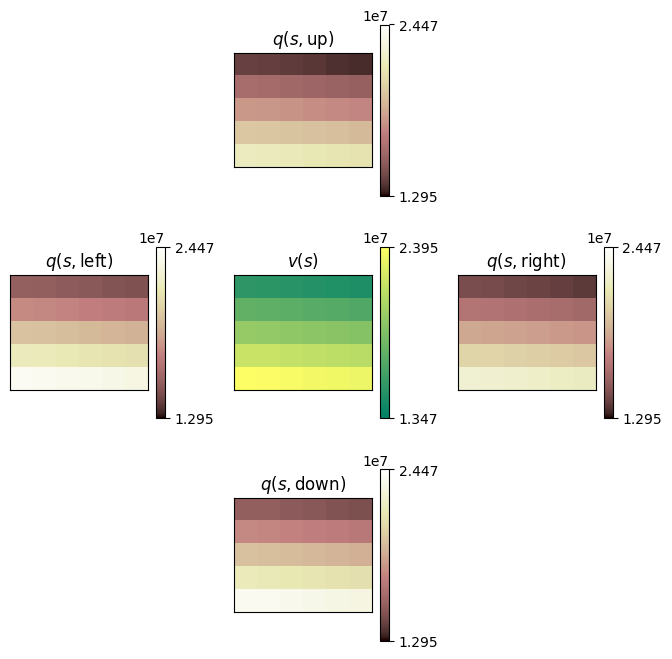

In [64]:
#@title Visualise the learned Q values. Szwabe: Is the agent model-based? Why?

# Evaluate the policy for every state, similar to tabular agents above.

environment.reset()
pi = np.zeros(grid._layout_dims, dtype=np.int32)
q = np.zeros(grid._layout_dims + (4,))
for y in range(grid._layout_dims[0]):
  for x in range(grid._layout_dims[1]):
    # Hack observation to see what the Q-network would output at that point.
    environment.set_state(x, y)
    obs = environment.get_obs()
    q[y, x] = np.asarray(agent.q_values(obs))
    pi[y, x] = np.asarray(agent.select_action(obs))

plot_action_values(q)


Nowak: No, the agent is **not model-based**. Although we are evaluating the learned Q-values at every state using direct queries to the Q-network, this does not imply that the agent uses or learns a model of the environment's dynamics (i.e., transition probabilities or reward function). Instead, it is still **model-free**, since learning occurs through interaction with the environment and stored experiences, without constructing an explicit model of how the environment behaves.


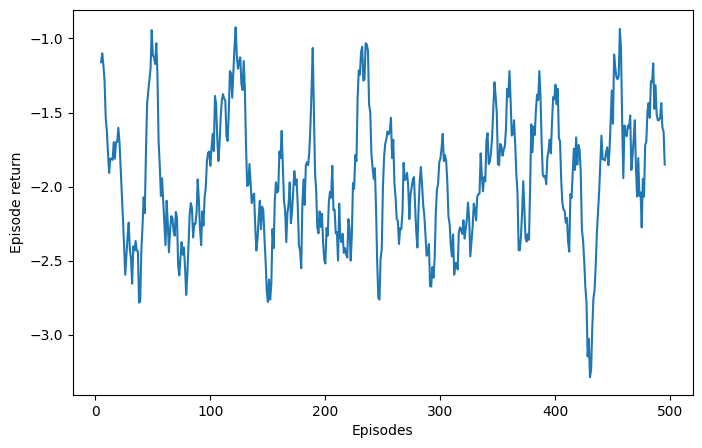

In [65]:
#@title Visualise the training curve { form-width: "30%" }

# Compute rolling average over returns
returns_avg = pd.Series(returns).rolling(10, center=True).mean()

plt.figure(figsize=(8, 5))
plt.plot(range(len(returns)), returns_avg)
plt.xlabel('Episodes')
plt.ylabel('Episode return');

### Compare the greedy and behaviour ($\epsilon$-greedy) policies

Notice that the behaviour policy randomly flips arrows to random directions.

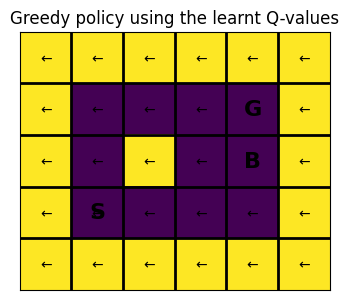

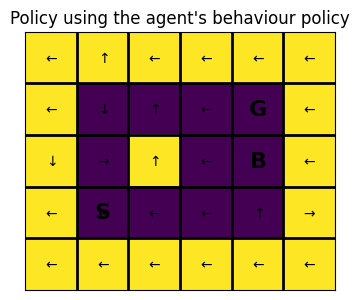

In [66]:
environment.plot_greedy_policy(q)
plt.title('Greedy policy using the learnt Q-values')

environment.plot_policy(pi)
plt.title("Policy using the agent's behaviour policy");

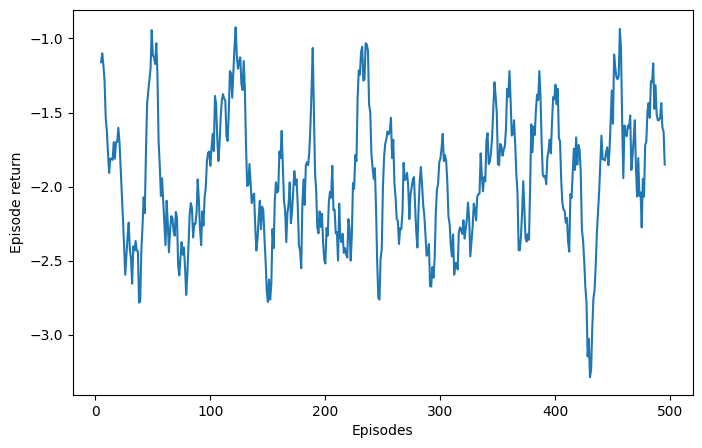

In [67]:
#@title Visualise the training curve { form-width: "30%" }

# Compute rolling average over returns
returns_avg = pd.Series(returns).rolling(10, center=True).mean()

plt.figure(figsize=(8, 5))
plt.plot(range(len(returns)), returns_avg)
plt.xlabel('Episodes')
plt.ylabel('Episode return');

In [68]:
!pip freeze

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.8.1
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.28.0.37.27
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.2
bokeh==3.7.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
bsuite==0.3.5
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour=

A working set of packages:
absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.4.2
bs4==0.0.1
bsuite==0.3.5
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==1.25.3
dlib @ file:///dlib-19.18.0-cp37-cp37m-linux_x86_64.whl
dm-acme==0.3.0
dm-control==0.0.364896371
dm-env==1.5
dm-launchpad==0.4.1
dm-reverb==0.6.1
dm-sonnet==2.0.0
dm-tree==0.1.6
docopt==0.6.2
docutils==0.17.1
dopamine-rl==1.0.5
earthengine-api==0.1.300
easydict==1.9
ecos==2.0.10
editdistance==0.5.3
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
entrypoints==0.4
ephem==4.1.3
et-xmlfile==1.1.0
fa2==0.3.5
fastai==1.0.61
fastdtw==0.3.4
fastprogress==1.0.2
fastrlock==0.8
fbprophet==0.7.1
feather-format==0.4.1
filelock==3.6.0
firebase-admin==4.4.0
fix-yahoo-finance==0.0.22
Flask==1.1.4
flatbuffers==2.0
folium==0.8.3
frozendict==2.3.0
future==0.16.0
gast==0.4.0
GDAL==2.2.2
gdown==4.2.2
gensim==3.6.0
geographiclib==1.52
geopy==1.17.0
gin-config==0.5.0
glfw==2.5.1
glob2==0.7
google==2.0.3
google-api-core==1.26.3
google-api-python-client==1.12.10
google-auth==1.35.0
google-auth-httplib2==0.0.4
google-auth-oauthlib==0.4.6
google-cloud-bigquery==1.21.0
google-cloud-bigquery-storage==1.1.0
google-cloud-core==1.0.3
google-cloud-datastore==1.8.0
google-cloud-firestore==1.7.0
google-cloud-language==1.2.0
google-cloud-storage==1.18.1
google-cloud-translate==1.5.0
google-colab @ file:///colabtools/dist/google-colab-1.0.0.tar.gz
google-pasta==0.2.0
google-resumable-media==0.4.1
googleapis-common-protos==1.55.0
googledrivedownloader==0.4
graphviz==0.10.1
greenlet==1.1.2
grpcio==1.44.0
gspread==3.4.2
gspread-dataframe==3.0.8
gym==0.17.3
h5py==3.1.0
HeapDict==1.0.1
hijri-converter==2.2.3
holidays==0.10.5.2
holoviews==1.14.8
html5lib==1.0.1
httpimport==0.5.18
httplib2==0.17.4
httplib2shim==0.0.3
humanize==0.5.1
hyperopt==0.1.2
ideep4py==2.0.0.post3
idna==2.10
imageio==2.4.1
imagesize==1.3.0
imbalanced-learn==0.8.1
imblearn==0.0
imgaug==0.2.9
importlib-metadata==4.11.1
importlib-resources==5.4.0
imutils==0.5.4
inflect==2.1.0
iniconfig==1.1.1
intel-openmp==2022.0.2
intervaltree==2.1.0
ipykernel==4.10.1
ipython==5.5.0
ipython-genutils==0.2.0
ipython-sql==0.3.9
ipywidgets==7.6.5
itsdangerous==1.1.0
jax==0.3.1
jaxlib @ https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.3.0+cuda11.cudnn805-cp37-none-manylinux2010_x86_64.whl
jedi==0.18.1
jieba==0.42.1
Jinja2==2.11.3
joblib==1.1.0
jpeg4py==0.1.4
jsonschema==4.3.3
jupyter==1.0.0
jupyter-client==5.3.5
jupyter-console==5.2.0
jupyter-core==4.9.2
jupyterlab-pygments==0.1.2
jupyterlab-widgets==1.0.2
kaggle==1.5.12
kapre==0.3.7
keras==2.7.0
Keras-Preprocessing==1.1.2
keras-vis==0.4.1
kiwisolver==1.3.2
korean-lunar-calendar==0.2.1
labmaze==1.0.5
libclang==13.0.0
librosa==0.8.1
lightgbm==2.2.3
llvmlite==0.34.0
lmdb==0.99
LunarCalendar==0.0.9
lxml==4.2.6
Markdown==3.3.6
MarkupSafe==2.0.1
matplotlib==3.2.2
matplotlib-inline==0.1.3
matplotlib-venn==0.11.6
missingno==0.5.0
mistune==0.8.4
mizani==0.6.0
mkl==2019.0
mlxtend==0.14.0
mock==4.0.3
more-itertools==8.12.0
moviepy==0.2.3.5
mpmath==1.2.1
msgpack==1.0.3
multiprocess==0.70.12.2
multitasking==0.0.10
murmurhash==1.0.6
music21==5.5.0
natsort==5.5.0
nbclient==0.5.11
nbconvert==5.6.1
nbformat==5.1.3
nest-asyncio==1.5.4
netCDF4==1.5.8
networkx==2.6.3
nibabel==3.0.2
nltk==3.2.5
notebook==5.3.1
numba==0.51.2
numexpr==2.8.1
numpy==1.21.5
nvidia-ml-py3==7.352.0
oauth2client==4.1.3
oauthlib==3.2.0
okgrade==0.4.3
opencv-contrib-python==4.1.2.30
opencv-python==4.1.2.30
openpyxl==3.0.9
opt-einsum==3.3.0
osqp==0.6.2.post0
packaging==21.3
palettable==3.3.0
pandas==1.3.5
pandas-datareader==0.9.0
pandas-gbq==0.13.3
pandas-profiling==1.4.1
pandocfilters==1.5.0
panel==0.12.1
param==1.12.0
parso==0.8.3
pathlib==1.0.1
patsy==0.5.2
pep517==0.12.0
pexpect==4.8.0
pickleshare==0.7.5
Pillow==7.1.2
pip-tools==6.2.0
plac==1.1.3
plotly==5.5.0
plotnine==0.6.0
pluggy==0.7.1
pooch==1.6.0
portpicker==1.3.9
prefetch-generator==1.0.1
preshed==3.0.6
prettytable==3.1.1
progressbar2==3.38.0
prometheus-client==0.13.1
promise==2.3
prompt-toolkit==1.0.18
protobuf==3.17.3
psutil==5.4.8
psycopg2==2.7.6.1
ptyprocess==0.7.0
py==1.11.0
pyarrow==6.0.1
pyasn1==0.4.8
pyasn1-modules==0.2.8
pycocotools==2.0.4
pycparser==2.21
pyct==0.4.8
pydata-google-auth==1.3.0
pydot==1.3.0
pydot-ng==2.0.0
pydotplus==2.0.2
PyDrive==1.3.1
pyemd==0.5.1
pyerfa==2.0.0.1
pyglet==1.5.0
Pygments==2.6.1
pygobject==3.26.1
pymc3==3.11.4
PyMeeus==0.5.11
pymongo==4.0.1
pymystem3==0.2.0
PyOpenGL==3.1.6
pyparsing==3.0.7
pyrsistent==0.18.1
pysndfile==1.3.8
PySocks==1.7.1
pystan==2.19.1.1
pytest==3.6.4
python-apt==0.0.0
python-chess==0.23.11
python-dateutil==2.8.2
python-louvain==0.16
python-slugify==6.1.0
python-utils==3.1.0
pytz==2018.9
pyviz-comms==2.1.0
PyWavelets==1.2.0
PyYAML==3.13
pyzmq==22.3.0
qdldl==0.1.5.post0
qtconsole==5.2.2
QtPy==2.0.1
regex==2019.12.20
requests==2.23.0
requests-oauthlib==1.3.1
resampy==0.2.2
rpy2==3.4.5
rsa==4.8
scikit-image==0.18.3
scikit-learn==1.0.2
scipy==1.4.1
screen-resolution-extra==0.0.0
scs==3.2.0
seaborn==0.11.2
semver==2.13.0
Send2Trash==1.8.0
setuptools-git==1.2
Shapely==1.8.1.post1
simplegeneric==0.8.1
six==1.15.0
sklearn==0.0
sklearn-pandas==1.8.0
smart-open==5.2.1
snowballstemmer==2.2.0
sortedcontainers==2.4.0
SoundFile==0.10.3.post1
spacy==2.2.4
Sphinx==1.8.6
sphinxcontrib-serializinghtml==1.1.5
sphinxcontrib-websupport==1.2.4
SQLAlchemy==1.4.31
sqlparse==0.4.2
srsly==1.0.5
statsmodels==0.10.2
sympy==1.7.1
tables==3.7.0
tabulate==0.8.9
tblib==1.7.0
tenacity==8.0.1
tensorboard==2.8.0
tensorboard-data-server==0.6.1
tensorboard-plugin-wit==1.8.1
tensorflow==2.7.0
tensorflow-datasets==4.4.0
tensorflow-estimator==2.7.0
tensorflow-gcs-config==2.8.0
tensorflow-hub==0.12.0
tensorflow-io-gcs-filesystem==0.24.0
tensorflow-metadata==1.6.0
tensorflow-probability==0.15.0
termcolor==1.1.0
terminado==0.13.1
testpath==0.6.0
text-unidecode==1.3
textblob==0.15.3
tf-estimator-nightly==2.8.0.dev2021122109
Theano-PyMC==1.1.2
thinc==7.4.0
threadpoolctl==3.1.0
tifffile==2021.11.2
tomli==2.0.1
toolz==0.11.2
torch @ https://download.pytorch.org/whl/cu111/torch-1.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu111/torchaudio-0.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchsummary==1.5.1
torchtext==0.11.0
torchvision @ https://download.pytorch.org/whl/cu111/torchvision-0.11.1%2Bcu111-cp37-cp37m-linux_x86_64.whl
tornado==5.1.1
tqdm==4.62.3
traitlets==5.1.1
trfl==1.2.0
tweepy==3.10.0
typeguard==2.7.1
typing-extensions==3.10.0.2
tzlocal==1.5.1
uritemplate==3.0.1
urllib3==1.24.3
vega-datasets==0.9.0
wasabi==0.9.0
wcwidth==0.2.5
webencodings==0.5.1
Werkzeug==1.0.1
widgetsnbextension==3.5.2
wordcloud==1.5.0
wrapt==1.13.3
xarray==0.18.2
xgboost==0.90
xkit==0.0.0
xlrd==1.1.0
xlwt==1.3.0
zict==2.0.0
zipp==3.7.0

